# Kaggle COVID19 Global Forecasting (Week 3)

In [103]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import seaborn as sns
import matplotlib.pyplot as plt

# Get COVID19 data

In [104]:
submission_example = pd.read_csv('covid19-global-forecasting-week-3/submission.csv')
test = pd.read_csv('covid19-global-forecasting-week-3/test.csv')
train = pd.read_csv('covid19-global-forecasting-week-3/train.csv')

In [105]:
train['Province_State'].fillna(train['Country_Region'],inplace = True)
test['Province_State'].fillna(test['Country_Region'],inplace = True)

In [106]:
test['Date'].unique()

array(['2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29',
       '2020-03-30', '2020-03-31', '2020-04-01', '2020-04-02',
       '2020-04-03', '2020-04-04', '2020-04-05', '2020-04-06',
       '2020-04-07', '2020-04-08', '2020-04-09', '2020-04-10',
       '2020-04-11', '2020-04-12', '2020-04-13', '2020-04-14',
       '2020-04-15', '2020-04-16', '2020-04-17', '2020-04-18',
       '2020-04-19', '2020-04-20', '2020-04-21', '2020-04-22',
       '2020-04-23', '2020-04-24', '2020-04-25', '2020-04-26',
       '2020-04-27', '2020-04-28', '2020-04-29', '2020-04-30',
       '2020-05-01', '2020-05-02', '2020-05-03', '2020-05-04',
       '2020-05-05', '2020-05-06', '2020-05-07'], dtype=object)

In [107]:
train["Date"] = pd.to_datetime(train["Date"])
test["Date"] = pd.to_datetime(test["Date"])
train["Day"] = (train['Date']-train['Date'].iloc[0]).dt.days
test["Day"] = (train['Date']-train['Date'].iloc[0]).dt.days

In [108]:
#open_period only_use data 1/22~3/19
val = train[train["Date"] >= '2020-03-26T00:00:00.000000000'].reset_index(drop = True)
train = train[train["Date"] < '2020-03-26T00:00:00.000000000'].reset_index(drop = True)

In [109]:
train['From'] = 'train'
val['From'] = 'val'
all_data = pd.concat([train,val])

In [110]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22644 entries, 0 to 3059
Data columns (total 8 columns):
Id                22644 non-null int64
Province_State    22644 non-null object
Country_Region    22644 non-null object
Date              22644 non-null datetime64[ns]
ConfirmedCases    22644 non-null float64
Fatalities        22644 non-null float64
Day               22644 non-null int64
From              22644 non-null object
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 1.6+ MB


# Get population data for age distrubution

In [111]:
global_pop = pd.read_csv('IHME_GBD_2017_POP.CSV')
global_pop = global_pop[global_pop['year_id']==2017]
global_pop = global_pop[global_pop['sex_name']=='Both']
age_list = list(global_pop['age_group_name'].unique()[5:22])
age_list.append(global_pop['age_group_name'].unique()[0])
print(age_list)
global_pop = global_pop[global_pop['age_group_name'].isin(age_list)]
global_pop_piv = global_pop.pivot_table(index= 'location_name', columns='age_group_name', values ='val')
global_pop_piv['location'] = global_pop_piv.index
global_pop_piv = pd.DataFrame(global_pop_piv)

['5 to 9', '10 to 14', '15 to 19', '20 to 24', '25 to 29', '30 to 34', '35 to 39', '40 to 44', '45 to 49', '50 to 54', '55 to 59', '60 to 64', '65 to 69', '70 to 74', '75 to 79', '80 plus', 'All Ages', 'Under 5']


In [112]:
all_data = pd.merge(left=all_data, right = global_pop_piv, left_on='Province_State', right_on= 'location', how = 'left')

# Calculate 100 day onset

In [113]:
def get_100(df, feature,  US = False):
    #if US:
        #pop = pd.read_csv('us_age_dist.csv')
    df_by_features = df.groupby([feature,"Date"], as_index = False).sum()
    
    df_by_features_100 = df_by_features[df_by_features['ConfirmedCases'] >= 100]
    df_100 = pd.DataFrame(columns = df_by_features_100.columns)
    for c in df_by_features_100[feature].unique():
        c_df_100 = df_by_features_100[df_by_features_100[feature]== c]
        c_df_100['Day'] = range(len(c_df_100))
        for f in ['ConfirmedCases', 'Fatalities']:
            c_df_100[f] = c_df_100[f] - c_df_100[f].iloc[0]
        c_df_100['Diff_Case'] = c_df_100['ConfirmedCases'].diff()
        c_df_100['Diff_Death'] = c_df_100['Fatalities'].diff()
        #if US:
        #c_pop = pop[pop['Location']==c]
        #print(c_df_100.head())
        #c_pop = global_pop_piv[global_pop_piv.index== c]
        #c_df_100 = pd.merge(left = c_df_100, right = c_pop, left_on=feature, right_on = 'location_name', how = 'left')
        #print(c_df_100.head())
        elderly = c_df_100['60 to 64'] + c_df_100['65 to 69'] + c_df_100['70 to 74'] +c_df_100['75 to 79']+c_df_100['80 plus']
        c_df_100['Infected_rate'] = c_df_100['ConfirmedCases']/c_df_100['All Ages']
        c_df_100['Infected_rate_60+'] = c_df_100['ConfirmedCases']/elderly
        c_df_100['Fatality_rate'] = c_df_100['Fatalities']/c_df_100['ConfirmedCases']
        c_df_100['Fatality_per_60+_pop'] = c_df_100['Fatalities']/elderly
            
        df_100 = pd.concat([df_100,c_df_100])    
    return df_100

In [114]:
all_100_country = get_100(all_data,'Country_Region')

C:\Users\tsofo\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\tsofo\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\tsofo\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#i

In [115]:
all_100_us = get_100(all_data[all_data['Country_Region'] == 'US'],'Province_State',US=True)

C:\Users\tsofo\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\tsofo\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\tsofo\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#i

In [116]:
all_100_china = get_100(all_data[all_data['Country_Region'] == 'China'],'Province_State')

C:\Users\tsofo\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\tsofo\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\tsofo\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#i

In [117]:
all_100_china.to_csv('all_100_china.csv')
all_100_us.to_csv('all_100_us.csv')
all_100_country.to_csv('all_100_country.csv')
all_data.to_csv('all_data.csv')

# Make some pretty plots

In [119]:
def plt_100(df, f_plt, f_group,lo=0,hi=10,tag = '', f_list = ''):
    if f_list == '':
        f_list = f_plt
    list_country = df[f_group].unique()
    h_order = df[df[f_group].isin(list_country)].sort_values(by=f_list, ascending = False)[f_group].unique()
    plt.figure(figsize = (20,15))
    p1 = sns.lineplot(x = 'Day', y = f_plt, hue = f_group, data = df[df[f_group].isin(h_order[lo:hi])], hue_order = h_order[lo:hi])
    
    #p1.set_ylim(0, 25000)
    
    if lo == 0:
        fname = tag +' '+ f_plt + ' since First 100 Confirmed Cases (Top '+str(hi)+') ' 
        p1.set_title(fname)
    else:
        fname = tag +' '+ f_plt + ' since First 100 Confirmed Cases (Rank '+str(lo+1)+'-'+str(hi)+') '
        p1.set_title(fname)
    for c in h_order[lo:hi]:
        x_offset,y_offset = 0,0
        if c in ['Belgium']:
            y_offset = 50
        if c in ['Korea, South']:
            x_offset, y_offset = -3, -500
        cs = df[df[f_group]==c].sort_values(by='Date', ascending = False).head(1)
        p1.text(cs['Day']+0.5+x_offset ,cs[f_plt]+y_offset, c, horizontalalignment='left', size='medium', color='black', weight='semibold')
    plt.savefig(fname)

## Global

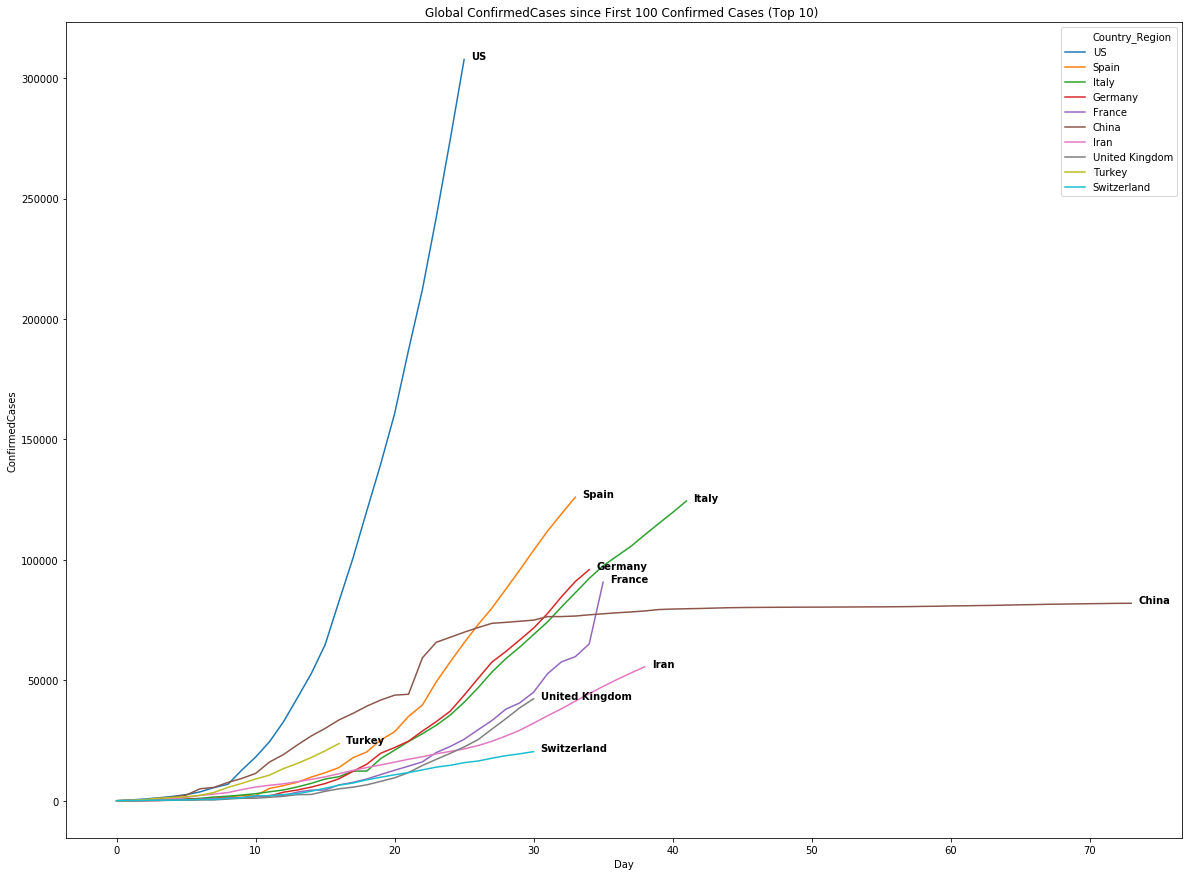

In [120]:
plt_100(all_100_country,'ConfirmedCases','Country_Region', tag = 'Global')

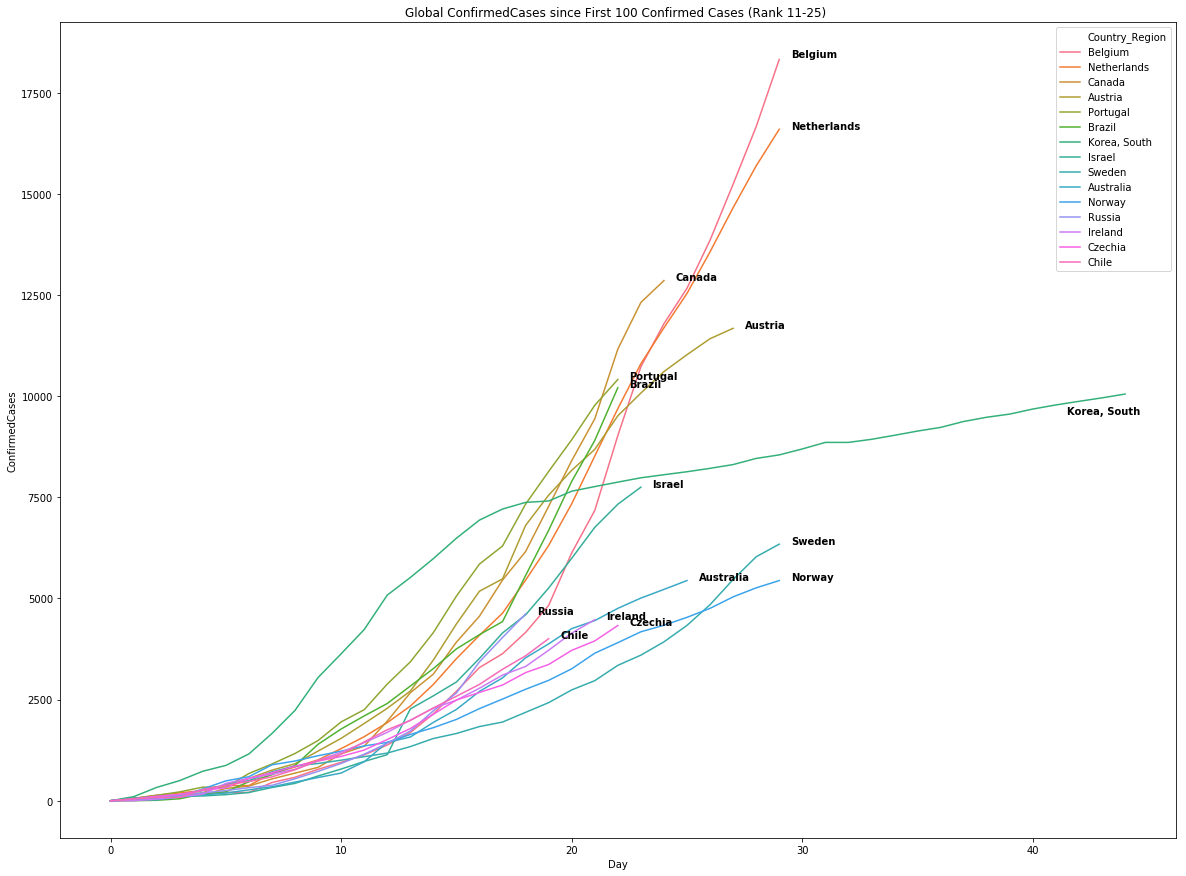

In [121]:
plt_100(all_100_country,'ConfirmedCases','Country_Region',10,25, tag = 'Global')

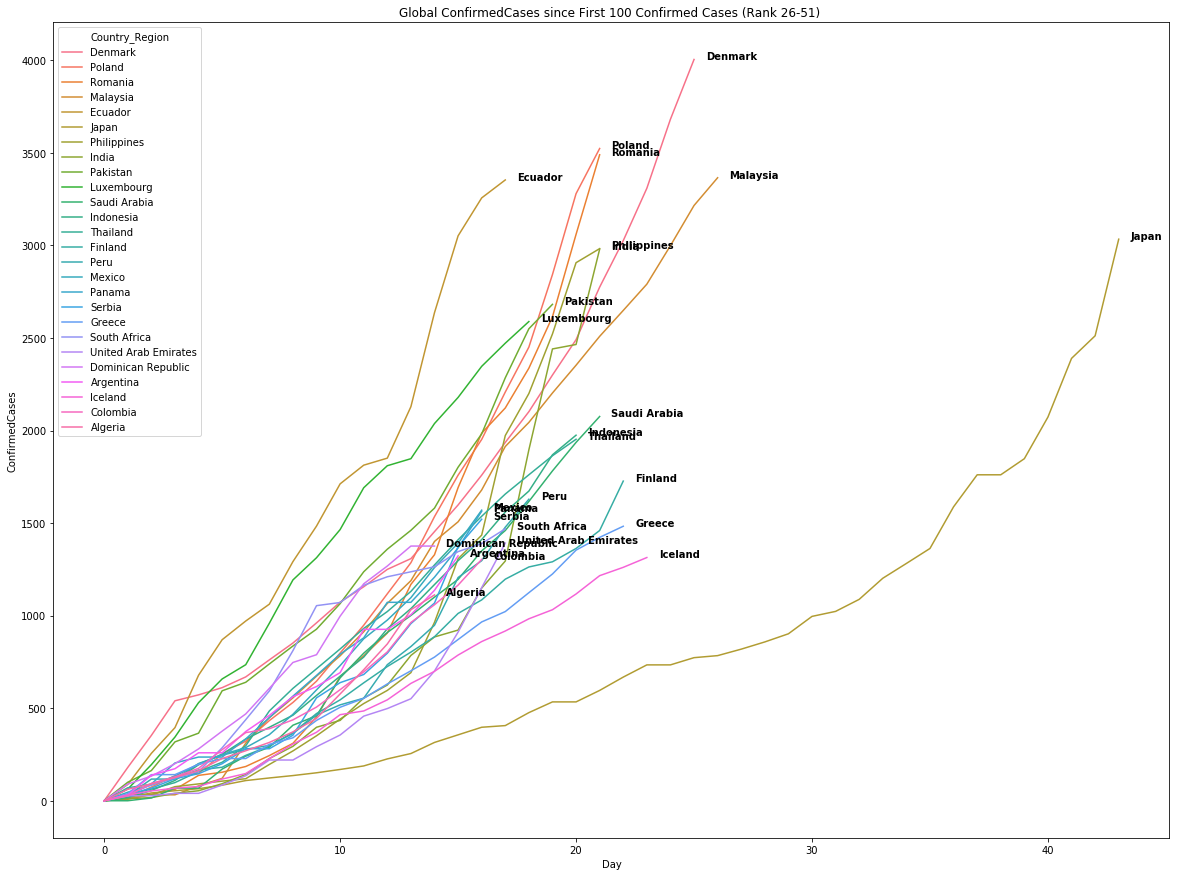

In [122]:
plt_100(all_100_country,'ConfirmedCases','Country_Region',25,51, tag = 'Global')

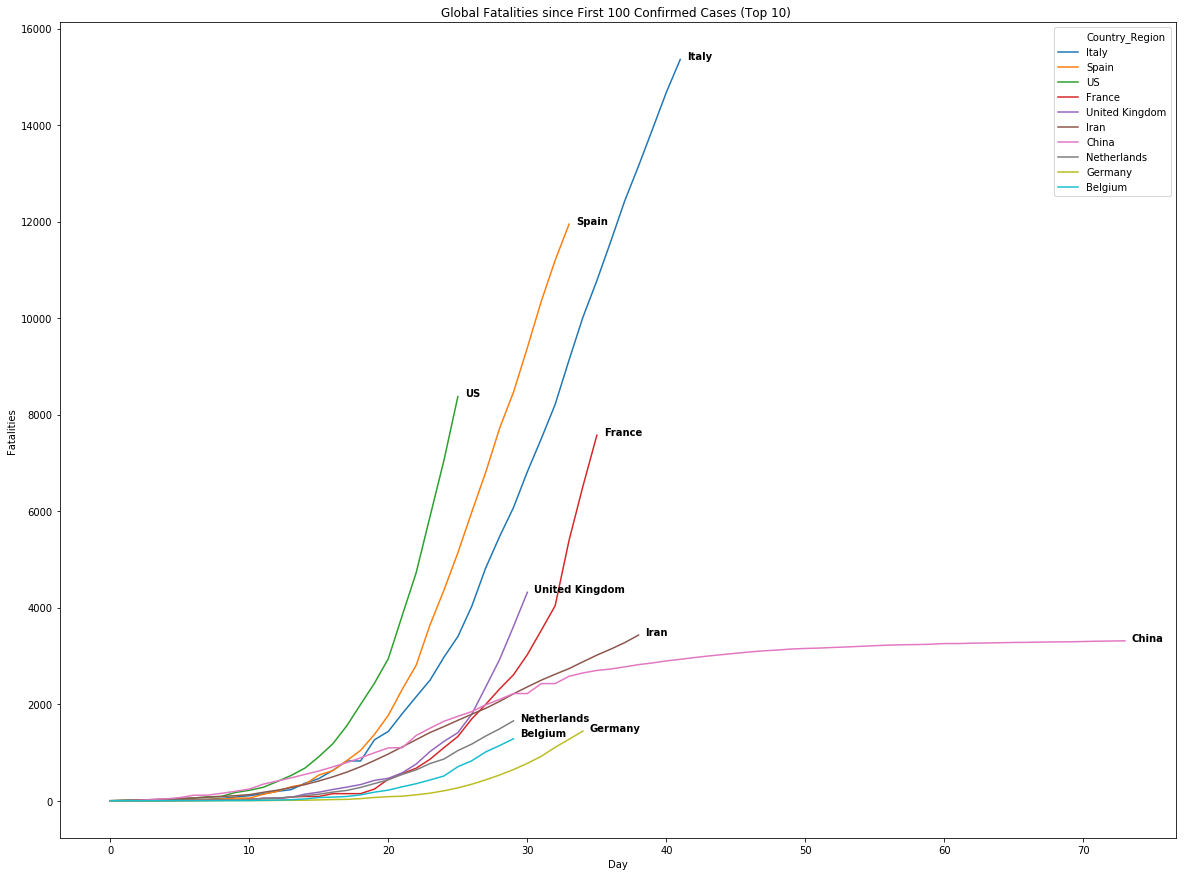

In [123]:
plt_100(all_100_country,'Fatalities','Country_Region',0,10, tag = 'Global')

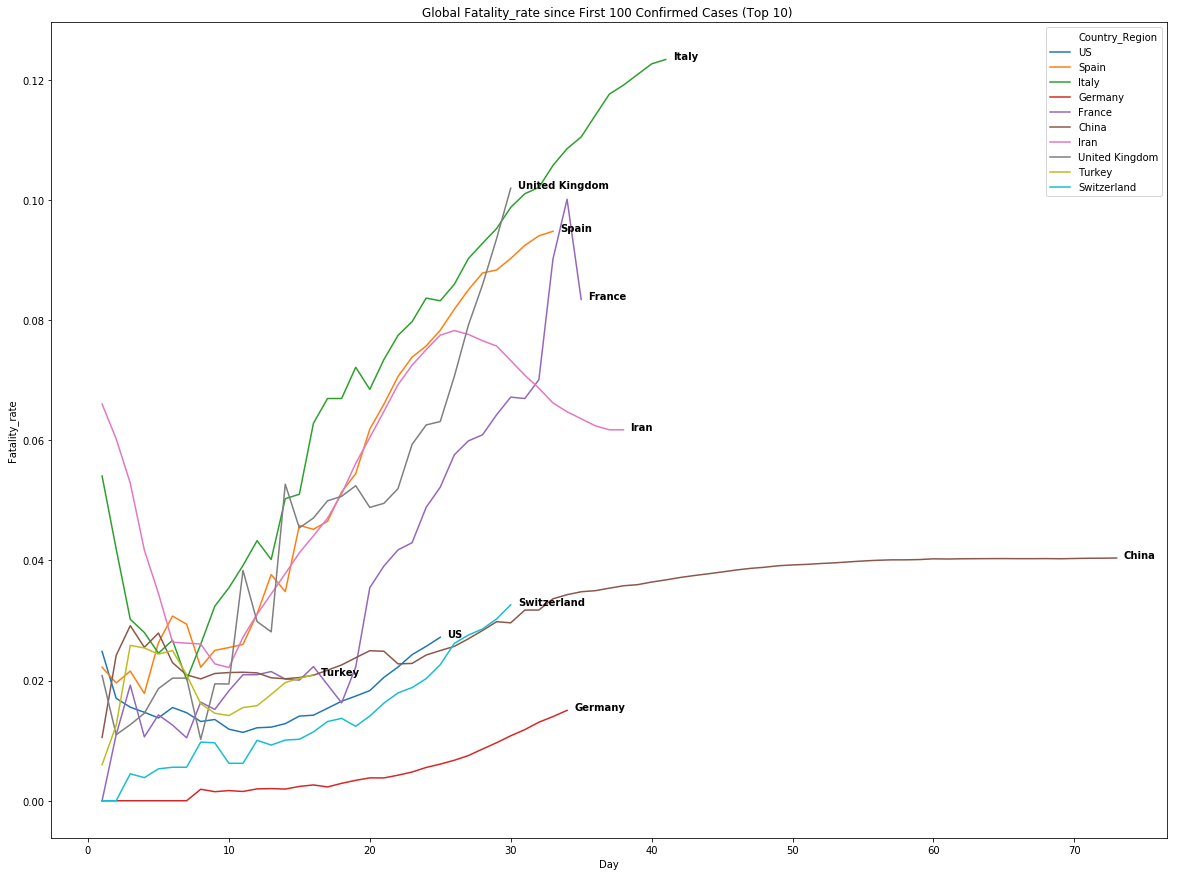

In [156]:
plt_100(all_100_country,'Fatality_rate','Country_Region',0,10, tag = 'Global',f_list='ConfirmedCases')

## China

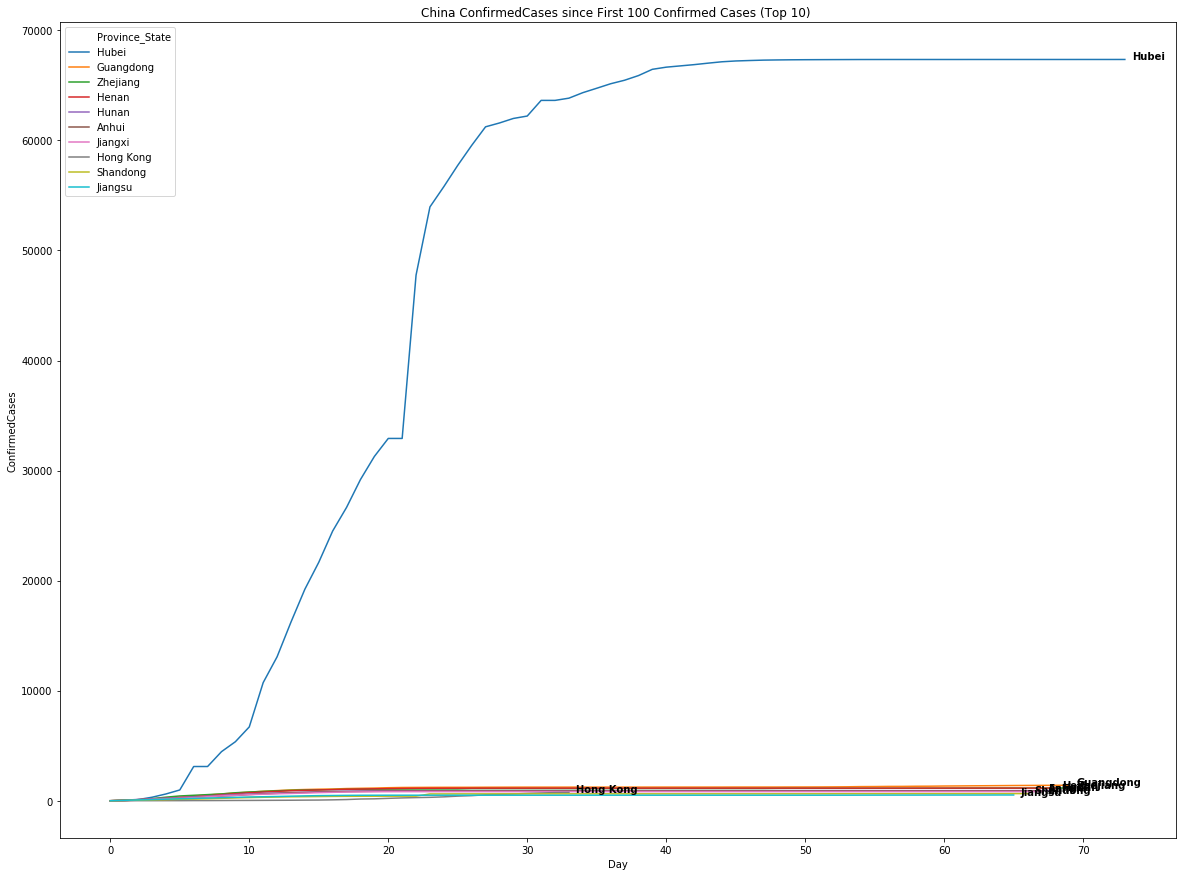

In [125]:
plt_100(all_100_china,'ConfirmedCases','Province_State',0, tag = 'China')

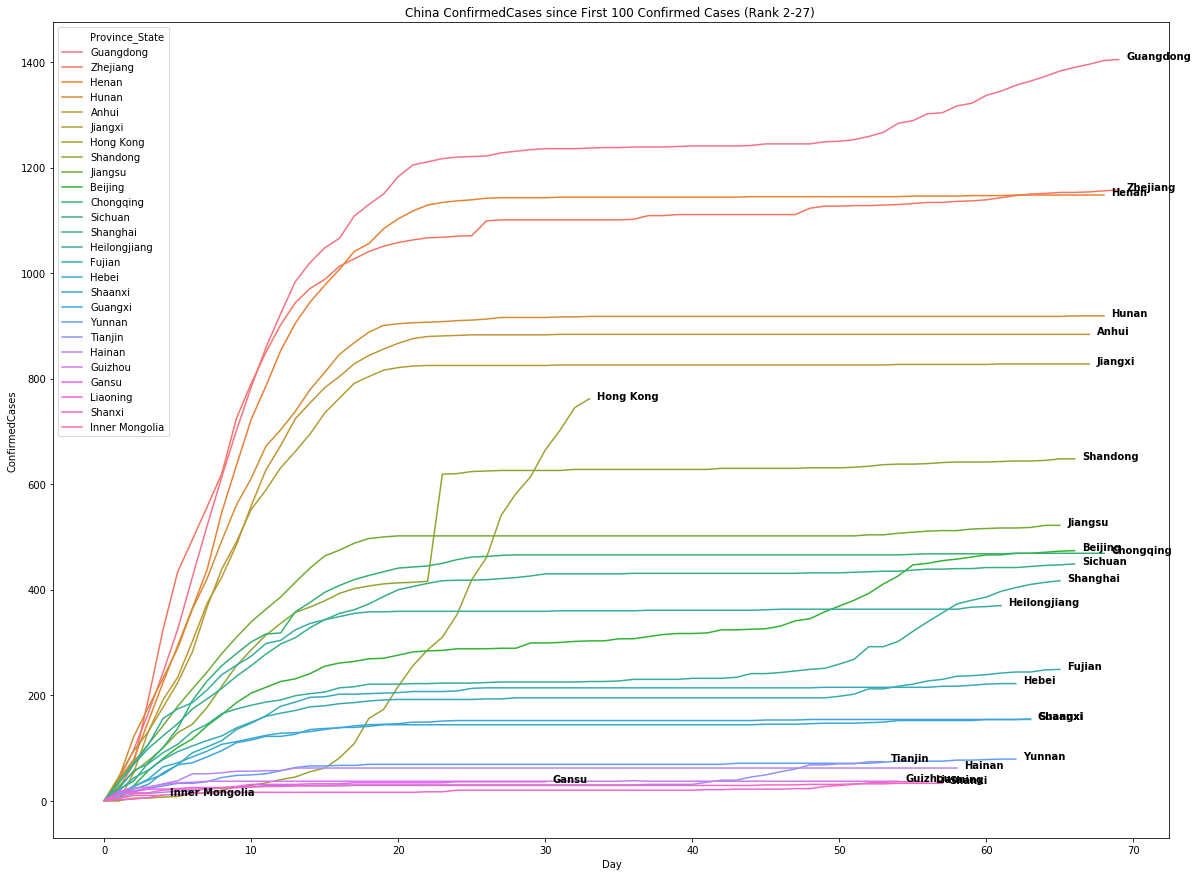

In [126]:
plt_100(all_100_china,'ConfirmedCases','Province_State',1,len(all_100_china['Province_State'].unique()), tag = 'China')

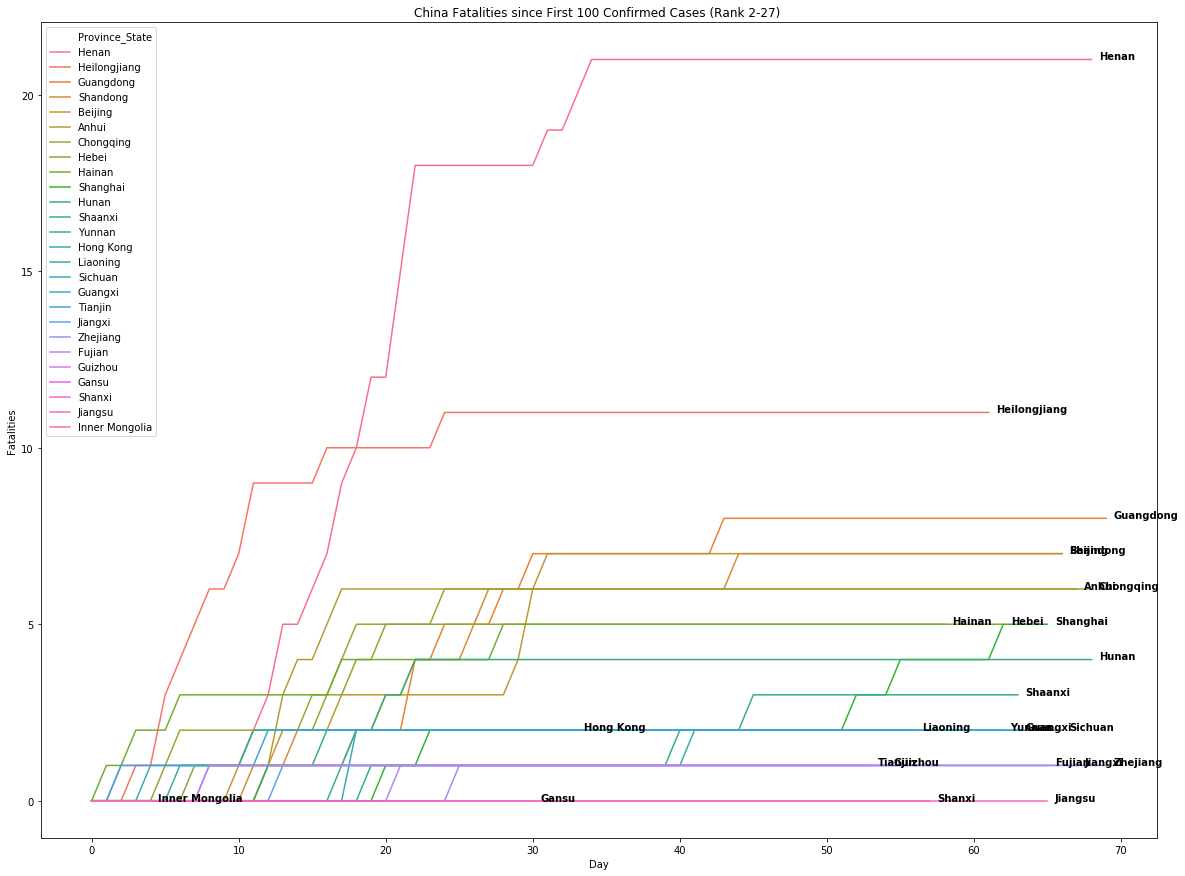

In [127]:
plt_100(all_100_china,'Fatalities','Province_State',1, len(all_100_china['Province_State'].unique()), tag = 'China')

## United States

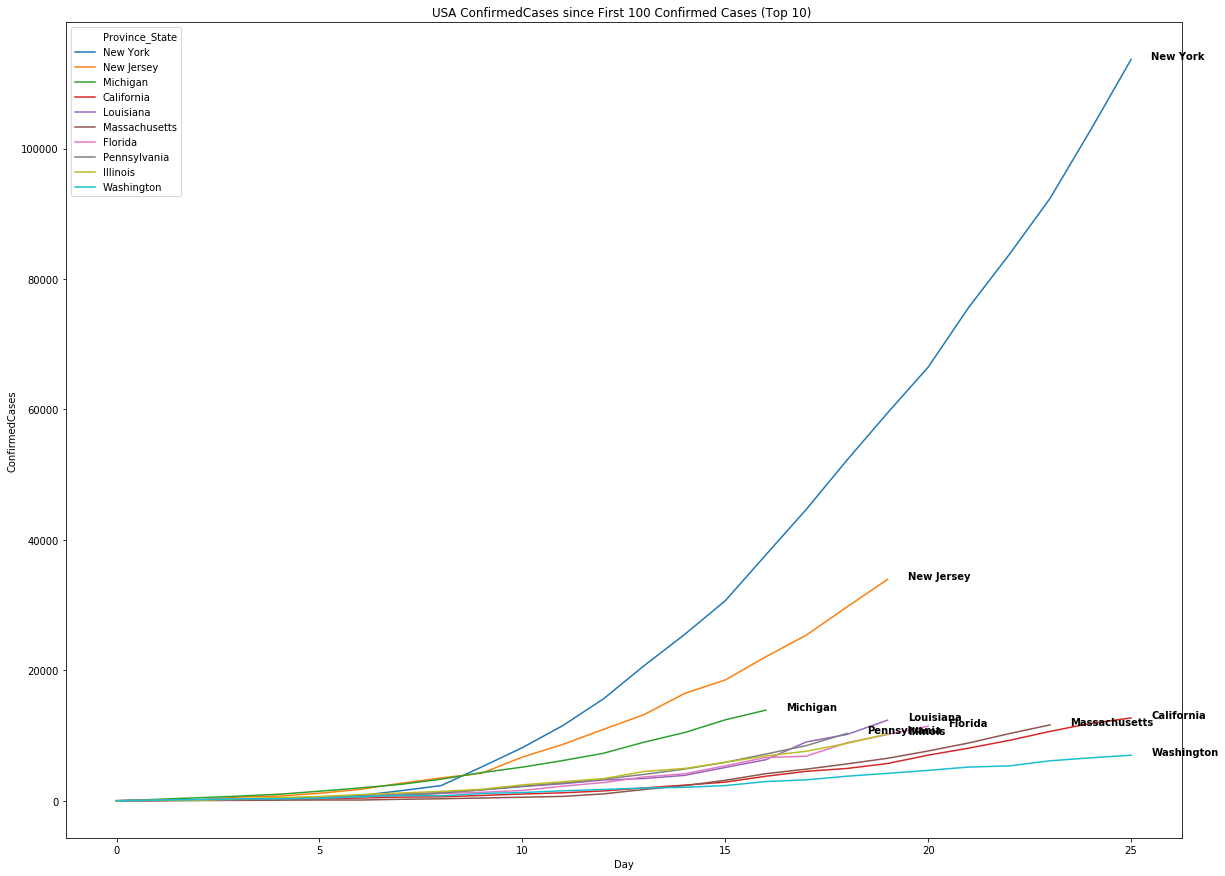

In [128]:
plt_100(all_100_us,'ConfirmedCases','Province_State',0,10, tag = 'USA')

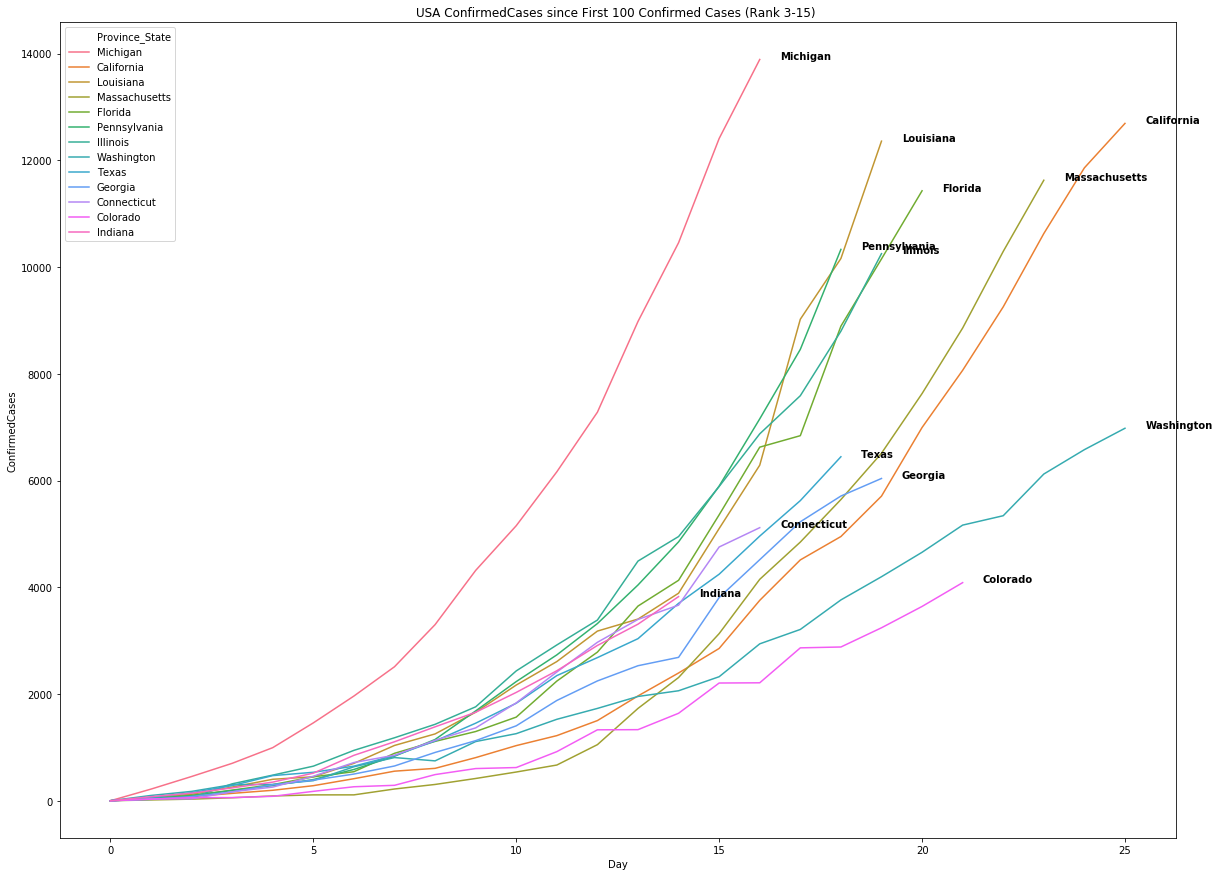

In [129]:
plt_100(all_100_us,'ConfirmedCases','Province_State',2,15, tag = 'USA')

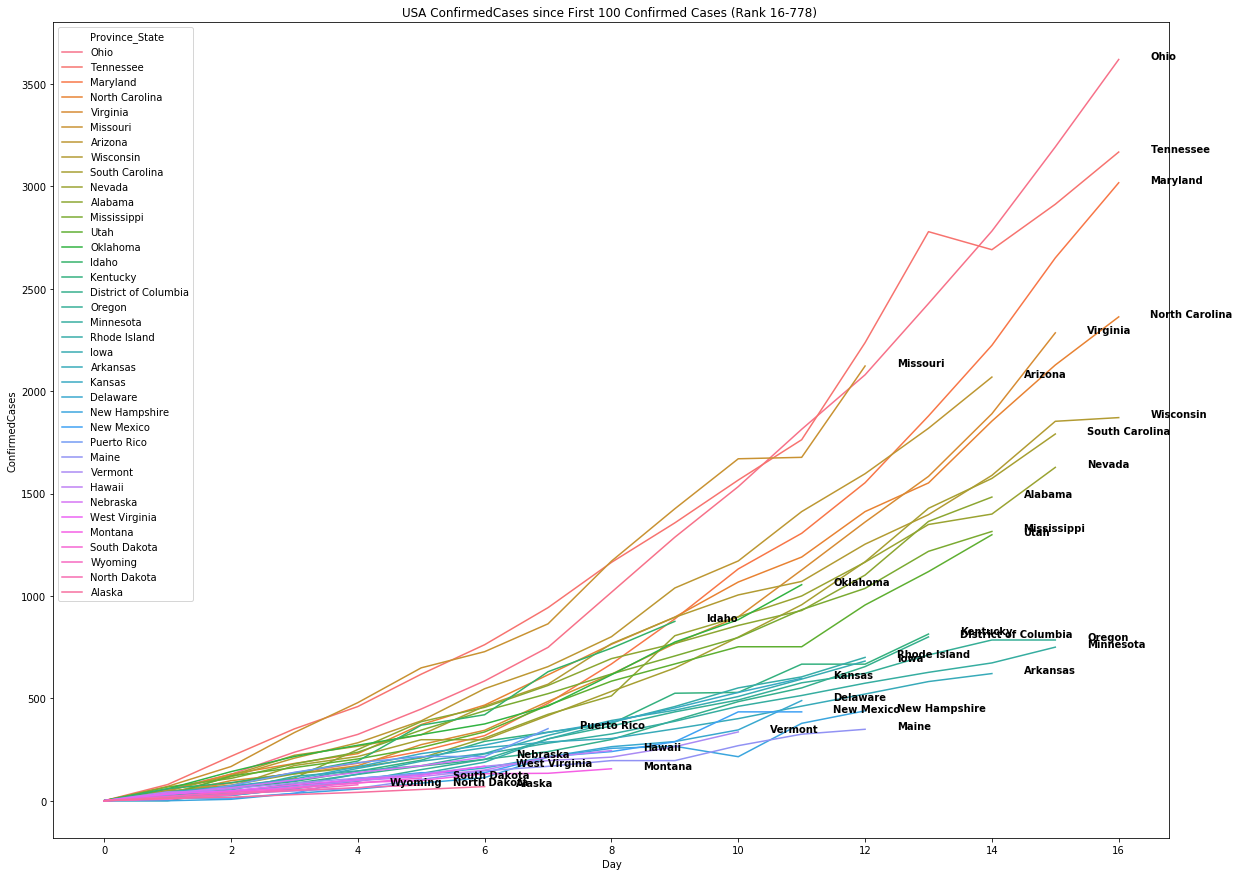

In [130]:
plt_100(all_100_us,'ConfirmedCases','Province_State',15, len(all_100_us),tag = 'USA')

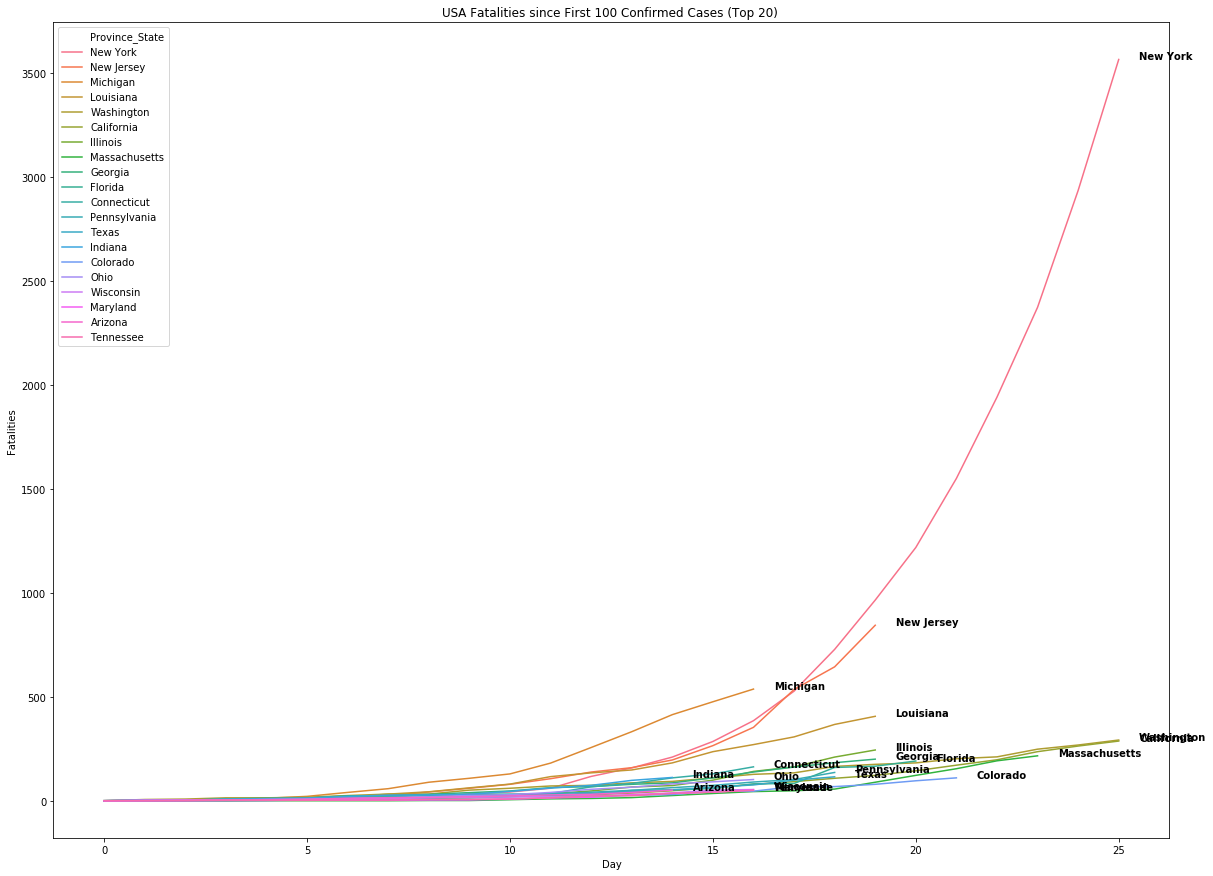

In [131]:
plt_100(all_100_us,'Fatalities','Province_State',0,20,tag = 'USA')

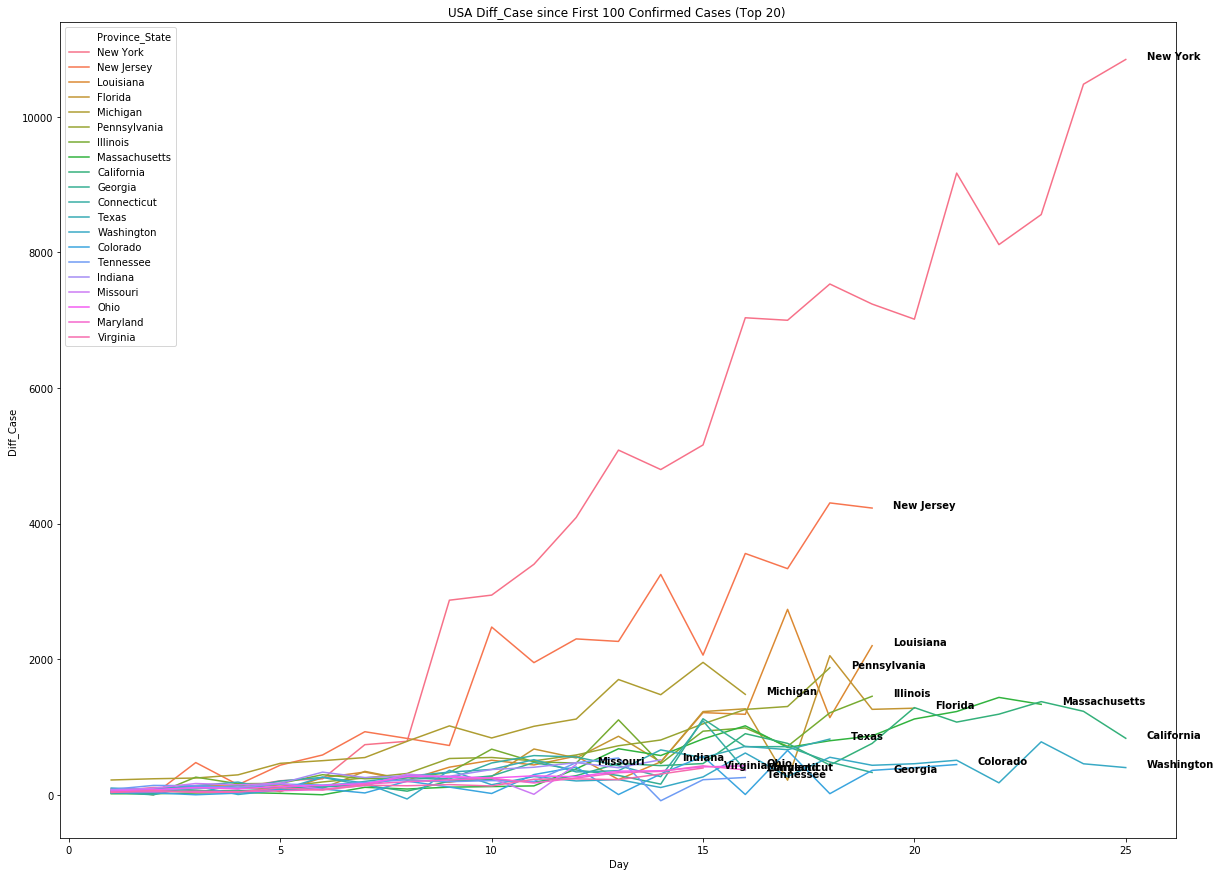

In [132]:
plt_100(all_100_us,'Diff_Case','Province_State',0,20,tag = 'USA')

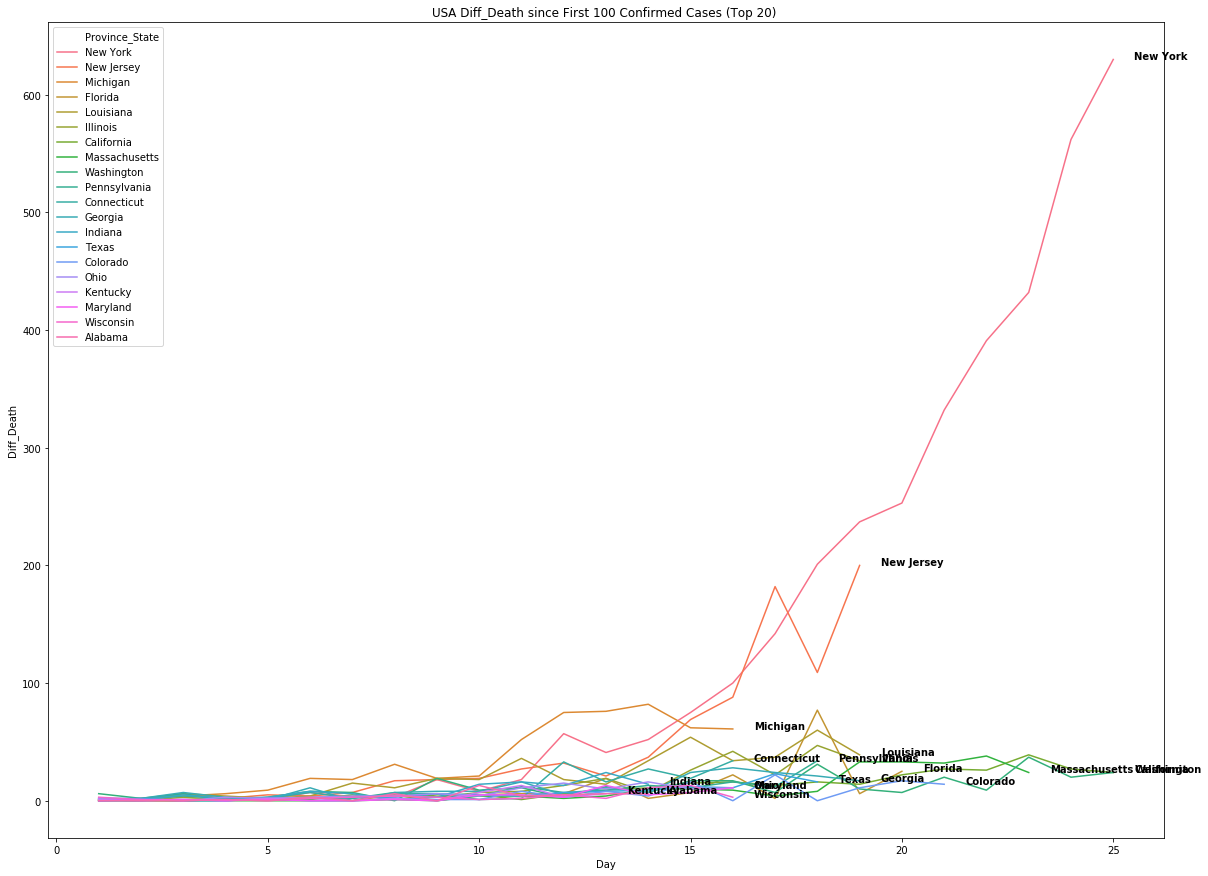

In [133]:
plt_100(all_100_us,'Diff_Death','Province_State',0,20,tag = 'USA')

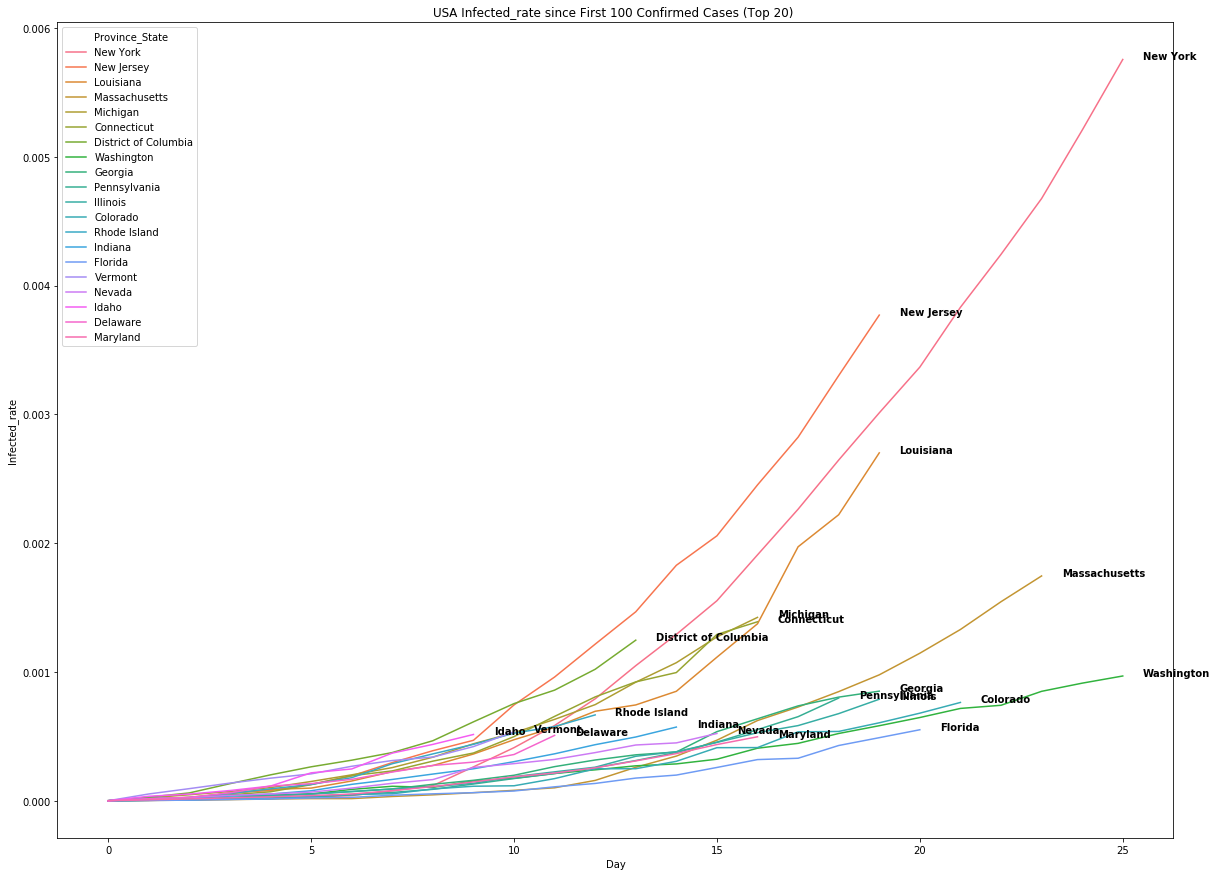

In [134]:
plt_100(all_100_us,'Infected_rate','Province_State',0,20,tag = 'USA')

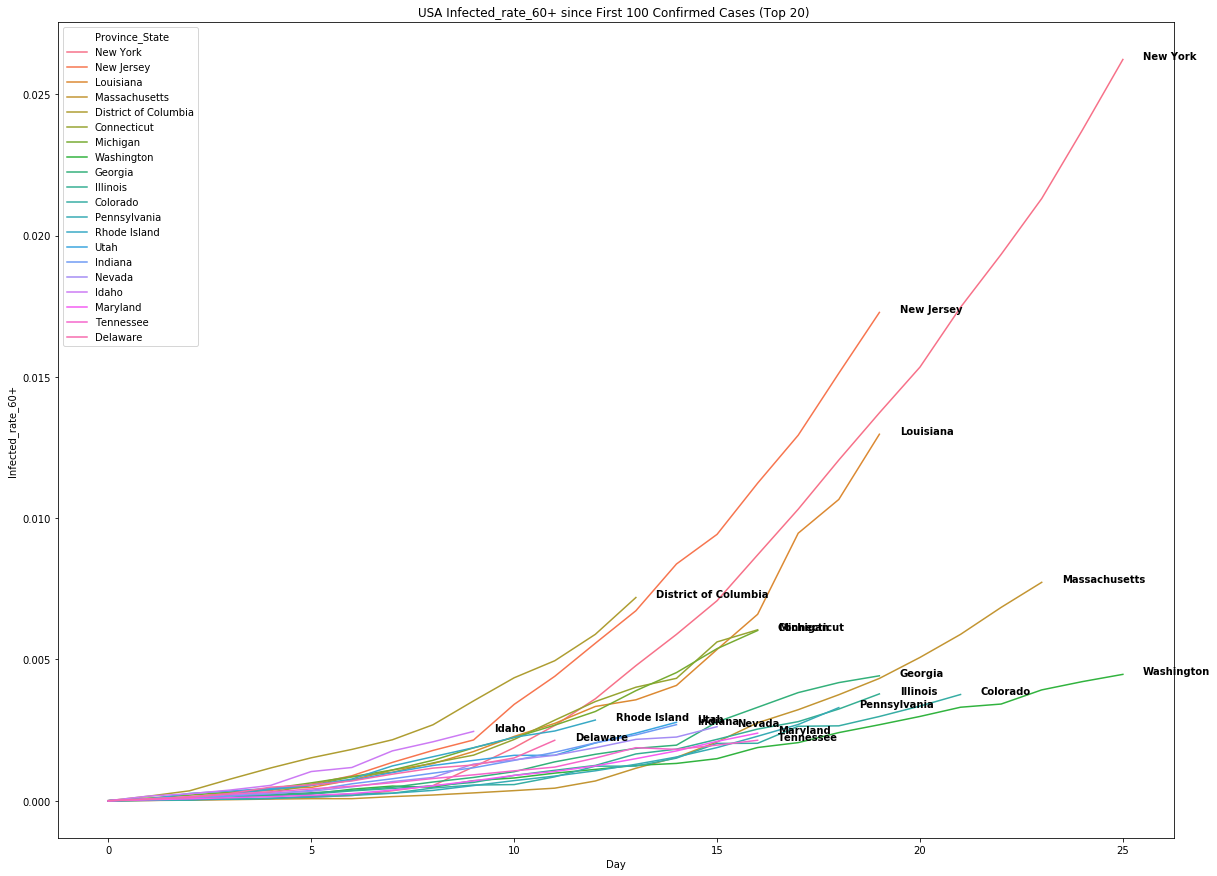

In [135]:
plt_100(all_100_us,'Infected_rate_60+','Province_State',0,20,tag = 'USA')

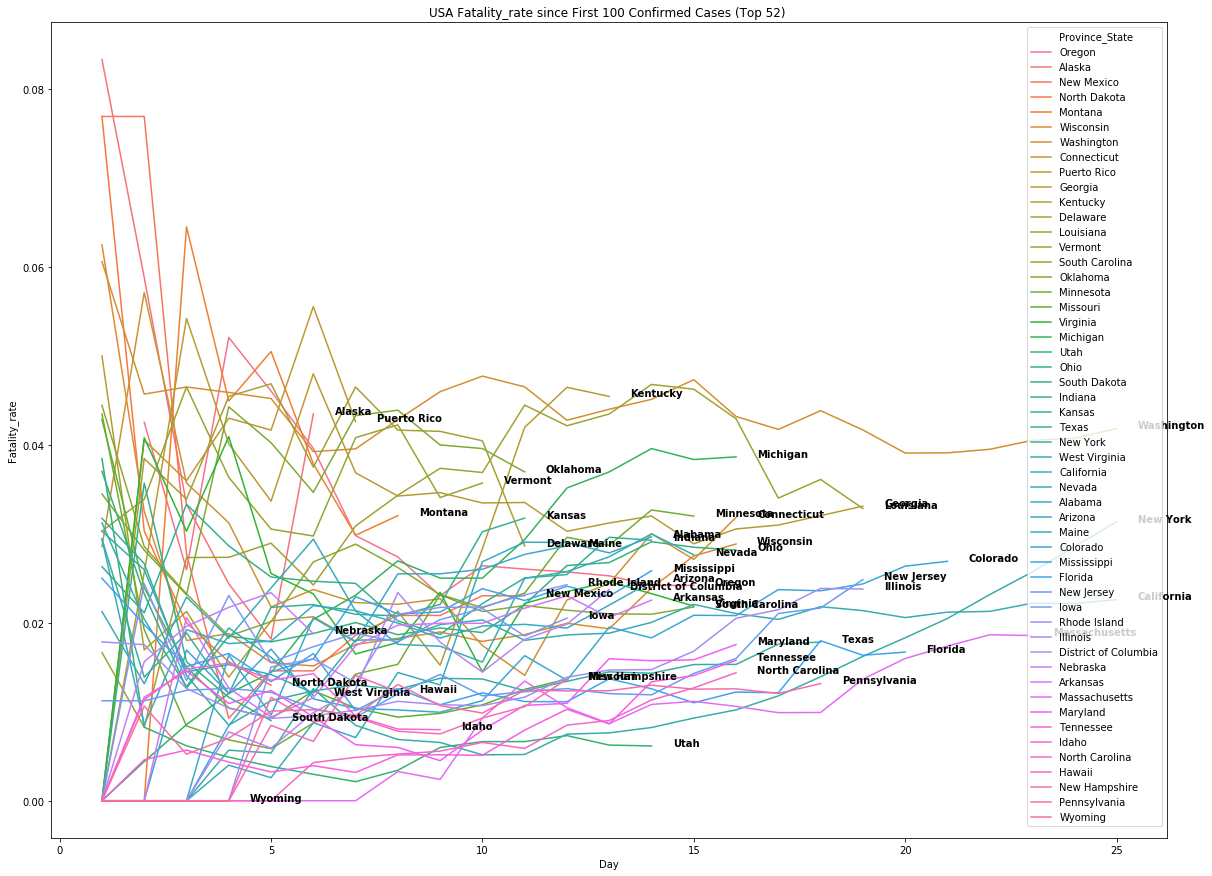

In [136]:
plt_100(all_100_us,'Fatality_rate','Province_State',0,len(all_100_us['Province_State'].unique()),tag = 'USA')

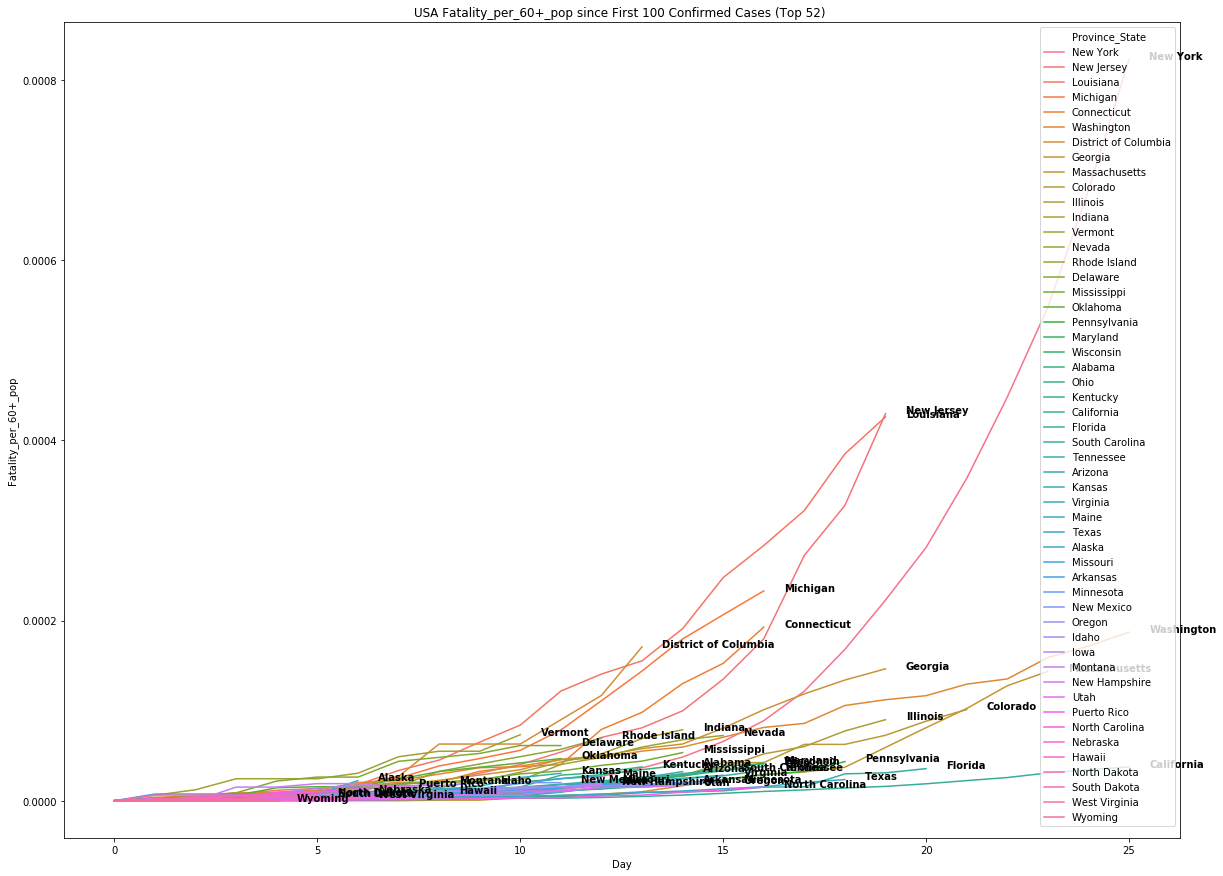

In [137]:
plt_100(all_100_us,'Fatality_per_60+_pop','Province_State',0,len(all_100_us['Province_State'].unique()),tag = 'USA')

In [138]:
all_100_us.columns

Index(['10 to 14', '15 to 19', '20 to 24', '25 to 29', '30 to 34', '35 to 39', '40 to 44', '45 to 49', '5 to 9', '50 to 54', '55 to 59', '60 to 64', '65 to 69', '70 to 74', '75 to 79', '80 plus', 'All Ages', 'ConfirmedCases', 'Date', 'Day', 'Diff_Case', 'Diff_Death', 'Fatalities', 'Fatality_per_60+_pop', 'Fatality_rate', 'Id', 'Infected_rate', 'Infected_rate_60+', 'Province_State', 'Under 5'], dtype='object')

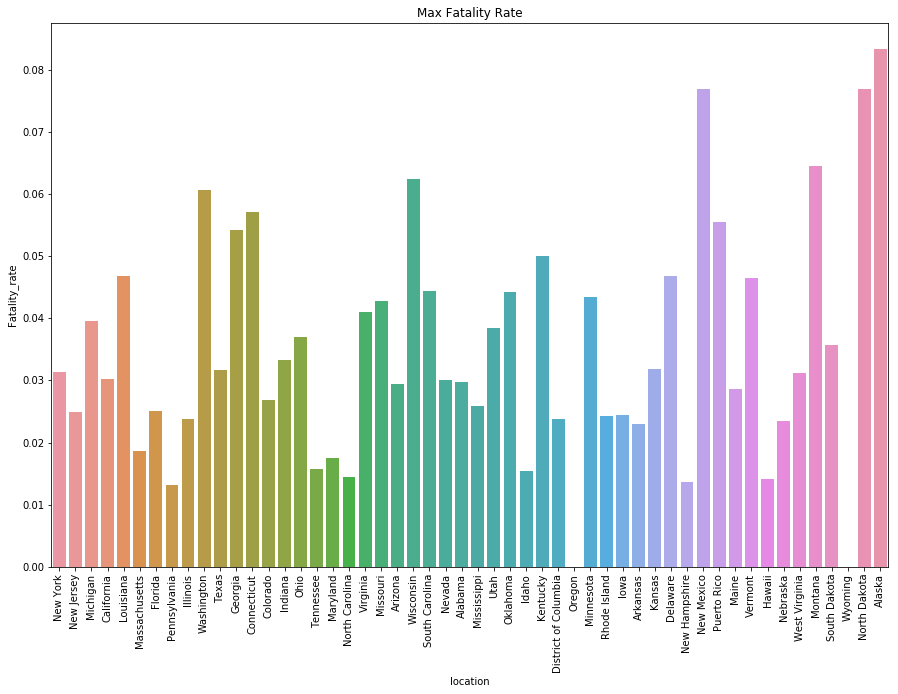

In [139]:
all_100_us_summary = all_100_us.groupby('Province_State').max().sort_values(by='ConfirmedCases', ascending = False)
all_100_us_summary['location'] = all_100_us_summary.index
plt.figure(figsize = (15,10))
p2 = sns.barplot(x = 'location', y = 'Fatality_rate', data = all_100_us_summary)
plt.xticks(rotation = 90)
p2.set_title('Max Fatality Rate')
plt.savefig('max_mortality_rate')

In [140]:
all_100_us_summary

10 to 14      15 to 19      20 to 24      25 to 29      30 to 34      35 to 39      40 to 44      45 to 49        5 to 9      50 to 54      55 to 59      60 to 64      65 to 69      70 to 74       75 to 79       80 plus      All Ages  ConfirmedCases       Date  Day  Diff_Case  Diff_Death  Fatalities  Fatality_per_60+_pop  Fatality_rate     Id  Infected_rate  Infected_rate_60+       Under 5              location
Province_State                                                                                                                                                                                                                                                                                                                                                                                                                                          
New York              1.164018e+06  1.198547e+06  1.335000e+06  1.486485e+06  1.410960e+06  1.312936e+06  1.173994e+06  1.294572e+06  1.140042e+06  1.376058e+06  1.375995e+06  1.207601e+06  1.013892e+06  7.526144e+05  524791.364446  8.330508e+05  1.974629e+07        113660.0 2020-04-04   25    10846.0       630.0      3565.0              0.000823       0.031365  28429       0.005756           0.026238  1.145729e+06              New York
New Jersey            5.775605e+05  5.678195e+05  5.721378e+05  5.881491e+05  5.936095e+05  5.819562e+05  5.577165e+05  6.226899e+05  5.362038e+05  6.665468e+05  6.581995e+05  5.604794e+05  4.520218e+05  3.456811e+05  235407.980589  3.703859e+05  9.001742e+06         33946.0 2020-04-04   19     4305.0       200.0       844.0              0.000430       0.024863  28215       0.003771           0.017284  5.151763e+05            New Jersey
Michigan              6.279747e+05  6.618062e+05  6.575468e+05  6.487504e+05  5.676593e+05  5.666619e+05  5.463823e+05  6.390971e+05  5.784498e+05  6.822688e+05  7.224356e+05  6.662565e+05  5.570895e+05  4.065433e+05  276408.978532  3.990096e+05  9.755552e+06         13891.0 2020-04-04   16     1953.0        82.0       537.0              0.000233       0.039591  27359       0.001424           0.006026  5.512108e+05              Michigan
California            2.627995e+06  2.624004e+06  2.862743e+06  3.014624e+06  2.823491e+06  2.716793e+06  2.487718e+06  2.622574e+06  2.511536e+06  2.588141e+06  2.548566e+06  2.229466e+06  1.829606e+06  1.338783e+06  907949.757580  1.346756e+06  3.950444e+07         12693.0 2020-04-04   25     1374.0        39.0       287.0              0.000038       0.030303  25326       0.000321           0.001659  2.423694e+06            California
Louisiana             3.063790e+05  3.065939e+05  3.061151e+05  3.262527e+05  3.237376e+05  3.049396e+05  2.623650e+05  2.785260e+05  3.078040e+05  2.959870e+05  3.102582e+05  2.830281e+05  2.340964e+05  1.683826e+05  114838.769293  1.524588e+05  4.575617e+06         12360.0 2020-04-04   19     2735.0        60.0       406.0              0.000426       0.046799  26931       0.002701           0.012972  2.938544e+05             Louisiana
Massachusetts         3.902456e+05  4.173377e+05  4.585558e+05  4.990507e+05  4.502518e+05  4.209818e+05  3.826879e+05  4.483009e+05  3.606485e+05  4.852785e+05  4.880742e+05  4.266905e+05  3.574552e+05  2.661956e+05  174624.610276  2.791860e+05  6.661164e+06         11628.0 2020-04-04   23     1436.0        38.0       216.0              0.000144       0.018652  27252       0.001746           0.007731  3.555983e+05         Massachusetts
Florida               1.217859e+06  1.242440e+06  1.294583e+06  1.379135e+06  1.328763e+06  1.268490e+06  1.208444e+06  1.332910e+06  1.132636e+06  1.421451e+06  1.450332e+06  1.345310e+06  1.236285e+06  1.008577e+06  717157.613212  1.053181e+06  2.073621e+07         11430.0 2020-04-04   20     2052.0        77.0       191.0              0.000036       0.025000  25861       0.000551           0.002132  1.098659e+06               Florida
Pennsylvania          7.945545e+05  8.190998e+05  8.45782

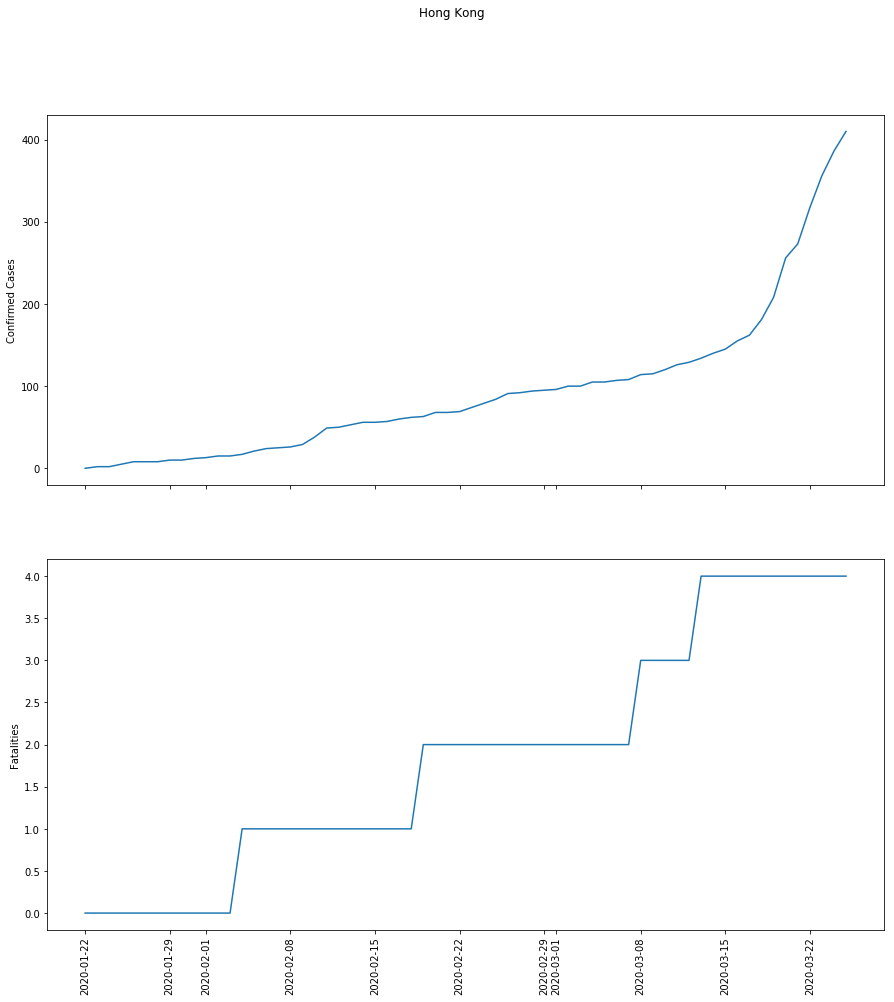

In [141]:
hk = train[train['Province_State']=='Hong Kong']
f, axarr = plt.subplots(2, sharex=True,figsize=(15,15))
f.suptitle('Hong Kong')
axarr[0].plot(hk['Date'], hk['ConfirmedCases'])
axarr[0].set(ylabel='Confirmed Cases')
axarr[1].plot(hk['Date'],hk['Fatalities'])
axarr[1].set(ylabel='Fatalities')
plt.xticks(rotation = 'vertical')
plt.show()


# Preprocessing for model

In [142]:
from sklearn import preprocessing
le1 = preprocessing.LabelEncoder()
le2 = preprocessing.LabelEncoder()

all_data['Country_Region_le'] = le1.fit_transform(all_data.Country_Region)
all_data['Province_State_le'] = le2.fit_transform(all_data.Province_State)

train = all_data[all_data['From']=='train']
val = all_data[all_data['From']=='val']

test['Country_Region_le'] = le1.fit_transform(test.Country_Region)
test['Province_State_le'] = le2.fit_transform(test.Province_State)

In [143]:
all_data.shape

(22644, 29)

In [144]:
x_train = train.drop(['Id', 'ConfirmedCases','Fatalities','Date','Province_State','Country_Region','From','location'], axis = 1)
y_train_1 = train["ConfirmedCases"]
y_train_2 = train["Fatalities"]
x_val = val.drop(['Id', 'ConfirmedCases','Fatalities','Date','Province_State','Country_Region','From','location'], axis = 1)
y_val_1 = val["ConfirmedCases"]
y_val_2 = val["Fatalities"]
x_train_no_age = x_train[['Day', 'Country_Region_le', 'Province_State_le']]
x_val_no_age = x_val[['Day', 'Country_Region_le', 'Province_State_le']]
                         
train.shape , val.shape,x_train_no_age.shape,x_val_no_age.shape

((19584, 29), (3060, 29), (19584, 3), (3060, 3))

In [145]:
x_train.columns

Index(['Day', '10 to 14', '15 to 19', '20 to 24', '25 to 29', '30 to 34', '35 to 39', '40 to 44', '45 to 49', '5 to 9', '50 to 54', '55 to 59', '60 to 64', '65 to 69', '70 to 74', '75 to 79', '80 plus', 'All Ages', 'Under 5', 'Country_Region_le', 'Province_State_le'], dtype='object')

# Light GBM

In [146]:
def evaluate(predict,actual):                                              
    return np.sqrt(np.mean(np.square(np.log(predict+1) - np.log(actual+1))))

In [147]:
#! pip install xgboost

In [148]:
import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

[1]	valid_0's rmse: 11677.5
[2]	valid_0's rmse: 11525.8
[3]	valid_0's rmse: 11398.2
[4]	valid_0's rmse: 11295.7
[5]	valid_0's rmse: 11206.8
[6]	valid_0's rmse: 11122.7
[7]	valid_0's rmse: 10950.7
[8]	valid_0's rmse: 10881.7
[9]	valid_0's rmse: 10821
[10]	valid_0's rmse: 10745.9
[11]	valid_0's rmse: 10626.7
[12]	valid_0's rmse: 10572.2
[13]	valid_0's rmse: 10474.2
[14]	valid_0's rmse: 10424
[15]	valid_0's rmse: 10326.8
[16]	valid_0's rmse: 10275.8
[17]	valid_0's rmse: 10226.5
[18]	valid_0's rmse: 10148.9
[19]	valid_0's rmse: 10106.7
[20]	valid_0's rmse: 10032.3
[21]	valid_0's rmse: 10005.1
[22]	valid_0's rmse: 9949.2
[23]	valid_0's rmse: 9909.92
[24]	valid_0's rmse: 9886.59
[25]	valid_0's rmse: 9828.01
[26]	valid_0's rmse: 9798.08
[27]	valid_0's rmse: 9782.4
[28]	valid_0's rmse: 9752.08
[29]	valid_0's rmse: 9698.43
[30]	valid_0's rmse: 9681.5
[31]	valid_0's rmse: 9621.14
[32]	valid_0's rmse: 9606.38
[33]	valid_0's rmse: 9561.69
[34]	valid_0's rmse: 9543.55
[35]	valid_0's rmse: 9501
[36]

[292]	valid_0's rmse: 6825.52
[293]	valid_0's rmse: 6824.6
[294]	valid_0's rmse: 6821.48
[295]	valid_0's rmse: 6818.05
[296]	valid_0's rmse: 6813.09
[297]	valid_0's rmse: 6811.3
[298]	valid_0's rmse: 6806.64
[299]	valid_0's rmse: 6802.41
[300]	valid_0's rmse: 6800.4
[301]	valid_0's rmse: 6795.26
[302]	valid_0's rmse: 6793.96
[303]	valid_0's rmse: 6791.96
[304]	valid_0's rmse: 6787.41
[305]	valid_0's rmse: 6784.61
[306]	valid_0's rmse: 6778.48
[307]	valid_0's rmse: 6776.71
[308]	valid_0's rmse: 6772.09
[309]	valid_0's rmse: 6767.29
[310]	valid_0's rmse: 6764.33
[311]	valid_0's rmse: 6760.41
[312]	valid_0's rmse: 6759.09
[313]	valid_0's rmse: 6757.78
[314]	valid_0's rmse: 6755.51
[315]	valid_0's rmse: 6754.39
[316]	valid_0's rmse: 6748.61
[317]	valid_0's rmse: 6744.68
[318]	valid_0's rmse: 6744.58
[319]	valid_0's rmse: 6741.95
[320]	valid_0's rmse: 6735.83
[321]	valid_0's rmse: 6729.79
[322]	valid_0's rmse: 6726.23
[323]	valid_0's rmse: 6721.71
[324]	valid_0's rmse: 6717.15
[325]	valid_0

[584]	valid_0's rmse: 6228.9
[585]	valid_0's rmse: 6227.32
[586]	valid_0's rmse: 6227.31
[587]	valid_0's rmse: 6226.55
[588]	valid_0's rmse: 6224.94
[589]	valid_0's rmse: 6223.78
[590]	valid_0's rmse: 6223.05
[591]	valid_0's rmse: 6222.16
[592]	valid_0's rmse: 6221.5
[593]	valid_0's rmse: 6221.37
[594]	valid_0's rmse: 6220.37
[595]	valid_0's rmse: 6219.83
[596]	valid_0's rmse: 6217.82
[597]	valid_0's rmse: 6217.7
[598]	valid_0's rmse: 6216.99
[599]	valid_0's rmse: 6214.48
[600]	valid_0's rmse: 6213.1
[601]	valid_0's rmse: 6213.08
[602]	valid_0's rmse: 6213.08
[603]	valid_0's rmse: 6212.49
[604]	valid_0's rmse: 6212.18
[605]	valid_0's rmse: 6211.94
[606]	valid_0's rmse: 6212.05
[607]	valid_0's rmse: 6211.6
[608]	valid_0's rmse: 6209.11
[609]	valid_0's rmse: 6208.6
[610]	valid_0's rmse: 6206.41
[611]	valid_0's rmse: 6205.83
[612]	valid_0's rmse: 6205.83
[613]	valid_0's rmse: 6205.05
[614]	valid_0's rmse: 6203.32
[615]	valid_0's rmse: 6202.57
[616]	valid_0's rmse: 6201.21
[617]	valid_0's 

[872]	valid_0's rmse: 6027.55
[873]	valid_0's rmse: 6026.73
[874]	valid_0's rmse: 6026.7
[875]	valid_0's rmse: 6026.15
[876]	valid_0's rmse: 6026.2
[877]	valid_0's rmse: 6025.36
[878]	valid_0's rmse: 6024.46
[879]	valid_0's rmse: 6023.86
[880]	valid_0's rmse: 6023.82
[881]	valid_0's rmse: 6023.59
[882]	valid_0's rmse: 6023.1
[883]	valid_0's rmse: 6022.29
[884]	valid_0's rmse: 6021.61
[885]	valid_0's rmse: 6020.79
[886]	valid_0's rmse: 6019.9
[887]	valid_0's rmse: 6019.9
[888]	valid_0's rmse: 6019.37
[889]	valid_0's rmse: 6019.33
[890]	valid_0's rmse: 6018.46
[891]	valid_0's rmse: 6017.67
[892]	valid_0's rmse: 6017.07
[893]	valid_0's rmse: 6016.97
[894]	valid_0's rmse: 6016.11
[895]	valid_0's rmse: 6015.71
[896]	valid_0's rmse: 6015.11
[897]	valid_0's rmse: 6014.95
[898]	valid_0's rmse: 6014.95
[899]	valid_0's rmse: 6014.9
[900]	valid_0's rmse: 6014.89
[901]	valid_0's rmse: 6014.79
[902]	valid_0's rmse: 6014.04
[903]	valid_0's rmse: 6013.83
[904]	valid_0's rmse: 6013.52
[905]	valid_0's 

[1154]	valid_0's rmse: 5929.35
[1155]	valid_0's rmse: 5928.77
[1156]	valid_0's rmse: 5928.92
[1157]	valid_0's rmse: 5929.13
[1158]	valid_0's rmse: 5928.77
[1159]	valid_0's rmse: 5928.67
[1160]	valid_0's rmse: 5928.09
[1161]	valid_0's rmse: 5927.83
[1162]	valid_0's rmse: 5927.7
[1163]	valid_0's rmse: 5926.23
[1164]	valid_0's rmse: 5925.96
[1165]	valid_0's rmse: 5925.97
[1166]	valid_0's rmse: 5926.39
[1167]	valid_0's rmse: 5926.39
[1168]	valid_0's rmse: 5926.79
[1169]	valid_0's rmse: 5926.67
[1170]	valid_0's rmse: 5926.1
[1171]	valid_0's rmse: 5926.04
[1172]	valid_0's rmse: 5926.49
[1173]	valid_0's rmse: 5926.15
[1174]	valid_0's rmse: 5926.3
[1175]	valid_0's rmse: 5925.61
[1176]	valid_0's rmse: 5925.19
[1177]	valid_0's rmse: 5925.14
[1178]	valid_0's rmse: 5924.58
[1179]	valid_0's rmse: 5924.16
[1180]	valid_0's rmse: 5923.66
[1181]	valid_0's rmse: 5922.6
[1182]	valid_0's rmse: 5922.25
[1183]	valid_0's rmse: 5921.97
[1184]	valid_0's rmse: 5921.99
[1185]	valid_0's rmse: 5921.66
[1186]	valid

[1447]	valid_0's rmse: 5851.33
[1448]	valid_0's rmse: 5850.73
[1449]	valid_0's rmse: 5849.9
[1450]	valid_0's rmse: 5849.24
[1451]	valid_0's rmse: 5849.01
[1452]	valid_0's rmse: 5848.87
[1453]	valid_0's rmse: 5848.78
[1454]	valid_0's rmse: 5848.53
[1455]	valid_0's rmse: 5847.55
[1456]	valid_0's rmse: 5847.47
[1457]	valid_0's rmse: 5847.13
[1458]	valid_0's rmse: 5847.12
[1459]	valid_0's rmse: 5846.94
[1460]	valid_0's rmse: 5846.49
[1461]	valid_0's rmse: 5846.47
[1462]	valid_0's rmse: 5846.48
[1463]	valid_0's rmse: 5846.45
[1464]	valid_0's rmse: 5846.42
[1465]	valid_0's rmse: 5845.95
[1466]	valid_0's rmse: 5845.95
[1467]	valid_0's rmse: 5845.82
[1468]	valid_0's rmse: 5845.59
[1469]	valid_0's rmse: 5845.53
[1470]	valid_0's rmse: 5845.18
[1471]	valid_0's rmse: 5845.18
[1472]	valid_0's rmse: 5845.18
[1473]	valid_0's rmse: 5844.89
[1474]	valid_0's rmse: 5844.88
[1475]	valid_0's rmse: 5844.88
[1476]	valid_0's rmse: 5844.89
[1477]	valid_0's rmse: 5844.66
[1478]	valid_0's rmse: 5844.25
[1479]	va

[1718]	valid_0's rmse: 5801.91
[1719]	valid_0's rmse: 5801.46
[1720]	valid_0's rmse: 5801.53
[1721]	valid_0's rmse: 5801.54
[1722]	valid_0's rmse: 5801.54
[1723]	valid_0's rmse: 5801.54
[1724]	valid_0's rmse: 5801.56
[1725]	valid_0's rmse: 5801.56
[1726]	valid_0's rmse: 5801.55
[1727]	valid_0's rmse: 5801.55
[1728]	valid_0's rmse: 5801.54
[1729]	valid_0's rmse: 5801.54
[1730]	valid_0's rmse: 5801.52
[1731]	valid_0's rmse: 5801.51
[1732]	valid_0's rmse: 5801.49
[1733]	valid_0's rmse: 5801.44
[1734]	valid_0's rmse: 5801.25
[1735]	valid_0's rmse: 5801.12
[1736]	valid_0's rmse: 5801.19
[1737]	valid_0's rmse: 5801.07
[1738]	valid_0's rmse: 5801.23
[1739]	valid_0's rmse: 5801.23
[1740]	valid_0's rmse: 5801.23
[1741]	valid_0's rmse: 5801.23
[1742]	valid_0's rmse: 5801.09
[1743]	valid_0's rmse: 5801.09
[1744]	valid_0's rmse: 5801.09
[1745]	valid_0's rmse: 5801.16
[1746]	valid_0's rmse: 5801.16
[1747]	valid_0's rmse: 5800.88
[1748]	valid_0's rmse: 5800.62
[1749]	valid_0's rmse: 5800.44
[1750]	v

[2002]	valid_0's rmse: 5771.01
[2003]	valid_0's rmse: 5771
[2004]	valid_0's rmse: 5770.95
[2005]	valid_0's rmse: 5770.84
[2006]	valid_0's rmse: 5771.08
[2007]	valid_0's rmse: 5770.81
[2008]	valid_0's rmse: 5771.04
[2009]	valid_0's rmse: 5771.03
[2010]	valid_0's rmse: 5771.03
[2011]	valid_0's rmse: 5770.79
[2012]	valid_0's rmse: 5770.71
[2013]	valid_0's rmse: 5770.56
[2014]	valid_0's rmse: 5770.54
[2015]	valid_0's rmse: 5770.42
[2016]	valid_0's rmse: 5770.3
[2017]	valid_0's rmse: 5770.2
[2018]	valid_0's rmse: 5769.89
[2019]	valid_0's rmse: 5769.89
[2020]	valid_0's rmse: 5769.77
[2021]	valid_0's rmse: 5769.74
[2022]	valid_0's rmse: 5769.72
[2023]	valid_0's rmse: 5769.72
[2024]	valid_0's rmse: 5769.63
[2025]	valid_0's rmse: 5769.77
[2026]	valid_0's rmse: 5769.75
[2027]	valid_0's rmse: 5769.75
[2028]	valid_0's rmse: 5769.75
[2029]	valid_0's rmse: 5769.78
[2030]	valid_0's rmse: 5769.75
[2031]	valid_0's rmse: 5769.65
[2032]	valid_0's rmse: 5769.65
[2033]	valid_0's rmse: 5769.71
[2034]	valid_

[2290]	valid_0's rmse: 5749.8
[2291]	valid_0's rmse: 5749.76
[2292]	valid_0's rmse: 5749.38
[2293]	valid_0's rmse: 5748.99
[2294]	valid_0's rmse: 5748.67
[2295]	valid_0's rmse: 5748.47
[2296]	valid_0's rmse: 5748.11
[2297]	valid_0's rmse: 5747.96
[2298]	valid_0's rmse: 5748.05
[2299]	valid_0's rmse: 5747.97
[2300]	valid_0's rmse: 5747.97
[2301]	valid_0's rmse: 5748.09
[2302]	valid_0's rmse: 5748
[2303]	valid_0's rmse: 5747.69
[2304]	valid_0's rmse: 5747.49
[2305]	valid_0's rmse: 5747.63
[2306]	valid_0's rmse: 5747.49
[2307]	valid_0's rmse: 5747.25
[2308]	valid_0's rmse: 5747.31
[2309]	valid_0's rmse: 5747.19
[2310]	valid_0's rmse: 5747.29
[2311]	valid_0's rmse: 5746.99
[2312]	valid_0's rmse: 5747
[2313]	valid_0's rmse: 5746.87
[2314]	valid_0's rmse: 5746.77
[2315]	valid_0's rmse: 5746.74
[2316]	valid_0's rmse: 5746.64
[2317]	valid_0's rmse: 5746.68
[2318]	valid_0's rmse: 5746.51
[2319]	valid_0's rmse: 5746.19
[2320]	valid_0's rmse: 5746.01
[2321]	valid_0's rmse: 5745.93
[2322]	valid_0'

[2564]	valid_0's rmse: 5731.2
[2565]	valid_0's rmse: 5731.22
[2566]	valid_0's rmse: 5731.21
[2567]	valid_0's rmse: 5731.22
[2568]	valid_0's rmse: 5731.2
[2569]	valid_0's rmse: 5731.2
[2570]	valid_0's rmse: 5731.19
[2571]	valid_0's rmse: 5730.97
[2572]	valid_0's rmse: 5730.61
[2573]	valid_0's rmse: 5730.51
[2574]	valid_0's rmse: 5730.45
[2575]	valid_0's rmse: 5730.23
[2576]	valid_0's rmse: 5729.76
[2577]	valid_0's rmse: 5729.72
[2578]	valid_0's rmse: 5729.57
[2579]	valid_0's rmse: 5729.41
[2580]	valid_0's rmse: 5729.41
[2581]	valid_0's rmse: 5729.32
[2582]	valid_0's rmse: 5729.27
[2583]	valid_0's rmse: 5728.96
[2584]	valid_0's rmse: 5728.93
[2585]	valid_0's rmse: 5728.93
[2586]	valid_0's rmse: 5728.93
[2587]	valid_0's rmse: 5729.14
[2588]	valid_0's rmse: 5728.83
[2589]	valid_0's rmse: 5728.81
[2590]	valid_0's rmse: 5729
[2591]	valid_0's rmse: 5728.71
[2592]	valid_0's rmse: 5728.25
[2593]	valid_0's rmse: 5727.99
[2594]	valid_0's rmse: 5727.83
[2595]	valid_0's rmse: 5727.72
[2596]	valid_0

[2863]	valid_0's rmse: 5711.17
[2864]	valid_0's rmse: 5711.13
[2865]	valid_0's rmse: 5711.12
[2866]	valid_0's rmse: 5711.25
[2867]	valid_0's rmse: 5711.26
[2868]	valid_0's rmse: 5711.26
[2869]	valid_0's rmse: 5711.25
[2870]	valid_0's rmse: 5711.02
[2871]	valid_0's rmse: 5710.95
[2872]	valid_0's rmse: 5710.86
[2873]	valid_0's rmse: 5710.7
[2874]	valid_0's rmse: 5710.55
[2875]	valid_0's rmse: 5710.44
[2876]	valid_0's rmse: 5710.58
[2877]	valid_0's rmse: 5710.58
[2878]	valid_0's rmse: 5710.57
[2879]	valid_0's rmse: 5710.69
[2880]	valid_0's rmse: 5710.66
[2881]	valid_0's rmse: 5710.64
[2882]	valid_0's rmse: 5710.58
[2883]	valid_0's rmse: 5710.7
[2884]	valid_0's rmse: 5710.66
[2885]	valid_0's rmse: 5710.61
[2886]	valid_0's rmse: 5710.51
[2887]	valid_0's rmse: 5710.5
[2888]	valid_0's rmse: 5710.5
[2889]	valid_0's rmse: 5710.46
[2890]	valid_0's rmse: 5710.54
[2891]	valid_0's rmse: 5710.58
[2892]	valid_0's rmse: 5710.58
[2893]	valid_0's rmse: 5710.65
[2894]	valid_0's rmse: 5710.51
[2895]	valid

[3128]	valid_0's rmse: 5699.97
[3129]	valid_0's rmse: 5699.88
[3130]	valid_0's rmse: 5699.63
[3131]	valid_0's rmse: 5699.33
[3132]	valid_0's rmse: 5699.34
[3133]	valid_0's rmse: 5699.23
[3134]	valid_0's rmse: 5699.19
[3135]	valid_0's rmse: 5699.16
[3136]	valid_0's rmse: 5699.17
[3137]	valid_0's rmse: 5699
[3138]	valid_0's rmse: 5698.74
[3139]	valid_0's rmse: 5698.7
[3140]	valid_0's rmse: 5698.51
[3141]	valid_0's rmse: 5698.52
[3142]	valid_0's rmse: 5698.5
[3143]	valid_0's rmse: 5698.37
[3144]	valid_0's rmse: 5698.37
[3145]	valid_0's rmse: 5698.37
[3146]	valid_0's rmse: 5698.33
[3147]	valid_0's rmse: 5698.46
[3148]	valid_0's rmse: 5698.41
[3149]	valid_0's rmse: 5698.43
[3150]	valid_0's rmse: 5698.31
[3151]	valid_0's rmse: 5698.31
[3152]	valid_0's rmse: 5698.35
[3153]	valid_0's rmse: 5698.34
[3154]	valid_0's rmse: 5698.3
[3155]	valid_0's rmse: 5698.17
[3156]	valid_0's rmse: 5698.06
[3157]	valid_0's rmse: 5698.05
[3158]	valid_0's rmse: 5698.05
[3159]	valid_0's rmse: 5698.05
[3160]	valid_0

[3396]	valid_0's rmse: 5690.88
[3397]	valid_0's rmse: 5690.6
[3398]	valid_0's rmse: 5690.48
[3399]	valid_0's rmse: 5690.48
[3400]	valid_0's rmse: 5690.42
[3401]	valid_0's rmse: 5690.35
[3402]	valid_0's rmse: 5690.41
[3403]	valid_0's rmse: 5690.2
[3404]	valid_0's rmse: 5690.24
[3405]	valid_0's rmse: 5690.1
[3406]	valid_0's rmse: 5690.03
[3407]	valid_0's rmse: 5690.02
[3408]	valid_0's rmse: 5690.1
[3409]	valid_0's rmse: 5690.13
[3410]	valid_0's rmse: 5690.13
[3411]	valid_0's rmse: 5690.12
[3412]	valid_0's rmse: 5690.11
[3413]	valid_0's rmse: 5690.11
[3414]	valid_0's rmse: 5690.05
[3415]	valid_0's rmse: 5690.09
[3416]	valid_0's rmse: 5690.09
[3417]	valid_0's rmse: 5690.16
[3418]	valid_0's rmse: 5690.12
[3419]	valid_0's rmse: 5690.01
[3420]	valid_0's rmse: 5690.06
[3421]	valid_0's rmse: 5690.06
[3422]	valid_0's rmse: 5690.01
[3423]	valid_0's rmse: 5689.96
[3424]	valid_0's rmse: 5689.96
[3425]	valid_0's rmse: 5689.92
[3426]	valid_0's rmse: 5689.89
[3427]	valid_0's rmse: 5689.92
[3428]	valid

[3673]	valid_0's rmse: 5683.02
[3674]	valid_0's rmse: 5683.03
[3675]	valid_0's rmse: 5683.04
[3676]	valid_0's rmse: 5683.04
[3677]	valid_0's rmse: 5683.04
[3678]	valid_0's rmse: 5683.05
[3679]	valid_0's rmse: 5683.06
[3680]	valid_0's rmse: 5683.06
[3681]	valid_0's rmse: 5683.05
[3682]	valid_0's rmse: 5683.05
[3683]	valid_0's rmse: 5683.05
[3684]	valid_0's rmse: 5683.09
[3685]	valid_0's rmse: 5683.01
[3686]	valid_0's rmse: 5683.01
[3687]	valid_0's rmse: 5682.86
[3688]	valid_0's rmse: 5682.72
[3689]	valid_0's rmse: 5682.65
[3690]	valid_0's rmse: 5682.66
[3691]	valid_0's rmse: 5682.65
[3692]	valid_0's rmse: 5682.65
[3693]	valid_0's rmse: 5682.68
[3694]	valid_0's rmse: 5682.68
[3695]	valid_0's rmse: 5682.7
[3696]	valid_0's rmse: 5682.63
[3697]	valid_0's rmse: 5682.63
[3698]	valid_0's rmse: 5682.65
[3699]	valid_0's rmse: 5682.65
[3700]	valid_0's rmse: 5682.65
[3701]	valid_0's rmse: 5682.52
[3702]	valid_0's rmse: 5682.52
[3703]	valid_0's rmse: 5682.52
[3704]	valid_0's rmse: 5682.52
[3705]	va

[3958]	valid_0's rmse: 5675.17
[3959]	valid_0's rmse: 5675.12
[3960]	valid_0's rmse: 5675.03
[3961]	valid_0's rmse: 5674.89
[3962]	valid_0's rmse: 5674.9
[3963]	valid_0's rmse: 5674.9
[3964]	valid_0's rmse: 5674.9
[3965]	valid_0's rmse: 5674.87
[3966]	valid_0's rmse: 5674.86
[3967]	valid_0's rmse: 5674.75
[3968]	valid_0's rmse: 5674.81
[3969]	valid_0's rmse: 5674.78
[3970]	valid_0's rmse: 5674.73
[3971]	valid_0's rmse: 5674.62
[3972]	valid_0's rmse: 5674.41
[3973]	valid_0's rmse: 5674.32
[3974]	valid_0's rmse: 5674.31
[3975]	valid_0's rmse: 5674.32
[3976]	valid_0's rmse: 5674.17
[3977]	valid_0's rmse: 5674.22
[3978]	valid_0's rmse: 5674.12
[3979]	valid_0's rmse: 5674.12
[3980]	valid_0's rmse: 5674.04
[3981]	valid_0's rmse: 5673.99
[3982]	valid_0's rmse: 5673.95
[3983]	valid_0's rmse: 5673.89
[3984]	valid_0's rmse: 5673.82
[3985]	valid_0's rmse: 5673.75
[3986]	valid_0's rmse: 5673.8
[3987]	valid_0's rmse: 5673.68
[3988]	valid_0's rmse: 5673.62
[3989]	valid_0's rmse: 5673.68
[3990]	valid

[4238]	valid_0's rmse: 5669.19
[4239]	valid_0's rmse: 5669.23
[4240]	valid_0's rmse: 5669.25
[4241]	valid_0's rmse: 5669.2
[4242]	valid_0's rmse: 5669.08
[4243]	valid_0's rmse: 5668.95
[4244]	valid_0's rmse: 5668.92
[4245]	valid_0's rmse: 5668.88
[4246]	valid_0's rmse: 5668.82
[4247]	valid_0's rmse: 5668.82
[4248]	valid_0's rmse: 5668.76
[4249]	valid_0's rmse: 5668.71
[4250]	valid_0's rmse: 5668.71
[4251]	valid_0's rmse: 5668.79
[4252]	valid_0's rmse: 5668.8
[4253]	valid_0's rmse: 5668.72
[4254]	valid_0's rmse: 5668.7
[4255]	valid_0's rmse: 5668.63
[4256]	valid_0's rmse: 5668.65
[4257]	valid_0's rmse: 5668.66
[4258]	valid_0's rmse: 5668.57
[4259]	valid_0's rmse: 5668.5
[4260]	valid_0's rmse: 5668.46
[4261]	valid_0's rmse: 5668.4
[4262]	valid_0's rmse: 5668.44
[4263]	valid_0's rmse: 5668.45
[4264]	valid_0's rmse: 5668.48
[4265]	valid_0's rmse: 5668.47
[4266]	valid_0's rmse: 5668.48
[4267]	valid_0's rmse: 5668.37
[4268]	valid_0's rmse: 5668.36
[4269]	valid_0's rmse: 5668.37
[4270]	valid_

[4521]	valid_0's rmse: 5663.96
[4522]	valid_0's rmse: 5663.99
[4523]	valid_0's rmse: 5663.93
[4524]	valid_0's rmse: 5663.94
[4525]	valid_0's rmse: 5663.91
[4526]	valid_0's rmse: 5663.81
[4527]	valid_0's rmse: 5663.86
[4528]	valid_0's rmse: 5663.83
[4529]	valid_0's rmse: 5663.92
[4530]	valid_0's rmse: 5663.92
[4531]	valid_0's rmse: 5663.84
[4532]	valid_0's rmse: 5663.87
[4533]	valid_0's rmse: 5663.9
[4534]	valid_0's rmse: 5663.94
[4535]	valid_0's rmse: 5664
[4536]	valid_0's rmse: 5663.99
[4537]	valid_0's rmse: 5664
[4538]	valid_0's rmse: 5664
[4539]	valid_0's rmse: 5663.97
[4540]	valid_0's rmse: 5663.93
[4541]	valid_0's rmse: 5663.95
[4542]	valid_0's rmse: 5663.91
[4543]	valid_0's rmse: 5663.83
[4544]	valid_0's rmse: 5663.75
[4545]	valid_0's rmse: 5663.74
[4546]	valid_0's rmse: 5663.74
[4547]	valid_0's rmse: 5663.73
[4548]	valid_0's rmse: 5663.73
[4549]	valid_0's rmse: 5663.63
[4550]	valid_0's rmse: 5663.66
[4551]	valid_0's rmse: 5663.66
[4552]	valid_0's rmse: 5663.66
[4553]	valid_0's r

[4826]	valid_0's rmse: 5658.82
[4827]	valid_0's rmse: 5658.86
[4828]	valid_0's rmse: 5658.96
[4829]	valid_0's rmse: 5658.89
[4830]	valid_0's rmse: 5658.92
[4831]	valid_0's rmse: 5658.99
[4832]	valid_0's rmse: 5658.88
[4833]	valid_0's rmse: 5658.89
[4834]	valid_0's rmse: 5658.78
[4835]	valid_0's rmse: 5658.78
[4836]	valid_0's rmse: 5658.78
[4837]	valid_0's rmse: 5658.78
[4838]	valid_0's rmse: 5658.78
[4839]	valid_0's rmse: 5658.78
[4840]	valid_0's rmse: 5658.78
[4841]	valid_0's rmse: 5658.78
[4842]	valid_0's rmse: 5658.7
[4843]	valid_0's rmse: 5658.74
[4844]	valid_0's rmse: 5658.72
[4845]	valid_0's rmse: 5658.69
[4846]	valid_0's rmse: 5658.69
[4847]	valid_0's rmse: 5658.61
[4848]	valid_0's rmse: 5658.62
[4849]	valid_0's rmse: 5658.6
[4850]	valid_0's rmse: 5658.61
[4851]	valid_0's rmse: 5658.6
[4852]	valid_0's rmse: 5658.6
[4853]	valid_0's rmse: 5658.59
[4854]	valid_0's rmse: 5658.56
[4855]	valid_0's rmse: 5658.55
[4856]	valid_0's rmse: 5658.55
[4857]	valid_0's rmse: 5658.51
[4858]	valid

[5112]	valid_0's rmse: 5655.28
[5113]	valid_0's rmse: 5655.28
[5114]	valid_0's rmse: 5655.29
[5115]	valid_0's rmse: 5655.31
[5116]	valid_0's rmse: 5655.36
[5117]	valid_0's rmse: 5655.34
[5118]	valid_0's rmse: 5655.35
[5119]	valid_0's rmse: 5655.35
[5120]	valid_0's rmse: 5655.35
[5121]	valid_0's rmse: 5655.31
[5122]	valid_0's rmse: 5655.31
[5123]	valid_0's rmse: 5655.31
[5124]	valid_0's rmse: 5655.25
[5125]	valid_0's rmse: 5655.23
[5126]	valid_0's rmse: 5655.27
[5127]	valid_0's rmse: 5655.27
[5128]	valid_0's rmse: 5655.27
[5129]	valid_0's rmse: 5655.27
[5130]	valid_0's rmse: 5655.23
[5131]	valid_0's rmse: 5655.27
[5132]	valid_0's rmse: 5655.3
[5133]	valid_0's rmse: 5655.17
[5134]	valid_0's rmse: 5655.17
[5135]	valid_0's rmse: 5655.15
[5136]	valid_0's rmse: 5655.11
[5137]	valid_0's rmse: 5655.04
[5138]	valid_0's rmse: 5654.99
[5139]	valid_0's rmse: 5654.99
[5140]	valid_0's rmse: 5654.94
[5141]	valid_0's rmse: 5654.94
[5142]	valid_0's rmse: 5654.97
[5143]	valid_0's rmse: 5654.96
[5144]	va

[5378]	valid_0's rmse: 5652.5
[5379]	valid_0's rmse: 5652.53
[5380]	valid_0's rmse: 5652.5
[5381]	valid_0's rmse: 5652.46
[5382]	valid_0's rmse: 5652.44
[5383]	valid_0's rmse: 5652.41
[5384]	valid_0's rmse: 5652.31
[5385]	valid_0's rmse: 5652.31
[5386]	valid_0's rmse: 5652.3
[5387]	valid_0's rmse: 5652.3
[5388]	valid_0's rmse: 5652.36
[5389]	valid_0's rmse: 5652.29
[5390]	valid_0's rmse: 5652.29
[5391]	valid_0's rmse: 5652.26
[5392]	valid_0's rmse: 5652.23
[5393]	valid_0's rmse: 5652.2
[5394]	valid_0's rmse: 5652.19
[5395]	valid_0's rmse: 5652.19
[5396]	valid_0's rmse: 5652.2
[5397]	valid_0's rmse: 5652.18
[5398]	valid_0's rmse: 5652.16
[5399]	valid_0's rmse: 5652.11
[5400]	valid_0's rmse: 5652.1
[5401]	valid_0's rmse: 5652.11
[5402]	valid_0's rmse: 5652.15
[5403]	valid_0's rmse: 5652.18
[5404]	valid_0's rmse: 5652.15
[5405]	valid_0's rmse: 5652.2
[5406]	valid_0's rmse: 5652.19
[5407]	valid_0's rmse: 5652.22
[5408]	valid_0's rmse: 5652.18
[5409]	valid_0's rmse: 5652.17
[5410]	valid_0's

[5676]	valid_0's rmse: 5649.67
[5677]	valid_0's rmse: 5649.66
[5678]	valid_0's rmse: 5649.6
[5679]	valid_0's rmse: 5649.54
[5680]	valid_0's rmse: 5649.57
[5681]	valid_0's rmse: 5649.62
[5682]	valid_0's rmse: 5649.57
[5683]	valid_0's rmse: 5649.57
[5684]	valid_0's rmse: 5649.58
[5685]	valid_0's rmse: 5649.6
[5686]	valid_0's rmse: 5649.6
[5687]	valid_0's rmse: 5649.64
[5688]	valid_0's rmse: 5649.64
[5689]	valid_0's rmse: 5649.64
[5690]	valid_0's rmse: 5649.64
[5691]	valid_0's rmse: 5649.66
[5692]	valid_0's rmse: 5649.65
[5693]	valid_0's rmse: 5649.65
[5694]	valid_0's rmse: 5649.65
[5695]	valid_0's rmse: 5649.62
[5696]	valid_0's rmse: 5649.64
[5697]	valid_0's rmse: 5649.6
[5698]	valid_0's rmse: 5649.64
[5699]	valid_0's rmse: 5649.63
[5700]	valid_0's rmse: 5649.65
[5701]	valid_0's rmse: 5649.63
[5702]	valid_0's rmse: 5649.59
[5703]	valid_0's rmse: 5649.56
[5704]	valid_0's rmse: 5649.62
[5705]	valid_0's rmse: 5649.61
[5706]	valid_0's rmse: 5649.54
[5707]	valid_0's rmse: 5649.51
[5708]	valid

[5951]	valid_0's rmse: 5647.63
[5952]	valid_0's rmse: 5647.62
[5953]	valid_0's rmse: 5647.62
[5954]	valid_0's rmse: 5647.66
[5955]	valid_0's rmse: 5647.62
[5956]	valid_0's rmse: 5647.62
[5957]	valid_0's rmse: 5647.61
[5958]	valid_0's rmse: 5647.62
[5959]	valid_0's rmse: 5647.58
[5960]	valid_0's rmse: 5647.54
[5961]	valid_0's rmse: 5647.54
[5962]	valid_0's rmse: 5647.56
[5963]	valid_0's rmse: 5647.52
[5964]	valid_0's rmse: 5647.55
[5965]	valid_0's rmse: 5647.57
[5966]	valid_0's rmse: 5647.53
[5967]	valid_0's rmse: 5647.52
[5968]	valid_0's rmse: 5647.5
[5969]	valid_0's rmse: 5647.46
[5970]	valid_0's rmse: 5647.42
[5971]	valid_0's rmse: 5647.39
[5972]	valid_0's rmse: 5647.4
[5973]	valid_0's rmse: 5647.36
[5974]	valid_0's rmse: 5647.35
[5975]	valid_0's rmse: 5647.34
[5976]	valid_0's rmse: 5647.36
[5977]	valid_0's rmse: 5647.41
[5978]	valid_0's rmse: 5647.44
[5979]	valid_0's rmse: 5647.47
[5980]	valid_0's rmse: 5647.43
[5981]	valid_0's rmse: 5647.4
[5982]	valid_0's rmse: 5647.44
[5983]	vali

[6224]	valid_0's rmse: 5645.55
[6225]	valid_0's rmse: 5645.58
[6226]	valid_0's rmse: 5645.61
[6227]	valid_0's rmse: 5645.68
[6228]	valid_0's rmse: 5645.73
[6229]	valid_0's rmse: 5645.72
[6230]	valid_0's rmse: 5645.72
[6231]	valid_0's rmse: 5645.72
[6232]	valid_0's rmse: 5645.69
[6233]	valid_0's rmse: 5645.68
[6234]	valid_0's rmse: 5645.68
[6235]	valid_0's rmse: 5645.68
[6236]	valid_0's rmse: 5645.69
[6237]	valid_0's rmse: 5645.68
[6238]	valid_0's rmse: 5645.76
[6239]	valid_0's rmse: 5645.78
[6240]	valid_0's rmse: 5645.73
[6241]	valid_0's rmse: 5645.77
[6242]	valid_0's rmse: 5645.77
[6243]	valid_0's rmse: 5645.81
[6244]	valid_0's rmse: 5645.83
[6245]	valid_0's rmse: 5645.83
[6246]	valid_0's rmse: 5645.87
[6247]	valid_0's rmse: 5645.87
[6248]	valid_0's rmse: 5645.76
[6249]	valid_0's rmse: 5645.75
[6250]	valid_0's rmse: 5645.76
[6251]	valid_0's rmse: 5645.76
[6252]	valid_0's rmse: 5645.71
[6253]	valid_0's rmse: 5645.67
[6254]	valid_0's rmse: 5645.66
[6255]	valid_0's rmse: 5645.66
[6256]	v

[6508]	valid_0's rmse: 5643.83
[6509]	valid_0's rmse: 5643.82
[6510]	valid_0's rmse: 5643.81
[6511]	valid_0's rmse: 5643.78
[6512]	valid_0's rmse: 5643.85
[6513]	valid_0's rmse: 5643.88
[6514]	valid_0's rmse: 5643.89
[6515]	valid_0's rmse: 5643.89
[6516]	valid_0's rmse: 5643.87
[6517]	valid_0's rmse: 5643.9
[6518]	valid_0's rmse: 5643.87
[6519]	valid_0's rmse: 5643.84
[6520]	valid_0's rmse: 5643.81
[6521]	valid_0's rmse: 5643.8
[6522]	valid_0's rmse: 5643.79
[6523]	valid_0's rmse: 5643.74
[6524]	valid_0's rmse: 5643.77
[6525]	valid_0's rmse: 5643.73
[6526]	valid_0's rmse: 5643.65
[6527]	valid_0's rmse: 5643.65
[6528]	valid_0's rmse: 5643.61
[6529]	valid_0's rmse: 5643.6
[6530]	valid_0's rmse: 5643.55
[6531]	valid_0's rmse: 5643.51
[6532]	valid_0's rmse: 5643.48
[6533]	valid_0's rmse: 5643.46
[6534]	valid_0's rmse: 5643.46
[6535]	valid_0's rmse: 5643.46
[6536]	valid_0's rmse: 5643.48
[6537]	valid_0's rmse: 5643.45
[6538]	valid_0's rmse: 5643.42
[6539]	valid_0's rmse: 5643.4
[6540]	valid

[6784]	valid_0's rmse: 5642.43
[6785]	valid_0's rmse: 5642.43
[6786]	valid_0's rmse: 5642.4
[6787]	valid_0's rmse: 5642.4
[6788]	valid_0's rmse: 5642.4
[6789]	valid_0's rmse: 5642.4
[6790]	valid_0's rmse: 5642.4
[6791]	valid_0's rmse: 5642.41
[6792]	valid_0's rmse: 5642.41
[6793]	valid_0's rmse: 5642.41
[6794]	valid_0's rmse: 5642.43
[6795]	valid_0's rmse: 5642.43
[6796]	valid_0's rmse: 5642.45
[6797]	valid_0's rmse: 5642.43
[6798]	valid_0's rmse: 5642.44
[6799]	valid_0's rmse: 5642.36
[6800]	valid_0's rmse: 5642.33
[6801]	valid_0's rmse: 5642.33
[6802]	valid_0's rmse: 5642.29
[6803]	valid_0's rmse: 5642.23
[6804]	valid_0's rmse: 5642.26
[6805]	valid_0's rmse: 5642.25
[6806]	valid_0's rmse: 5642.25
[6807]	valid_0's rmse: 5642.2
[6808]	valid_0's rmse: 5642.26
[6809]	valid_0's rmse: 5642.26
[6810]	valid_0's rmse: 5642.25
[6811]	valid_0's rmse: 5642.24
[6812]	valid_0's rmse: 5642.25
[6813]	valid_0's rmse: 5642.2
[6814]	valid_0's rmse: 5642.2
[6815]	valid_0's rmse: 5642.2
[6816]	valid_0's 

[7056]	valid_0's rmse: 5641.33
[7057]	valid_0's rmse: 5641.35
[7058]	valid_0's rmse: 5641.35
[7059]	valid_0's rmse: 5641.31
[7060]	valid_0's rmse: 5641.29
[7061]	valid_0's rmse: 5641.24
[7062]	valid_0's rmse: 5641.22
[7063]	valid_0's rmse: 5641.22
[7064]	valid_0's rmse: 5641.16
[7065]	valid_0's rmse: 5641.13
[7066]	valid_0's rmse: 5641.11
[7067]	valid_0's rmse: 5641.19
[7068]	valid_0's rmse: 5641.19
[7069]	valid_0's rmse: 5641.22
[7070]	valid_0's rmse: 5641.22
[7071]	valid_0's rmse: 5641.22
[7072]	valid_0's rmse: 5641.25
[7073]	valid_0's rmse: 5641.28
[7074]	valid_0's rmse: 5641.28
[7075]	valid_0's rmse: 5641.3
[7076]	valid_0's rmse: 5641.31
[7077]	valid_0's rmse: 5641.28
[7078]	valid_0's rmse: 5641.27
[7079]	valid_0's rmse: 5641.27
[7080]	valid_0's rmse: 5641.27
[7081]	valid_0's rmse: 5641.25
[7082]	valid_0's rmse: 5641.25
[7083]	valid_0's rmse: 5641.3
[7084]	valid_0's rmse: 5641.31
[7085]	valid_0's rmse: 5641.32
[7086]	valid_0's rmse: 5641.32
[7087]	valid_0's rmse: 5641.27
[7088]	val

[7349]	valid_0's rmse: 5639.14
[7350]	valid_0's rmse: 5639.17
[7351]	valid_0's rmse: 5639.12
[7352]	valid_0's rmse: 5639.11
[7353]	valid_0's rmse: 5639.13
[7354]	valid_0's rmse: 5639.12
[7355]	valid_0's rmse: 5639.1
[7356]	valid_0's rmse: 5639.11
[7357]	valid_0's rmse: 5639.14
[7358]	valid_0's rmse: 5639.15
[7359]	valid_0's rmse: 5639.14
[7360]	valid_0's rmse: 5639.12
[7361]	valid_0's rmse: 5639.09
[7362]	valid_0's rmse: 5639.09
[7363]	valid_0's rmse: 5639.08
[7364]	valid_0's rmse: 5639.04
[7365]	valid_0's rmse: 5639.05
[7366]	valid_0's rmse: 5639.06
[7367]	valid_0's rmse: 5639.03
[7368]	valid_0's rmse: 5639.03
[7369]	valid_0's rmse: 5639.03
[7370]	valid_0's rmse: 5639.02
[7371]	valid_0's rmse: 5638.95
[7372]	valid_0's rmse: 5638.94
[7373]	valid_0's rmse: 5638.93
[7374]	valid_0's rmse: 5638.93
[7375]	valid_0's rmse: 5638.93
[7376]	valid_0's rmse: 5638.95
[7377]	valid_0's rmse: 5638.97
[7378]	valid_0's rmse: 5638.98
[7379]	valid_0's rmse: 5639
[7380]	valid_0's rmse: 5639.02
[7381]	valid

[7614]	valid_0's rmse: 5637.88
[7615]	valid_0's rmse: 5637.85
[7616]	valid_0's rmse: 5637.85
[7617]	valid_0's rmse: 5637.84
[7618]	valid_0's rmse: 5637.84
[7619]	valid_0's rmse: 5637.83
[7620]	valid_0's rmse: 5637.83
[7621]	valid_0's rmse: 5637.83
[7622]	valid_0's rmse: 5637.83
[7623]	valid_0's rmse: 5637.79
[7624]	valid_0's rmse: 5637.8
[7625]	valid_0's rmse: 5637.79
[7626]	valid_0's rmse: 5637.78
[7627]	valid_0's rmse: 5637.76
[7628]	valid_0's rmse: 5637.7
[7629]	valid_0's rmse: 5637.71
[7630]	valid_0's rmse: 5637.73
[7631]	valid_0's rmse: 5637.72
[7632]	valid_0's rmse: 5637.7
[7633]	valid_0's rmse: 5637.66
[7634]	valid_0's rmse: 5637.63
[7635]	valid_0's rmse: 5637.63
[7636]	valid_0's rmse: 5637.61
[7637]	valid_0's rmse: 5637.59
[7638]	valid_0's rmse: 5637.58
[7639]	valid_0's rmse: 5637.59
[7640]	valid_0's rmse: 5637.59
[7641]	valid_0's rmse: 5637.58
[7642]	valid_0's rmse: 5637.54
[7643]	valid_0's rmse: 5637.51
[7644]	valid_0's rmse: 5637.51
[7645]	valid_0's rmse: 5637.48
[7646]	vali

[7898]	valid_0's rmse: 5636.37
[7899]	valid_0's rmse: 5636.38
[7900]	valid_0's rmse: 5636.38
[7901]	valid_0's rmse: 5636.38
[7902]	valid_0's rmse: 5636.41
[7903]	valid_0's rmse: 5636.44
[7904]	valid_0's rmse: 5636.44
[7905]	valid_0's rmse: 5636.41
[7906]	valid_0's rmse: 5636.41
[7907]	valid_0's rmse: 5636.43
[7908]	valid_0's rmse: 5636.43
[7909]	valid_0's rmse: 5636.43
[7910]	valid_0's rmse: 5636.39
[7911]	valid_0's rmse: 5636.36
[7912]	valid_0's rmse: 5636.38
[7913]	valid_0's rmse: 5636.37
[7914]	valid_0's rmse: 5636.37
[7915]	valid_0's rmse: 5636.34
[7916]	valid_0's rmse: 5636.37
[7917]	valid_0's rmse: 5636.36
[7918]	valid_0's rmse: 5636.34
[7919]	valid_0's rmse: 5636.31
[7920]	valid_0's rmse: 5636.31
[7921]	valid_0's rmse: 5636.29
[7922]	valid_0's rmse: 5636.29
[7923]	valid_0's rmse: 5636.26
[7924]	valid_0's rmse: 5636.28
[7925]	valid_0's rmse: 5636.27
[7926]	valid_0's rmse: 5636.23
[7927]	valid_0's rmse: 5636.23
[7928]	valid_0's rmse: 5636.23
[7929]	valid_0's rmse: 5636.24
[7930]	v

[8164]	valid_0's rmse: 5635.45
[8165]	valid_0's rmse: 5635.42
[8166]	valid_0's rmse: 5635.43
[8167]	valid_0's rmse: 5635.41
[8168]	valid_0's rmse: 5635.42
[8169]	valid_0's rmse: 5635.43
[8170]	valid_0's rmse: 5635.41
[8171]	valid_0's rmse: 5635.42
[8172]	valid_0's rmse: 5635.39
[8173]	valid_0's rmse: 5635.4
[8174]	valid_0's rmse: 5635.41
[8175]	valid_0's rmse: 5635.37
[8176]	valid_0's rmse: 5635.38
[8177]	valid_0's rmse: 5635.41
[8178]	valid_0's rmse: 5635.41
[8179]	valid_0's rmse: 5635.38
[8180]	valid_0's rmse: 5635.36
[8181]	valid_0's rmse: 5635.36
[8182]	valid_0's rmse: 5635.34
[8183]	valid_0's rmse: 5635.36
[8184]	valid_0's rmse: 5635.36
[8185]	valid_0's rmse: 5635.37
[8186]	valid_0's rmse: 5635.37
[8187]	valid_0's rmse: 5635.37
[8188]	valid_0's rmse: 5635.37
[8189]	valid_0's rmse: 5635.34
[8190]	valid_0's rmse: 5635.35
[8191]	valid_0's rmse: 5635.33
[8192]	valid_0's rmse: 5635.3
[8193]	valid_0's rmse: 5635.3
[8194]	valid_0's rmse: 5635.31
[8195]	valid_0's rmse: 5635.33
[8196]	vali

[8459]	valid_0's rmse: 5634.68
[8460]	valid_0's rmse: 5634.63
[8461]	valid_0's rmse: 5634.66
[8462]	valid_0's rmse: 5634.65
[8463]	valid_0's rmse: 5634.66
[8464]	valid_0's rmse: 5634.65
[8465]	valid_0's rmse: 5634.65
[8466]	valid_0's rmse: 5634.66
[8467]	valid_0's rmse: 5634.66
[8468]	valid_0's rmse: 5634.65
[8469]	valid_0's rmse: 5634.64
[8470]	valid_0's rmse: 5634.66
[8471]	valid_0's rmse: 5634.66
[8472]	valid_0's rmse: 5634.65
[8473]	valid_0's rmse: 5634.66
[8474]	valid_0's rmse: 5634.65
[8475]	valid_0's rmse: 5634.65
[8476]	valid_0's rmse: 5634.67
[8477]	valid_0's rmse: 5634.64
[8478]	valid_0's rmse: 5634.68
[8479]	valid_0's rmse: 5634.65
[8480]	valid_0's rmse: 5634.63
[8481]	valid_0's rmse: 5634.66
[8482]	valid_0's rmse: 5634.67
[8483]	valid_0's rmse: 5634.7
[8484]	valid_0's rmse: 5634.7
[8485]	valid_0's rmse: 5634.68
[8486]	valid_0's rmse: 5634.67
[8487]	valid_0's rmse: 5634.69
[8488]	valid_0's rmse: 5634.7
[8489]	valid_0's rmse: 5634.69
[8490]	valid_0's rmse: 5634.65
[8491]	vali

[8743]	valid_0's rmse: 5633.6
[8744]	valid_0's rmse: 5633.6
[8745]	valid_0's rmse: 5633.59
[8746]	valid_0's rmse: 5633.61
[8747]	valid_0's rmse: 5633.6
[8748]	valid_0's rmse: 5633.6
[8749]	valid_0's rmse: 5633.59
[8750]	valid_0's rmse: 5633.62
[8751]	valid_0's rmse: 5633.6
[8752]	valid_0's rmse: 5633.59
[8753]	valid_0's rmse: 5633.59
[8754]	valid_0's rmse: 5633.59
[8755]	valid_0's rmse: 5633.61
[8756]	valid_0's rmse: 5633.61
[8757]	valid_0's rmse: 5633.61
[8758]	valid_0's rmse: 5633.6
[8759]	valid_0's rmse: 5633.58
[8760]	valid_0's rmse: 5633.61
[8761]	valid_0's rmse: 5633.62
[8762]	valid_0's rmse: 5633.62
[8763]	valid_0's rmse: 5633.65
[8764]	valid_0's rmse: 5633.68
[8765]	valid_0's rmse: 5633.68
[8766]	valid_0's rmse: 5633.73
[8767]	valid_0's rmse: 5633.74
[8768]	valid_0's rmse: 5633.75
[8769]	valid_0's rmse: 5633.73
[8770]	valid_0's rmse: 5633.71
[8771]	valid_0's rmse: 5633.73
[8772]	valid_0's rmse: 5633.7
[8773]	valid_0's rmse: 5633.7
[8774]	valid_0's rmse: 5633.69
[8775]	valid_0's

[9014]	valid_0's rmse: 5632.63
[9015]	valid_0's rmse: 5632.64
[9016]	valid_0's rmse: 5632.64
[9017]	valid_0's rmse: 5632.6
[9018]	valid_0's rmse: 5632.56
[9019]	valid_0's rmse: 5632.56
[9020]	valid_0's rmse: 5632.56
[9021]	valid_0's rmse: 5632.54
[9022]	valid_0's rmse: 5632.53
[9023]	valid_0's rmse: 5632.53
[9024]	valid_0's rmse: 5632.5
[9025]	valid_0's rmse: 5632.5
[9026]	valid_0's rmse: 5632.51
[9027]	valid_0's rmse: 5632.53
[9028]	valid_0's rmse: 5632.52
[9029]	valid_0's rmse: 5632.5
[9030]	valid_0's rmse: 5632.49
[9031]	valid_0's rmse: 5632.48
[9032]	valid_0's rmse: 5632.48
[9033]	valid_0's rmse: 5632.48
[9034]	valid_0's rmse: 5632.47
[9035]	valid_0's rmse: 5632.48
[9036]	valid_0's rmse: 5632.46
[9037]	valid_0's rmse: 5632.48
[9038]	valid_0's rmse: 5632.46
[9039]	valid_0's rmse: 5632.48
[9040]	valid_0's rmse: 5632.47
[9041]	valid_0's rmse: 5632.47
[9042]	valid_0's rmse: 5632.49
[9043]	valid_0's rmse: 5632.48
[9044]	valid_0's rmse: 5632.49
[9045]	valid_0's rmse: 5632.49
[9046]	valid

[9282]	valid_0's rmse: 5631.75
[9283]	valid_0's rmse: 5631.75
[9284]	valid_0's rmse: 5631.75
[9285]	valid_0's rmse: 5631.75
[9286]	valid_0's rmse: 5631.75
[9287]	valid_0's rmse: 5631.7
[9288]	valid_0's rmse: 5631.69
[9289]	valid_0's rmse: 5631.64
[9290]	valid_0's rmse: 5631.63
[9291]	valid_0's rmse: 5631.63
[9292]	valid_0's rmse: 5631.64
[9293]	valid_0's rmse: 5631.6
[9294]	valid_0's rmse: 5631.57
[9295]	valid_0's rmse: 5631.63
[9296]	valid_0's rmse: 5631.6
[9297]	valid_0's rmse: 5631.6
[9298]	valid_0's rmse: 5631.64
[9299]	valid_0's rmse: 5631.66
[9300]	valid_0's rmse: 5631.67
[9301]	valid_0's rmse: 5631.68
[9302]	valid_0's rmse: 5631.64
[9303]	valid_0's rmse: 5631.64
[9304]	valid_0's rmse: 5631.64
[9305]	valid_0's rmse: 5631.64
[9306]	valid_0's rmse: 5631.62
[9307]	valid_0's rmse: 5631.59
[9308]	valid_0's rmse: 5631.6
[9309]	valid_0's rmse: 5631.58
[9310]	valid_0's rmse: 5631.57
[9311]	valid_0's rmse: 5631.57
[9312]	valid_0's rmse: 5631.57
[9313]	valid_0's rmse: 5631.57
[9314]	valid_

[9581]	valid_0's rmse: 5630.66
[9582]	valid_0's rmse: 5630.67
[9583]	valid_0's rmse: 5630.67
[9584]	valid_0's rmse: 5630.66
[9585]	valid_0's rmse: 5630.63
[9586]	valid_0's rmse: 5630.64
[9587]	valid_0's rmse: 5630.63
[9588]	valid_0's rmse: 5630.63
[9589]	valid_0's rmse: 5630.65
[9590]	valid_0's rmse: 5630.67
[9591]	valid_0's rmse: 5630.65
[9592]	valid_0's rmse: 5630.65
[9593]	valid_0's rmse: 5630.65
[9594]	valid_0's rmse: 5630.62
[9595]	valid_0's rmse: 5630.63
[9596]	valid_0's rmse: 5630.67
[9597]	valid_0's rmse: 5630.64
[9598]	valid_0's rmse: 5630.61
[9599]	valid_0's rmse: 5630.61
[9600]	valid_0's rmse: 5630.62
[9601]	valid_0's rmse: 5630.64
[9602]	valid_0's rmse: 5630.64
[9603]	valid_0's rmse: 5630.65
[9604]	valid_0's rmse: 5630.63
[9605]	valid_0's rmse: 5630.6
[9606]	valid_0's rmse: 5630.58
[9607]	valid_0's rmse: 5630.58
[9608]	valid_0's rmse: 5630.56
[9609]	valid_0's rmse: 5630.55
[9610]	valid_0's rmse: 5630.54
[9611]	valid_0's rmse: 5630.54
[9612]	valid_0's rmse: 5630.55
[9613]	va

[9877]	valid_0's rmse: 5629.92
[9878]	valid_0's rmse: 5629.89
[9879]	valid_0's rmse: 5629.88
[9880]	valid_0's rmse: 5629.88
[9881]	valid_0's rmse: 5629.88
[9882]	valid_0's rmse: 5629.88
[9883]	valid_0's rmse: 5629.88
[9884]	valid_0's rmse: 5629.88
[9885]	valid_0's rmse: 5629.85
[9886]	valid_0's rmse: 5629.85
[9887]	valid_0's rmse: 5629.85
[9888]	valid_0's rmse: 5629.86
[9889]	valid_0's rmse: 5629.86
[9890]	valid_0's rmse: 5629.88
[9891]	valid_0's rmse: 5629.88
[9892]	valid_0's rmse: 5629.88
[9893]	valid_0's rmse: 5629.86
[9894]	valid_0's rmse: 5629.85
[9895]	valid_0's rmse: 5629.88
[9896]	valid_0's rmse: 5629.88
[9897]	valid_0's rmse: 5629.89
[9898]	valid_0's rmse: 5629.91
[9899]	valid_0's rmse: 5629.89
[9900]	valid_0's rmse: 5629.88
[9901]	valid_0's rmse: 5629.88
[9902]	valid_0's rmse: 5629.88
[9903]	valid_0's rmse: 5629.88
[9904]	valid_0's rmse: 5629.87
[9905]	valid_0's rmse: 5629.84
[9906]	valid_0's rmse: 5629.83
[9907]	valid_0's rmse: 5629.84
[9908]	valid_0's rmse: 5629.84
[9909]	v

[155]	valid_0's rmse: 633.193
[156]	valid_0's rmse: 632.677
[157]	valid_0's rmse: 632.254
[158]	valid_0's rmse: 631.509
[159]	valid_0's rmse: 630.331
[160]	valid_0's rmse: 629.54
[161]	valid_0's rmse: 628.703
[162]	valid_0's rmse: 627.903
[163]	valid_0's rmse: 626.85
[164]	valid_0's rmse: 626.391
[165]	valid_0's rmse: 625.985
[166]	valid_0's rmse: 625.59
[167]	valid_0's rmse: 625.196
[168]	valid_0's rmse: 624.509
[169]	valid_0's rmse: 623.28
[170]	valid_0's rmse: 622.528
[171]	valid_0's rmse: 622.127
[172]	valid_0's rmse: 621.024
[173]	valid_0's rmse: 620.013
[174]	valid_0's rmse: 619.467
[175]	valid_0's rmse: 618.515
[176]	valid_0's rmse: 617.541
[177]	valid_0's rmse: 617.161
[178]	valid_0's rmse: 616.542
[179]	valid_0's rmse: 615.862
[180]	valid_0's rmse: 615.491
[181]	valid_0's rmse: 614.386
[182]	valid_0's rmse: 613.445
[183]	valid_0's rmse: 612.925
[184]	valid_0's rmse: 612.194
[185]	valid_0's rmse: 611.155
[186]	valid_0's rmse: 610.731
[187]	valid_0's rmse: 609.79
[188]	valid_0's

[432]	valid_0's rmse: 533.77
[433]	valid_0's rmse: 533.757
[434]	valid_0's rmse: 533.612
[435]	valid_0's rmse: 533.391
[436]	valid_0's rmse: 533.235
[437]	valid_0's rmse: 532.951
[438]	valid_0's rmse: 532.805
[439]	valid_0's rmse: 532.539
[440]	valid_0's rmse: 532.361
[441]	valid_0's rmse: 532.344
[442]	valid_0's rmse: 532.111
[443]	valid_0's rmse: 531.957
[444]	valid_0's rmse: 531.806
[445]	valid_0's rmse: 531.537
[446]	valid_0's rmse: 531.477
[447]	valid_0's rmse: 531.365
[448]	valid_0's rmse: 531.233
[449]	valid_0's rmse: 531.097
[450]	valid_0's rmse: 530.81
[451]	valid_0's rmse: 530.619
[452]	valid_0's rmse: 530.581
[453]	valid_0's rmse: 530.545
[454]	valid_0's rmse: 530.304
[455]	valid_0's rmse: 530.162
[456]	valid_0's rmse: 530.014
[457]	valid_0's rmse: 529.882
[458]	valid_0's rmse: 529.813
[459]	valid_0's rmse: 529.78
[460]	valid_0's rmse: 529.555
[461]	valid_0's rmse: 529.37
[462]	valid_0's rmse: 529.28
[463]	valid_0's rmse: 529.163
[464]	valid_0's rmse: 529.117
[465]	valid_0's

[734]	valid_0's rmse: 502.645
[735]	valid_0's rmse: 502.555
[736]	valid_0's rmse: 502.541
[737]	valid_0's rmse: 502.51
[738]	valid_0's rmse: 502.455
[739]	valid_0's rmse: 502.379
[740]	valid_0's rmse: 502.364
[741]	valid_0's rmse: 502.263
[742]	valid_0's rmse: 502.285
[743]	valid_0's rmse: 502.237
[744]	valid_0's rmse: 502.145
[745]	valid_0's rmse: 502.076
[746]	valid_0's rmse: 502.098
[747]	valid_0's rmse: 502.079
[748]	valid_0's rmse: 502.013
[749]	valid_0's rmse: 501.937
[750]	valid_0's rmse: 501.924
[751]	valid_0's rmse: 501.906
[752]	valid_0's rmse: 501.836
[753]	valid_0's rmse: 501.756
[754]	valid_0's rmse: 501.693
[755]	valid_0's rmse: 501.65
[756]	valid_0's rmse: 501.596
[757]	valid_0's rmse: 501.566
[758]	valid_0's rmse: 501.466
[759]	valid_0's rmse: 501.385
[760]	valid_0's rmse: 501.32
[761]	valid_0's rmse: 501.304
[762]	valid_0's rmse: 501.244
[763]	valid_0's rmse: 501.161
[764]	valid_0's rmse: 501.065
[765]	valid_0's rmse: 501.017
[766]	valid_0's rmse: 501.008
[767]	valid_0

[1046]	valid_0's rmse: 494.501
[1047]	valid_0's rmse: 494.468
[1048]	valid_0's rmse: 494.45
[1049]	valid_0's rmse: 494.441
[1050]	valid_0's rmse: 494.412
[1051]	valid_0's rmse: 494.367
[1052]	valid_0's rmse: 494.323
[1053]	valid_0's rmse: 494.29
[1054]	valid_0's rmse: 494.256
[1055]	valid_0's rmse: 494.211
[1056]	valid_0's rmse: 494.179
[1057]	valid_0's rmse: 494.127
[1058]	valid_0's rmse: 494.114
[1059]	valid_0's rmse: 494.08
[1060]	valid_0's rmse: 494.039
[1061]	valid_0's rmse: 494.007
[1062]	valid_0's rmse: 493.964
[1063]	valid_0's rmse: 493.953
[1064]	valid_0's rmse: 493.913
[1065]	valid_0's rmse: 493.916
[1066]	valid_0's rmse: 493.918
[1067]	valid_0's rmse: 493.918
[1068]	valid_0's rmse: 493.92
[1069]	valid_0's rmse: 493.907
[1070]	valid_0's rmse: 493.895
[1071]	valid_0's rmse: 493.863
[1072]	valid_0's rmse: 493.836
[1073]	valid_0's rmse: 493.825
[1074]	valid_0's rmse: 493.792
[1075]	valid_0's rmse: 493.744
[1076]	valid_0's rmse: 493.682
[1077]	valid_0's rmse: 493.663
[1078]	valid

[1346]	valid_0's rmse: 488.899
[1347]	valid_0's rmse: 488.879
[1348]	valid_0's rmse: 488.883
[1349]	valid_0's rmse: 488.879
[1350]	valid_0's rmse: 488.872
[1351]	valid_0's rmse: 488.859
[1352]	valid_0's rmse: 488.861
[1353]	valid_0's rmse: 488.862
[1354]	valid_0's rmse: 488.852
[1355]	valid_0's rmse: 488.848
[1356]	valid_0's rmse: 488.831
[1357]	valid_0's rmse: 488.814
[1358]	valid_0's rmse: 488.815
[1359]	valid_0's rmse: 488.815
[1360]	valid_0's rmse: 488.783
[1361]	valid_0's rmse: 488.766
[1362]	valid_0's rmse: 488.783
[1363]	valid_0's rmse: 488.79
[1364]	valid_0's rmse: 488.787
[1365]	valid_0's rmse: 488.787
[1366]	valid_0's rmse: 488.752
[1367]	valid_0's rmse: 488.752
[1368]	valid_0's rmse: 488.75
[1369]	valid_0's rmse: 488.733
[1370]	valid_0's rmse: 488.729
[1371]	valid_0's rmse: 488.76
[1372]	valid_0's rmse: 488.746
[1373]	valid_0's rmse: 488.768
[1374]	valid_0's rmse: 488.757
[1375]	valid_0's rmse: 488.757
[1376]	valid_0's rmse: 488.753
[1377]	valid_0's rmse: 488.764
[1378]	vali

[1638]	valid_0's rmse: 486.905
[1639]	valid_0's rmse: 486.904
[1640]	valid_0's rmse: 486.899
[1641]	valid_0's rmse: 486.902
[1642]	valid_0's rmse: 486.899
[1643]	valid_0's rmse: 486.901
[1644]	valid_0's rmse: 486.892
[1645]	valid_0's rmse: 486.886
[1646]	valid_0's rmse: 486.885
[1647]	valid_0's rmse: 486.853
[1648]	valid_0's rmse: 486.853
[1649]	valid_0's rmse: 486.847
[1650]	valid_0's rmse: 486.824
[1651]	valid_0's rmse: 486.823
[1652]	valid_0's rmse: 486.808
[1653]	valid_0's rmse: 486.823
[1654]	valid_0's rmse: 486.827
[1655]	valid_0's rmse: 486.803
[1656]	valid_0's rmse: 486.78
[1657]	valid_0's rmse: 486.748
[1658]	valid_0's rmse: 486.752
[1659]	valid_0's rmse: 486.731
[1660]	valid_0's rmse: 486.718
[1661]	valid_0's rmse: 486.715
[1662]	valid_0's rmse: 486.701
[1663]	valid_0's rmse: 486.708
[1664]	valid_0's rmse: 486.714
[1665]	valid_0's rmse: 486.702
[1666]	valid_0's rmse: 486.692
[1667]	valid_0's rmse: 486.69
[1668]	valid_0's rmse: 486.682
[1669]	valid_0's rmse: 486.686
[1670]	val

[1908]	valid_0's rmse: 485.529
[1909]	valid_0's rmse: 485.519
[1910]	valid_0's rmse: 485.524
[1911]	valid_0's rmse: 485.516
[1912]	valid_0's rmse: 485.503
[1913]	valid_0's rmse: 485.484
[1914]	valid_0's rmse: 485.487
[1915]	valid_0's rmse: 485.476
[1916]	valid_0's rmse: 485.46
[1917]	valid_0's rmse: 485.446
[1918]	valid_0's rmse: 485.447
[1919]	valid_0's rmse: 485.445
[1920]	valid_0's rmse: 485.439
[1921]	valid_0's rmse: 485.43
[1922]	valid_0's rmse: 485.437
[1923]	valid_0's rmse: 485.437
[1924]	valid_0's rmse: 485.437
[1925]	valid_0's rmse: 485.438
[1926]	valid_0's rmse: 485.431
[1927]	valid_0's rmse: 485.431
[1928]	valid_0's rmse: 485.434
[1929]	valid_0's rmse: 485.434
[1930]	valid_0's rmse: 485.431
[1931]	valid_0's rmse: 485.42
[1932]	valid_0's rmse: 485.409
[1933]	valid_0's rmse: 485.399
[1934]	valid_0's rmse: 485.389
[1935]	valid_0's rmse: 485.397
[1936]	valid_0's rmse: 485.404
[1937]	valid_0's rmse: 485.418
[1938]	valid_0's rmse: 485.423
[1939]	valid_0's rmse: 485.429
[1940]	vali

[2183]	valid_0's rmse: 484.298
[2184]	valid_0's rmse: 484.287
[2185]	valid_0's rmse: 484.301
[2186]	valid_0's rmse: 484.312
[2187]	valid_0's rmse: 484.304
[2188]	valid_0's rmse: 484.295
[2189]	valid_0's rmse: 484.283
[2190]	valid_0's rmse: 484.29
[2191]	valid_0's rmse: 484.294
[2192]	valid_0's rmse: 484.294
[2193]	valid_0's rmse: 484.302
[2194]	valid_0's rmse: 484.3
[2195]	valid_0's rmse: 484.309
[2196]	valid_0's rmse: 484.314
[2197]	valid_0's rmse: 484.316
[2198]	valid_0's rmse: 484.313
[2199]	valid_0's rmse: 484.297
[2200]	valid_0's rmse: 484.29
[2201]	valid_0's rmse: 484.276
[2202]	valid_0's rmse: 484.273
[2203]	valid_0's rmse: 484.251
[2204]	valid_0's rmse: 484.246
[2205]	valid_0's rmse: 484.246
[2206]	valid_0's rmse: 484.247
[2207]	valid_0's rmse: 484.233
[2208]	valid_0's rmse: 484.241
[2209]	valid_0's rmse: 484.253
[2210]	valid_0's rmse: 484.238
[2211]	valid_0's rmse: 484.244
[2212]	valid_0's rmse: 484.238
[2213]	valid_0's rmse: 484.234
[2214]	valid_0's rmse: 484.214
[2215]	valid

[2454]	valid_0's rmse: 483.658
[2455]	valid_0's rmse: 483.657
[2456]	valid_0's rmse: 483.657
[2457]	valid_0's rmse: 483.657
[2458]	valid_0's rmse: 483.658
[2459]	valid_0's rmse: 483.658
[2460]	valid_0's rmse: 483.655
[2461]	valid_0's rmse: 483.655
[2462]	valid_0's rmse: 483.654
[2463]	valid_0's rmse: 483.655
[2464]	valid_0's rmse: 483.657
[2465]	valid_0's rmse: 483.649
[2466]	valid_0's rmse: 483.638
[2467]	valid_0's rmse: 483.644
[2468]	valid_0's rmse: 483.636
[2469]	valid_0's rmse: 483.634
[2470]	valid_0's rmse: 483.626
[2471]	valid_0's rmse: 483.617
[2472]	valid_0's rmse: 483.622
[2473]	valid_0's rmse: 483.622
[2474]	valid_0's rmse: 483.628
[2475]	valid_0's rmse: 483.619
[2476]	valid_0's rmse: 483.611
[2477]	valid_0's rmse: 483.602
[2478]	valid_0's rmse: 483.594
[2479]	valid_0's rmse: 483.588
[2480]	valid_0's rmse: 483.58
[2481]	valid_0's rmse: 483.58
[2482]	valid_0's rmse: 483.574
[2483]	valid_0's rmse: 483.574
[2484]	valid_0's rmse: 483.579
[2485]	valid_0's rmse: 483.578
[2486]	val

[2733]	valid_0's rmse: 483.075
[2734]	valid_0's rmse: 483.072
[2735]	valid_0's rmse: 483.073
[2736]	valid_0's rmse: 483.073
[2737]	valid_0's rmse: 483.073
[2738]	valid_0's rmse: 483.073
[2739]	valid_0's rmse: 483.073
[2740]	valid_0's rmse: 483.073
[2741]	valid_0's rmse: 483.073
[2742]	valid_0's rmse: 483.068
[2743]	valid_0's rmse: 483.065
[2744]	valid_0's rmse: 483.06
[2745]	valid_0's rmse: 483.052
[2746]	valid_0's rmse: 483.047
[2747]	valid_0's rmse: 483.043
[2748]	valid_0's rmse: 483.038
[2749]	valid_0's rmse: 483.034
[2750]	valid_0's rmse: 483.024
[2751]	valid_0's rmse: 483.019
[2752]	valid_0's rmse: 483.015
[2753]	valid_0's rmse: 483.015
[2754]	valid_0's rmse: 483.017
[2755]	valid_0's rmse: 483.007
[2756]	valid_0's rmse: 483.013
[2757]	valid_0's rmse: 483.01
[2758]	valid_0's rmse: 483.008
[2759]	valid_0's rmse: 483.01
[2760]	valid_0's rmse: 482.999
[2761]	valid_0's rmse: 482.988
[2762]	valid_0's rmse: 482.992
[2763]	valid_0's rmse: 482.99
[2764]	valid_0's rmse: 482.988
[2765]	valid

[3052]	valid_0's rmse: 482.462
[3053]	valid_0's rmse: 482.456
[3054]	valid_0's rmse: 482.451
[3055]	valid_0's rmse: 482.447
[3056]	valid_0's rmse: 482.44
[3057]	valid_0's rmse: 482.44
[3058]	valid_0's rmse: 482.438
[3059]	valid_0's rmse: 482.435
[3060]	valid_0's rmse: 482.438
[3061]	valid_0's rmse: 482.434
[3062]	valid_0's rmse: 482.436
[3063]	valid_0's rmse: 482.437
[3064]	valid_0's rmse: 482.439
[3065]	valid_0's rmse: 482.448
[3066]	valid_0's rmse: 482.44
[3067]	valid_0's rmse: 482.443
[3068]	valid_0's rmse: 482.443
[3069]	valid_0's rmse: 482.438
[3070]	valid_0's rmse: 482.435
[3071]	valid_0's rmse: 482.444
[3072]	valid_0's rmse: 482.438
[3073]	valid_0's rmse: 482.437
[3074]	valid_0's rmse: 482.437
[3075]	valid_0's rmse: 482.437
[3076]	valid_0's rmse: 482.437
[3077]	valid_0's rmse: 482.445
[3078]	valid_0's rmse: 482.438
[3079]	valid_0's rmse: 482.443
[3080]	valid_0's rmse: 482.437
[3081]	valid_0's rmse: 482.434
[3082]	valid_0's rmse: 482.43
[3083]	valid_0's rmse: 482.434
[3084]	valid

[3335]	valid_0's rmse: 482.17
[3336]	valid_0's rmse: 482.165
[3337]	valid_0's rmse: 482.165
[3338]	valid_0's rmse: 482.161
[3339]	valid_0's rmse: 482.164
[3340]	valid_0's rmse: 482.165
[3341]	valid_0's rmse: 482.169
[3342]	valid_0's rmse: 482.165
[3343]	valid_0's rmse: 482.161
[3344]	valid_0's rmse: 482.164
[3345]	valid_0's rmse: 482.177
[3346]	valid_0's rmse: 482.167
[3347]	valid_0's rmse: 482.164
[3348]	valid_0's rmse: 482.172
[3349]	valid_0's rmse: 482.176
[3350]	valid_0's rmse: 482.17
[3351]	valid_0's rmse: 482.163
[3352]	valid_0's rmse: 482.168
[3353]	valid_0's rmse: 482.167
[3354]	valid_0's rmse: 482.169
[3355]	valid_0's rmse: 482.166
[3356]	valid_0's rmse: 482.175
[3357]	valid_0's rmse: 482.176
[3358]	valid_0's rmse: 482.179
[3359]	valid_0's rmse: 482.173
[3360]	valid_0's rmse: 482.167
[3361]	valid_0's rmse: 482.162
[3362]	valid_0's rmse: 482.155
[3363]	valid_0's rmse: 482.153
[3364]	valid_0's rmse: 482.166
[3365]	valid_0's rmse: 482.159
[3366]	valid_0's rmse: 482.169
[3367]	val

[3605]	valid_0's rmse: 481.899
[3606]	valid_0's rmse: 481.9
[3607]	valid_0's rmse: 481.901
[3608]	valid_0's rmse: 481.901
[3609]	valid_0's rmse: 481.903
[3610]	valid_0's rmse: 481.902
[3611]	valid_0's rmse: 481.902
[3612]	valid_0's rmse: 481.898
[3613]	valid_0's rmse: 481.895
[3614]	valid_0's rmse: 481.898
[3615]	valid_0's rmse: 481.896
[3616]	valid_0's rmse: 481.893
[3617]	valid_0's rmse: 481.888
[3618]	valid_0's rmse: 481.889
[3619]	valid_0's rmse: 481.888
[3620]	valid_0's rmse: 481.886
[3621]	valid_0's rmse: 481.882
[3622]	valid_0's rmse: 481.88
[3623]	valid_0's rmse: 481.884
[3624]	valid_0's rmse: 481.883
[3625]	valid_0's rmse: 481.886
[3626]	valid_0's rmse: 481.882
[3627]	valid_0's rmse: 481.879
[3628]	valid_0's rmse: 481.879
[3629]	valid_0's rmse: 481.866
[3630]	valid_0's rmse: 481.862
[3631]	valid_0's rmse: 481.857
[3632]	valid_0's rmse: 481.857
[3633]	valid_0's rmse: 481.86
[3634]	valid_0's rmse: 481.856
[3635]	valid_0's rmse: 481.853
[3636]	valid_0's rmse: 481.856
[3637]	valid

[3885]	valid_0's rmse: 481.604
[3886]	valid_0's rmse: 481.607
[3887]	valid_0's rmse: 481.615
[3888]	valid_0's rmse: 481.618
[3889]	valid_0's rmse: 481.62
[3890]	valid_0's rmse: 481.625
[3891]	valid_0's rmse: 481.631
[3892]	valid_0's rmse: 481.636
[3893]	valid_0's rmse: 481.64
[3894]	valid_0's rmse: 481.634
[3895]	valid_0's rmse: 481.634
[3896]	valid_0's rmse: 481.634
[3897]	valid_0's rmse: 481.636
[3898]	valid_0's rmse: 481.628
[3899]	valid_0's rmse: 481.635
[3900]	valid_0's rmse: 481.629
[3901]	valid_0's rmse: 481.632
[3902]	valid_0's rmse: 481.638
[3903]	valid_0's rmse: 481.639
[3904]	valid_0's rmse: 481.638
[3905]	valid_0's rmse: 481.641
[3906]	valid_0's rmse: 481.641
[3907]	valid_0's rmse: 481.643
[3908]	valid_0's rmse: 481.637
[3909]	valid_0's rmse: 481.631
[3910]	valid_0's rmse: 481.633
[3911]	valid_0's rmse: 481.631
[3912]	valid_0's rmse: 481.635
[3913]	valid_0's rmse: 481.643
[3914]	valid_0's rmse: 481.638
[3915]	valid_0's rmse: 481.638
[3916]	valid_0's rmse: 481.634
[3917]	val

[4178]	valid_0's rmse: 481.357
[4179]	valid_0's rmse: 481.354
[4180]	valid_0's rmse: 481.348
[4181]	valid_0's rmse: 481.348
[4182]	valid_0's rmse: 481.344
[4183]	valid_0's rmse: 481.339
[4184]	valid_0's rmse: 481.335
[4185]	valid_0's rmse: 481.333
[4186]	valid_0's rmse: 481.339
[4187]	valid_0's rmse: 481.332
[4188]	valid_0's rmse: 481.328
[4189]	valid_0's rmse: 481.326
[4190]	valid_0's rmse: 481.333
[4191]	valid_0's rmse: 481.335
[4192]	valid_0's rmse: 481.339
[4193]	valid_0's rmse: 481.338
[4194]	valid_0's rmse: 481.345
[4195]	valid_0's rmse: 481.342
[4196]	valid_0's rmse: 481.335
[4197]	valid_0's rmse: 481.337
[4198]	valid_0's rmse: 481.337
[4199]	valid_0's rmse: 481.338
[4200]	valid_0's rmse: 481.336
[4201]	valid_0's rmse: 481.331
[4202]	valid_0's rmse: 481.328
[4203]	valid_0's rmse: 481.328
[4204]	valid_0's rmse: 481.328
[4205]	valid_0's rmse: 481.325
[4206]	valid_0's rmse: 481.322
[4207]	valid_0's rmse: 481.321
[4208]	valid_0's rmse: 481.321
[4209]	valid_0's rmse: 481.32
[4210]	va

[4446]	valid_0's rmse: 481.103
[4447]	valid_0's rmse: 481.104
[4448]	valid_0's rmse: 481.106
[4449]	valid_0's rmse: 481.107
[4450]	valid_0's rmse: 481.11
[4451]	valid_0's rmse: 481.112
[4452]	valid_0's rmse: 481.114
[4453]	valid_0's rmse: 481.115
[4454]	valid_0's rmse: 481.114
[4455]	valid_0's rmse: 481.111
[4456]	valid_0's rmse: 481.112
[4457]	valid_0's rmse: 481.109
[4458]	valid_0's rmse: 481.109
[4459]	valid_0's rmse: 481.109
[4460]	valid_0's rmse: 481.109
[4461]	valid_0's rmse: 481.108
[4462]	valid_0's rmse: 481.108
[4463]	valid_0's rmse: 481.106
[4464]	valid_0's rmse: 481.107
[4465]	valid_0's rmse: 481.109
[4466]	valid_0's rmse: 481.106
[4467]	valid_0's rmse: 481.106
[4468]	valid_0's rmse: 481.108
[4469]	valid_0's rmse: 481.108
[4470]	valid_0's rmse: 481.108
[4471]	valid_0's rmse: 481.105
[4472]	valid_0's rmse: 481.105
[4473]	valid_0's rmse: 481.103
[4474]	valid_0's rmse: 481.106
[4475]	valid_0's rmse: 481.109
[4476]	valid_0's rmse: 481.112
[4477]	valid_0's rmse: 481.109
[4478]	va

[4718]	valid_0's rmse: 480.984
[4719]	valid_0's rmse: 480.988
[4720]	valid_0's rmse: 480.987
[4721]	valid_0's rmse: 480.986
[4722]	valid_0's rmse: 480.984
[4723]	valid_0's rmse: 480.989
[4724]	valid_0's rmse: 480.985
[4725]	valid_0's rmse: 480.981
[4726]	valid_0's rmse: 480.988
[4727]	valid_0's rmse: 480.995
[4728]	valid_0's rmse: 480.99
[4729]	valid_0's rmse: 480.987
[4730]	valid_0's rmse: 480.985
[4731]	valid_0's rmse: 480.985
[4732]	valid_0's rmse: 480.991
[4733]	valid_0's rmse: 480.986
[4734]	valid_0's rmse: 480.984
[4735]	valid_0's rmse: 480.989
[4736]	valid_0's rmse: 480.984
[4737]	valid_0's rmse: 480.989
[4738]	valid_0's rmse: 480.989
[4739]	valid_0's rmse: 480.989
[4740]	valid_0's rmse: 480.986
[4741]	valid_0's rmse: 480.986
[4742]	valid_0's rmse: 480.986
[4743]	valid_0's rmse: 480.987
[4744]	valid_0's rmse: 480.987
[4745]	valid_0's rmse: 480.986
[4746]	valid_0's rmse: 480.987
[4747]	valid_0's rmse: 480.987
[4748]	valid_0's rmse: 480.987
[4749]	valid_0's rmse: 480.983
[4750]	va

Light GBM
Case Error: 0.9626982848063755 
Fatalties Error: 3.444590202440861 
Average Error: 2.2036442436236183
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


C:\Users\tsofo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning:

invalid value encountered in log



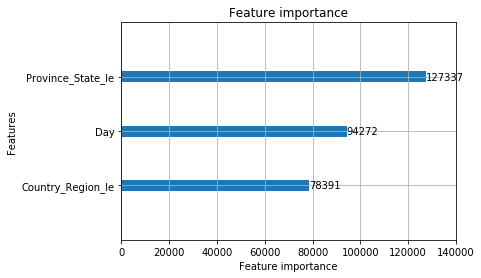

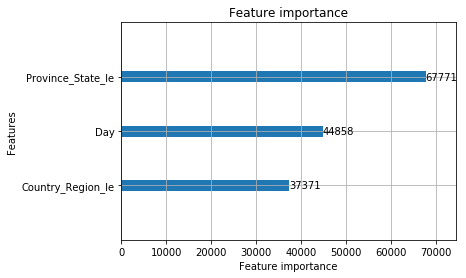

In [149]:
lgb_params = {
   'objective': 'regression',
    'metric': 'rmse',
}
lgb_train_1 = lgb.Dataset(x_train_no_age, y_train_1)
lgb_eval_1 = lgb.Dataset(x_val_no_age, y_val_1, reference=lgb_train_1)

lgb_model_1 = lgb.train(lgb_params,lgb_train_1, valid_sets=lgb_eval_1,num_boost_round=10000)
y_pred_1_lgb = lgb_model_1.predict(x_val_no_age, num_iteration = lgb_model_1.best_iteration)

lgb_train_2 = lgb.Dataset(x_train_no_age, y_train_2)
lgb_eval_2 = lgb.Dataset(x_val_no_age, y_val_2, reference=lgb_train_2)

lgb_model_2 = lgb.train(lgb_params,lgb_train_2, valid_sets=lgb_eval_2,num_boost_round=5000)
y_pred_2_lgb = lgb_model_1.predict(x_val_no_age, num_iteration = lgb_model_2.best_iteration)


print('Light GBM')
print('Case Error:',evaluate(y_pred_1_lgb,y_val_1),'\nFatalties Error:', evaluate(y_pred_2_lgb,y_val_2),'\nAverage Error:',(evaluate(y_pred_1_lgb,y_val_1)+evaluate(y_pred_2_lgb,y_val_2))/2)
print(lgb.plot_importance(lgb_model_1))
print(lgb.plot_importance(lgb_model_2))

[1]	valid_0's rmse: 11394.6
[2]	valid_0's rmse: 10991.8
[3]	valid_0's rmse: 10712.9
[4]	valid_0's rmse: 10450.9
[5]	valid_0's rmse: 10134.4
[6]	valid_0's rmse: 9851.31
[7]	valid_0's rmse: 9609.12
[8]	valid_0's rmse: 9420.16
[9]	valid_0's rmse: 9197.12
[10]	valid_0's rmse: 9059.8
[11]	valid_0's rmse: 8939.53
[12]	valid_0's rmse: 8769.1
[13]	valid_0's rmse: 8677.61
[14]	valid_0's rmse: 8576.03
[15]	valid_0's rmse: 8498.66
[16]	valid_0's rmse: 8435.56
[17]	valid_0's rmse: 8376.52
[18]	valid_0's rmse: 8287.91
[19]	valid_0's rmse: 8225.96
[20]	valid_0's rmse: 8167.97
[21]	valid_0's rmse: 8099.16
[22]	valid_0's rmse: 8045.1
[23]	valid_0's rmse: 7962.98
[24]	valid_0's rmse: 7914.58
[25]	valid_0's rmse: 7870.71
[26]	valid_0's rmse: 7793.94
[27]	valid_0's rmse: 7764.69
[28]	valid_0's rmse: 7713.96
[29]	valid_0's rmse: 7685.33
[30]	valid_0's rmse: 7656.6
[31]	valid_0's rmse: 7616.27
[32]	valid_0's rmse: 7594.75
[33]	valid_0's rmse: 7566.51
[34]	valid_0's rmse: 7542.44
[35]	valid_0's rmse: 7477.5

[282]	valid_0's rmse: 5938.07
[283]	valid_0's rmse: 5937.54
[284]	valid_0's rmse: 5937.3
[285]	valid_0's rmse: 5935.32
[286]	valid_0's rmse: 5934.76
[287]	valid_0's rmse: 5934.02
[288]	valid_0's rmse: 5932.8
[289]	valid_0's rmse: 5932.57
[290]	valid_0's rmse: 5932.41
[291]	valid_0's rmse: 5932.98
[292]	valid_0's rmse: 5930.13
[293]	valid_0's rmse: 5930.01
[294]	valid_0's rmse: 5926.93
[295]	valid_0's rmse: 5926.69
[296]	valid_0's rmse: 5926.97
[297]	valid_0's rmse: 5925.43
[298]	valid_0's rmse: 5923.1
[299]	valid_0's rmse: 5921.96
[300]	valid_0's rmse: 5921.43
[301]	valid_0's rmse: 5921.3
[302]	valid_0's rmse: 5920.51
[303]	valid_0's rmse: 5917.98
[304]	valid_0's rmse: 5915.73
[305]	valid_0's rmse: 5910.71
[306]	valid_0's rmse: 5909.11
[307]	valid_0's rmse: 5907.66
[308]	valid_0's rmse: 5906.59
[309]	valid_0's rmse: 5905.85
[310]	valid_0's rmse: 5904.9
[311]	valid_0's rmse: 5900.95
[312]	valid_0's rmse: 5899.62
[313]	valid_0's rmse: 5899
[314]	valid_0's rmse: 5896.11
[315]	valid_0's rm

[567]	valid_0's rmse: 5706.79
[568]	valid_0's rmse: 5707.06
[569]	valid_0's rmse: 5707.19
[570]	valid_0's rmse: 5707.15
[571]	valid_0's rmse: 5707.12
[572]	valid_0's rmse: 5705.55
[573]	valid_0's rmse: 5705.66
[574]	valid_0's rmse: 5705.91
[575]	valid_0's rmse: 5706.03
[576]	valid_0's rmse: 5705.99
[577]	valid_0's rmse: 5705.73
[578]	valid_0's rmse: 5704.87
[579]	valid_0's rmse: 5704.13
[580]	valid_0's rmse: 5704.01
[581]	valid_0's rmse: 5703.7
[582]	valid_0's rmse: 5703.04
[583]	valid_0's rmse: 5702.83
[584]	valid_0's rmse: 5702.87
[585]	valid_0's rmse: 5702.84
[586]	valid_0's rmse: 5702.85
[587]	valid_0's rmse: 5702.1
[588]	valid_0's rmse: 5701.73
[589]	valid_0's rmse: 5701.92
[590]	valid_0's rmse: 5702.02
[591]	valid_0's rmse: 5702.02
[592]	valid_0's rmse: 5701.58
[593]	valid_0's rmse: 5700.59
[594]	valid_0's rmse: 5700.93
[595]	valid_0's rmse: 5700.55
[596]	valid_0's rmse: 5700.79
[597]	valid_0's rmse: 5700.79
[598]	valid_0's rmse: 5700.96
[599]	valid_0's rmse: 5701.04
[600]	valid_

[842]	valid_0's rmse: 5658.93
[843]	valid_0's rmse: 5659.36
[844]	valid_0's rmse: 5659.39
[845]	valid_0's rmse: 5659.38
[846]	valid_0's rmse: 5659.73
[847]	valid_0's rmse: 5659.03
[848]	valid_0's rmse: 5658.3
[849]	valid_0's rmse: 5658.75
[850]	valid_0's rmse: 5658.01
[851]	valid_0's rmse: 5657.25
[852]	valid_0's rmse: 5656.91
[853]	valid_0's rmse: 5656.37
[854]	valid_0's rmse: 5656.42
[855]	valid_0's rmse: 5656.47
[856]	valid_0's rmse: 5656.29
[857]	valid_0's rmse: 5656.06
[858]	valid_0's rmse: 5655.91
[859]	valid_0's rmse: 5656.15
[860]	valid_0's rmse: 5656.26
[861]	valid_0's rmse: 5656.23
[862]	valid_0's rmse: 5656.23
[863]	valid_0's rmse: 5656.23
[864]	valid_0's rmse: 5656.35
[865]	valid_0's rmse: 5655.86
[866]	valid_0's rmse: 5656.02
[867]	valid_0's rmse: 5656.14
[868]	valid_0's rmse: 5655.85
[869]	valid_0's rmse: 5656.04
[870]	valid_0's rmse: 5656.03
[871]	valid_0's rmse: 5655.32
[872]	valid_0's rmse: 5655.5
[873]	valid_0's rmse: 5655.1
[874]	valid_0's rmse: 5655.07
[875]	valid_0

[1125]	valid_0's rmse: 5638.06
[1126]	valid_0's rmse: 5638.06
[1127]	valid_0's rmse: 5637.96
[1128]	valid_0's rmse: 5637.74
[1129]	valid_0's rmse: 5637.64
[1130]	valid_0's rmse: 5637.86
[1131]	valid_0's rmse: 5637.64
[1132]	valid_0's rmse: 5637.3
[1133]	valid_0's rmse: 5637.32
[1134]	valid_0's rmse: 5637.34
[1135]	valid_0's rmse: 5637.33
[1136]	valid_0's rmse: 5637.33
[1137]	valid_0's rmse: 5636.88
[1138]	valid_0's rmse: 5636.97
[1139]	valid_0's rmse: 5636.56
[1140]	valid_0's rmse: 5636.86
[1141]	valid_0's rmse: 5637.36
[1142]	valid_0's rmse: 5637.01
[1143]	valid_0's rmse: 5636.73
[1144]	valid_0's rmse: 5636.73
[1145]	valid_0's rmse: 5636.73
[1146]	valid_0's rmse: 5636.69
[1147]	valid_0's rmse: 5636.34
[1148]	valid_0's rmse: 5636.23
[1149]	valid_0's rmse: 5636.32
[1150]	valid_0's rmse: 5636.33
[1151]	valid_0's rmse: 5636.32
[1152]	valid_0's rmse: 5635.92
[1153]	valid_0's rmse: 5636.2
[1154]	valid_0's rmse: 5636.31
[1155]	valid_0's rmse: 5636.27
[1156]	valid_0's rmse: 5636.27
[1157]	val

[1404]	valid_0's rmse: 5630.34
[1405]	valid_0's rmse: 5630.18
[1406]	valid_0's rmse: 5630.03
[1407]	valid_0's rmse: 5630.32
[1408]	valid_0's rmse: 5630.13
[1409]	valid_0's rmse: 5629.91
[1410]	valid_0's rmse: 5630.05
[1411]	valid_0's rmse: 5629.86
[1412]	valid_0's rmse: 5629.86
[1413]	valid_0's rmse: 5629.86
[1414]	valid_0's rmse: 5629.84
[1415]	valid_0's rmse: 5629.84
[1416]	valid_0's rmse: 5629.85
[1417]	valid_0's rmse: 5629.99
[1418]	valid_0's rmse: 5629.95
[1419]	valid_0's rmse: 5629.95
[1420]	valid_0's rmse: 5629.94
[1421]	valid_0's rmse: 5629.89
[1422]	valid_0's rmse: 5629.9
[1423]	valid_0's rmse: 5629.7
[1424]	valid_0's rmse: 5629.61
[1425]	valid_0's rmse: 5629.87
[1426]	valid_0's rmse: 5629.67
[1427]	valid_0's rmse: 5629.67
[1428]	valid_0's rmse: 5629.44
[1429]	valid_0's rmse: 5629.5
[1430]	valid_0's rmse: 5629.51
[1431]	valid_0's rmse: 5629.54
[1432]	valid_0's rmse: 5629.53
[1433]	valid_0's rmse: 5629.57
[1434]	valid_0's rmse: 5629.57
[1435]	valid_0's rmse: 5629.71
[1436]	vali

[1673]	valid_0's rmse: 5628.33
[1674]	valid_0's rmse: 5628.27
[1675]	valid_0's rmse: 5628.27
[1676]	valid_0's rmse: 5628.27
[1677]	valid_0's rmse: 5628.27
[1678]	valid_0's rmse: 5628.15
[1679]	valid_0's rmse: 5628.14
[1680]	valid_0's rmse: 5628.23
[1681]	valid_0's rmse: 5628.23
[1682]	valid_0's rmse: 5628.23
[1683]	valid_0's rmse: 5628.4
[1684]	valid_0's rmse: 5628.39
[1685]	valid_0's rmse: 5628.5
[1686]	valid_0's rmse: 5628.5
[1687]	valid_0's rmse: 5628.51
[1688]	valid_0's rmse: 5628.49
[1689]	valid_0's rmse: 5628.36
[1690]	valid_0's rmse: 5628.37
[1691]	valid_0's rmse: 5628.21
[1692]	valid_0's rmse: 5628.29
[1693]	valid_0's rmse: 5628.21
[1694]	valid_0's rmse: 5628.12
[1695]	valid_0's rmse: 5628.14
[1696]	valid_0's rmse: 5627.83
[1697]	valid_0's rmse: 5627.88
[1698]	valid_0's rmse: 5627.84
[1699]	valid_0's rmse: 5627.84
[1700]	valid_0's rmse: 5627.84
[1701]	valid_0's rmse: 5627.96
[1702]	valid_0's rmse: 5627.96
[1703]	valid_0's rmse: 5628
[1704]	valid_0's rmse: 5627.95
[1705]	valid_0

[1947]	valid_0's rmse: 5625.83
[1948]	valid_0's rmse: 5625.54
[1949]	valid_0's rmse: 5625.25
[1950]	valid_0's rmse: 5625.3
[1951]	valid_0's rmse: 5625.08
[1952]	valid_0's rmse: 5624.85
[1953]	valid_0's rmse: 5624.87
[1954]	valid_0's rmse: 5624.85
[1955]	valid_0's rmse: 5624.85
[1956]	valid_0's rmse: 5624.64
[1957]	valid_0's rmse: 5624.68
[1958]	valid_0's rmse: 5624.34
[1959]	valid_0's rmse: 5624.34
[1960]	valid_0's rmse: 5624.34
[1961]	valid_0's rmse: 5624.22
[1962]	valid_0's rmse: 5624.47
[1963]	valid_0's rmse: 5624.47
[1964]	valid_0's rmse: 5624.51
[1965]	valid_0's rmse: 5624.55
[1966]	valid_0's rmse: 5624.55
[1967]	valid_0's rmse: 5624.55
[1968]	valid_0's rmse: 5624.55
[1969]	valid_0's rmse: 5624.5
[1970]	valid_0's rmse: 5624.45
[1971]	valid_0's rmse: 5624.39
[1972]	valid_0's rmse: 5624.36
[1973]	valid_0's rmse: 5624.52
[1974]	valid_0's rmse: 5624.6
[1975]	valid_0's rmse: 5624.6
[1976]	valid_0's rmse: 5624.59
[1977]	valid_0's rmse: 5624.73
[1978]	valid_0's rmse: 5624.51
[1979]	valid

[2219]	valid_0's rmse: 5622.8
[2220]	valid_0's rmse: 5622.82
[2221]	valid_0's rmse: 5622.85
[2222]	valid_0's rmse: 5622.82
[2223]	valid_0's rmse: 5622.8
[2224]	valid_0's rmse: 5622.76
[2225]	valid_0's rmse: 5622.68
[2226]	valid_0's rmse: 5622.71
[2227]	valid_0's rmse: 5622.77
[2228]	valid_0's rmse: 5622.79
[2229]	valid_0's rmse: 5622.6
[2230]	valid_0's rmse: 5622.49
[2231]	valid_0's rmse: 5622.36
[2232]	valid_0's rmse: 5622.23
[2233]	valid_0's rmse: 5622.12
[2234]	valid_0's rmse: 5622.1
[2235]	valid_0's rmse: 5622.13
[2236]	valid_0's rmse: 5622.09
[2237]	valid_0's rmse: 5622.08
[2238]	valid_0's rmse: 5622.11
[2239]	valid_0's rmse: 5622.08
[2240]	valid_0's rmse: 5622.24
[2241]	valid_0's rmse: 5622.23
[2242]	valid_0's rmse: 5622.14
[2243]	valid_0's rmse: 5622.22
[2244]	valid_0's rmse: 5622.15
[2245]	valid_0's rmse: 5622.04
[2246]	valid_0's rmse: 5621.96
[2247]	valid_0's rmse: 5622.1
[2248]	valid_0's rmse: 5622.07
[2249]	valid_0's rmse: 5622.09
[2250]	valid_0's rmse: 5622.03
[2251]	valid_

[2501]	valid_0's rmse: 5620.71
[2502]	valid_0's rmse: 5620.71
[2503]	valid_0's rmse: 5620.71
[2504]	valid_0's rmse: 5620.71
[2505]	valid_0's rmse: 5620.71
[2506]	valid_0's rmse: 5620.71
[2507]	valid_0's rmse: 5620.71
[2508]	valid_0's rmse: 5620.71
[2509]	valid_0's rmse: 5620.71
[2510]	valid_0's rmse: 5620.71
[2511]	valid_0's rmse: 5620.61
[2512]	valid_0's rmse: 5620.61
[2513]	valid_0's rmse: 5620.6
[2514]	valid_0's rmse: 5620.6
[2515]	valid_0's rmse: 5620.58
[2516]	valid_0's rmse: 5620.58
[2517]	valid_0's rmse: 5620.58
[2518]	valid_0's rmse: 5620.56
[2519]	valid_0's rmse: 5620.56
[2520]	valid_0's rmse: 5620.59
[2521]	valid_0's rmse: 5620.59
[2522]	valid_0's rmse: 5620.59
[2523]	valid_0's rmse: 5620.59
[2524]	valid_0's rmse: 5620.69
[2525]	valid_0's rmse: 5620.69
[2526]	valid_0's rmse: 5620.77
[2527]	valid_0's rmse: 5620.62
[2528]	valid_0's rmse: 5620.58
[2529]	valid_0's rmse: 5620.58
[2530]	valid_0's rmse: 5620.64
[2531]	valid_0's rmse: 5620.58
[2532]	valid_0's rmse: 5620.62
[2533]	val

[2780]	valid_0's rmse: 5620.09
[2781]	valid_0's rmse: 5620.11
[2782]	valid_0's rmse: 5620.16
[2783]	valid_0's rmse: 5620.05
[2784]	valid_0's rmse: 5620.04
[2785]	valid_0's rmse: 5620.04
[2786]	valid_0's rmse: 5619.94
[2787]	valid_0's rmse: 5620
[2788]	valid_0's rmse: 5619.99
[2789]	valid_0's rmse: 5620.1
[2790]	valid_0's rmse: 5619.99
[2791]	valid_0's rmse: 5620.05
[2792]	valid_0's rmse: 5620.15
[2793]	valid_0's rmse: 5620.13
[2794]	valid_0's rmse: 5620.05
[2795]	valid_0's rmse: 5620.03
[2796]	valid_0's rmse: 5620.09
[2797]	valid_0's rmse: 5620.06
[2798]	valid_0's rmse: 5619.98
[2799]	valid_0's rmse: 5619.98
[2800]	valid_0's rmse: 5619.98
[2801]	valid_0's rmse: 5619.9
[2802]	valid_0's rmse: 5619.9
[2803]	valid_0's rmse: 5619.91
[2804]	valid_0's rmse: 5619.91
[2805]	valid_0's rmse: 5619.81
[2806]	valid_0's rmse: 5619.79
[2807]	valid_0's rmse: 5619.9
[2808]	valid_0's rmse: 5619.94
[2809]	valid_0's rmse: 5619.89
[2810]	valid_0's rmse: 5619.91
[2811]	valid_0's rmse: 5619.93
[2812]	valid_0'

[3045]	valid_0's rmse: 5619.07
[3046]	valid_0's rmse: 5619.07
[3047]	valid_0's rmse: 5619.07
[3048]	valid_0's rmse: 5619.04
[3049]	valid_0's rmse: 5619.04
[3050]	valid_0's rmse: 5619.12
[3051]	valid_0's rmse: 5619.12
[3052]	valid_0's rmse: 5619.12
[3053]	valid_0's rmse: 5619.16
[3054]	valid_0's rmse: 5619.16
[3055]	valid_0's rmse: 5619.16
[3056]	valid_0's rmse: 5619.16
[3057]	valid_0's rmse: 5619.23
[3058]	valid_0's rmse: 5619.21
[3059]	valid_0's rmse: 5619.23
[3060]	valid_0's rmse: 5619.23
[3061]	valid_0's rmse: 5619.23
[3062]	valid_0's rmse: 5619.23
[3063]	valid_0's rmse: 5619.23
[3064]	valid_0's rmse: 5619.23
[3065]	valid_0's rmse: 5619.23
[3066]	valid_0's rmse: 5619.23
[3067]	valid_0's rmse: 5619.2
[3068]	valid_0's rmse: 5619.21
[3069]	valid_0's rmse: 5619.19
[3070]	valid_0's rmse: 5619.18
[3071]	valid_0's rmse: 5619.19
[3072]	valid_0's rmse: 5619.19
[3073]	valid_0's rmse: 5619.19
[3074]	valid_0's rmse: 5619.18
[3075]	valid_0's rmse: 5619.24
[3076]	valid_0's rmse: 5619.24
[3077]	va

[3314]	valid_0's rmse: 5617.91
[3315]	valid_0's rmse: 5617.93
[3316]	valid_0's rmse: 5617.99
[3317]	valid_0's rmse: 5618.04
[3318]	valid_0's rmse: 5618.04
[3319]	valid_0's rmse: 5618.08
[3320]	valid_0's rmse: 5618.02
[3321]	valid_0's rmse: 5618.11
[3322]	valid_0's rmse: 5618.11
[3323]	valid_0's rmse: 5618.11
[3324]	valid_0's rmse: 5618.14
[3325]	valid_0's rmse: 5618.1
[3326]	valid_0's rmse: 5618.12
[3327]	valid_0's rmse: 5618.06
[3328]	valid_0's rmse: 5617.98
[3329]	valid_0's rmse: 5618.03
[3330]	valid_0's rmse: 5618.11
[3331]	valid_0's rmse: 5618.08
[3332]	valid_0's rmse: 5618.03
[3333]	valid_0's rmse: 5618.01
[3334]	valid_0's rmse: 5618
[3335]	valid_0's rmse: 5618.08
[3336]	valid_0's rmse: 5618.02
[3337]	valid_0's rmse: 5618
[3338]	valid_0's rmse: 5617.98
[3339]	valid_0's rmse: 5617.92
[3340]	valid_0's rmse: 5617.89
[3341]	valid_0's rmse: 5617.88
[3342]	valid_0's rmse: 5617.88
[3343]	valid_0's rmse: 5617.88
[3344]	valid_0's rmse: 5617.91
[3345]	valid_0's rmse: 5617.92
[3346]	valid_0'

[3582]	valid_0's rmse: 5617.57
[3583]	valid_0's rmse: 5617.61
[3584]	valid_0's rmse: 5617.61
[3585]	valid_0's rmse: 5617.61
[3586]	valid_0's rmse: 5617.61
[3587]	valid_0's rmse: 5617.61
[3588]	valid_0's rmse: 5617.62
[3589]	valid_0's rmse: 5617.62
[3590]	valid_0's rmse: 5617.62
[3591]	valid_0's rmse: 5617.67
[3592]	valid_0's rmse: 5617.67
[3593]	valid_0's rmse: 5617.74
[3594]	valid_0's rmse: 5617.74
[3595]	valid_0's rmse: 5617.66
[3596]	valid_0's rmse: 5617.67
[3597]	valid_0's rmse: 5617.58
[3598]	valid_0's rmse: 5617.58
[3599]	valid_0's rmse: 5617.54
[3600]	valid_0's rmse: 5617.61
[3601]	valid_0's rmse: 5617.62
[3602]	valid_0's rmse: 5617.68
[3603]	valid_0's rmse: 5617.73
[3604]	valid_0's rmse: 5617.75
[3605]	valid_0's rmse: 5617.75
[3606]	valid_0's rmse: 5617.75
[3607]	valid_0's rmse: 5617.74
[3608]	valid_0's rmse: 5617.74
[3609]	valid_0's rmse: 5617.68
[3610]	valid_0's rmse: 5617.63
[3611]	valid_0's rmse: 5617.66
[3612]	valid_0's rmse: 5617.66
[3613]	valid_0's rmse: 5617.69
[3614]	v

[3856]	valid_0's rmse: 5617.32
[3857]	valid_0's rmse: 5617.33
[3858]	valid_0's rmse: 5617.33
[3859]	valid_0's rmse: 5617.34
[3860]	valid_0's rmse: 5617.29
[3861]	valid_0's rmse: 5617.25
[3862]	valid_0's rmse: 5617.26
[3863]	valid_0's rmse: 5617.26
[3864]	valid_0's rmse: 5617.26
[3865]	valid_0's rmse: 5617.26
[3866]	valid_0's rmse: 5617.22
[3867]	valid_0's rmse: 5617.22
[3868]	valid_0's rmse: 5617.22
[3869]	valid_0's rmse: 5617.22
[3870]	valid_0's rmse: 5617.22
[3871]	valid_0's rmse: 5617.23
[3872]	valid_0's rmse: 5617.23
[3873]	valid_0's rmse: 5617.23
[3874]	valid_0's rmse: 5617.22
[3875]	valid_0's rmse: 5617.25
[3876]	valid_0's rmse: 5617.27
[3877]	valid_0's rmse: 5617.27
[3878]	valid_0's rmse: 5617.27
[3879]	valid_0's rmse: 5617.27
[3880]	valid_0's rmse: 5617.27
[3881]	valid_0's rmse: 5617.27
[3882]	valid_0's rmse: 5617.21
[3883]	valid_0's rmse: 5617.21
[3884]	valid_0's rmse: 5617.21
[3885]	valid_0's rmse: 5617.21
[3886]	valid_0's rmse: 5617.21
[3887]	valid_0's rmse: 5617.21
[3888]	v

[4127]	valid_0's rmse: 5616.77
[4128]	valid_0's rmse: 5616.71
[4129]	valid_0's rmse: 5616.7
[4130]	valid_0's rmse: 5616.7
[4131]	valid_0's rmse: 5616.73
[4132]	valid_0's rmse: 5616.73
[4133]	valid_0's rmse: 5616.73
[4134]	valid_0's rmse: 5616.73
[4135]	valid_0's rmse: 5616.73
[4136]	valid_0's rmse: 5616.73
[4137]	valid_0's rmse: 5616.73
[4138]	valid_0's rmse: 5616.74
[4139]	valid_0's rmse: 5616.75
[4140]	valid_0's rmse: 5616.74
[4141]	valid_0's rmse: 5616.74
[4142]	valid_0's rmse: 5616.74
[4143]	valid_0's rmse: 5616.74
[4144]	valid_0's rmse: 5616.74
[4145]	valid_0's rmse: 5616.74
[4146]	valid_0's rmse: 5616.74
[4147]	valid_0's rmse: 5616.75
[4148]	valid_0's rmse: 5616.72
[4149]	valid_0's rmse: 5616.71
[4150]	valid_0's rmse: 5616.68
[4151]	valid_0's rmse: 5616.73
[4152]	valid_0's rmse: 5616.67
[4153]	valid_0's rmse: 5616.72
[4154]	valid_0's rmse: 5616.75
[4155]	valid_0's rmse: 5616.69
[4156]	valid_0's rmse: 5616.62
[4157]	valid_0's rmse: 5616.62
[4158]	valid_0's rmse: 5616.62
[4159]	val

[4408]	valid_0's rmse: 5616.52
[4409]	valid_0's rmse: 5616.57
[4410]	valid_0's rmse: 5616.62
[4411]	valid_0's rmse: 5616.56
[4412]	valid_0's rmse: 5616.59
[4413]	valid_0's rmse: 5616.63
[4414]	valid_0's rmse: 5616.65
[4415]	valid_0's rmse: 5616.61
[4416]	valid_0's rmse: 5616.62
[4417]	valid_0's rmse: 5616.57
[4418]	valid_0's rmse: 5616.62
[4419]	valid_0's rmse: 5616.61
[4420]	valid_0's rmse: 5616.64
[4421]	valid_0's rmse: 5616.64
[4422]	valid_0's rmse: 5616.64
[4423]	valid_0's rmse: 5616.64
[4424]	valid_0's rmse: 5616.6
[4425]	valid_0's rmse: 5616.6
[4426]	valid_0's rmse: 5616.64
[4427]	valid_0's rmse: 5616.61
[4428]	valid_0's rmse: 5616.61
[4429]	valid_0's rmse: 5616.56
[4430]	valid_0's rmse: 5616.56
[4431]	valid_0's rmse: 5616.54
[4432]	valid_0's rmse: 5616.52
[4433]	valid_0's rmse: 5616.56
[4434]	valid_0's rmse: 5616.53
[4435]	valid_0's rmse: 5616.53
[4436]	valid_0's rmse: 5616.54
[4437]	valid_0's rmse: 5616.52
[4438]	valid_0's rmse: 5616.5
[4439]	valid_0's rmse: 5616.5
[4440]	valid

[4683]	valid_0's rmse: 5616.43
[4684]	valid_0's rmse: 5616.43
[4685]	valid_0's rmse: 5616.43
[4686]	valid_0's rmse: 5616.42
[4687]	valid_0's rmse: 5616.42
[4688]	valid_0's rmse: 5616.42
[4689]	valid_0's rmse: 5616.43
[4690]	valid_0's rmse: 5616.43
[4691]	valid_0's rmse: 5616.43
[4692]	valid_0's rmse: 5616.42
[4693]	valid_0's rmse: 5616.39
[4694]	valid_0's rmse: 5616.43
[4695]	valid_0's rmse: 5616.4
[4696]	valid_0's rmse: 5616.4
[4697]	valid_0's rmse: 5616.4
[4698]	valid_0's rmse: 5616.4
[4699]	valid_0's rmse: 5616.38
[4700]	valid_0's rmse: 5616.4
[4701]	valid_0's rmse: 5616.38
[4702]	valid_0's rmse: 5616.36
[4703]	valid_0's rmse: 5616.31
[4704]	valid_0's rmse: 5616.33
[4705]	valid_0's rmse: 5616.3
[4706]	valid_0's rmse: 5616.34
[4707]	valid_0's rmse: 5616.36
[4708]	valid_0's rmse: 5616.36
[4709]	valid_0's rmse: 5616.38
[4710]	valid_0's rmse: 5616.4
[4711]	valid_0's rmse: 5616.4
[4712]	valid_0's rmse: 5616.41
[4713]	valid_0's rmse: 5616.41
[4714]	valid_0's rmse: 5616.41
[4715]	valid_0's

[4952]	valid_0's rmse: 5616.16
[4953]	valid_0's rmse: 5616.21
[4954]	valid_0's rmse: 5616.21
[4955]	valid_0's rmse: 5616.2
[4956]	valid_0's rmse: 5616.2
[4957]	valid_0's rmse: 5616.18
[4958]	valid_0's rmse: 5616.18
[4959]	valid_0's rmse: 5616.17
[4960]	valid_0's rmse: 5616.17
[4961]	valid_0's rmse: 5616.17
[4962]	valid_0's rmse: 5616.17
[4963]	valid_0's rmse: 5616.17
[4964]	valid_0's rmse: 5616.17
[4965]	valid_0's rmse: 5616.17
[4966]	valid_0's rmse: 5616.17
[4967]	valid_0's rmse: 5616.17
[4968]	valid_0's rmse: 5616.16
[4969]	valid_0's rmse: 5616.15
[4970]	valid_0's rmse: 5616.14
[4971]	valid_0's rmse: 5616.14
[4972]	valid_0's rmse: 5616.14
[4973]	valid_0's rmse: 5616.14
[4974]	valid_0's rmse: 5616.14
[4975]	valid_0's rmse: 5616.14
[4976]	valid_0's rmse: 5616.14
[4977]	valid_0's rmse: 5616.14
[4978]	valid_0's rmse: 5616.14
[4979]	valid_0's rmse: 5616.14
[4980]	valid_0's rmse: 5616.14
[4981]	valid_0's rmse: 5616.14
[4982]	valid_0's rmse: 5616.14
[4983]	valid_0's rmse: 5616.14
[4984]	val

[5224]	valid_0's rmse: 5616.25
[5225]	valid_0's rmse: 5616.24
[5226]	valid_0's rmse: 5616.23
[5227]	valid_0's rmse: 5616.28
[5228]	valid_0's rmse: 5616.3
[5229]	valid_0's rmse: 5616.3
[5230]	valid_0's rmse: 5616.33
[5231]	valid_0's rmse: 5616.36
[5232]	valid_0's rmse: 5616.35
[5233]	valid_0's rmse: 5616.32
[5234]	valid_0's rmse: 5616.31
[5235]	valid_0's rmse: 5616.29
[5236]	valid_0's rmse: 5616.32
[5237]	valid_0's rmse: 5616.33
[5238]	valid_0's rmse: 5616.32
[5239]	valid_0's rmse: 5616.28
[5240]	valid_0's rmse: 5616.28
[5241]	valid_0's rmse: 5616.28
[5242]	valid_0's rmse: 5616.28
[5243]	valid_0's rmse: 5616.29
[5244]	valid_0's rmse: 5616.28
[5245]	valid_0's rmse: 5616.24
[5246]	valid_0's rmse: 5616.24
[5247]	valid_0's rmse: 5616.24
[5248]	valid_0's rmse: 5616.22
[5249]	valid_0's rmse: 5616.22
[5250]	valid_0's rmse: 5616.21
[5251]	valid_0's rmse: 5616.21
[5252]	valid_0's rmse: 5616.21
[5253]	valid_0's rmse: 5616.22
[5254]	valid_0's rmse: 5616.2
[5255]	valid_0's rmse: 5616.23
[5256]	vali

[5500]	valid_0's rmse: 5616.06
[5501]	valid_0's rmse: 5616.07
[5502]	valid_0's rmse: 5616.06
[5503]	valid_0's rmse: 5616.06
[5504]	valid_0's rmse: 5616.08
[5505]	valid_0's rmse: 5616.08
[5506]	valid_0's rmse: 5616.1
[5507]	valid_0's rmse: 5616.1
[5508]	valid_0's rmse: 5616.09
[5509]	valid_0's rmse: 5616.1
[5510]	valid_0's rmse: 5616.09
[5511]	valid_0's rmse: 5616.06
[5512]	valid_0's rmse: 5616.07
[5513]	valid_0's rmse: 5616.05
[5514]	valid_0's rmse: 5616.08
[5515]	valid_0's rmse: 5616.1
[5516]	valid_0's rmse: 5616.07
[5517]	valid_0's rmse: 5616.07
[5518]	valid_0's rmse: 5616.07
[5519]	valid_0's rmse: 5616.07
[5520]	valid_0's rmse: 5616.07
[5521]	valid_0's rmse: 5616.08
[5522]	valid_0's rmse: 5616.11
[5523]	valid_0's rmse: 5616.11
[5524]	valid_0's rmse: 5616.1
[5525]	valid_0's rmse: 5616.13
[5526]	valid_0's rmse: 5616.14
[5527]	valid_0's rmse: 5616.12
[5528]	valid_0's rmse: 5616.12
[5529]	valid_0's rmse: 5616.13
[5530]	valid_0's rmse: 5616.16
[5531]	valid_0's rmse: 5616.16
[5532]	valid_

[5774]	valid_0's rmse: 5615.93
[5775]	valid_0's rmse: 5615.94
[5776]	valid_0's rmse: 5615.93
[5777]	valid_0's rmse: 5615.93
[5778]	valid_0's rmse: 5615.93
[5779]	valid_0's rmse: 5615.93
[5780]	valid_0's rmse: 5615.93
[5781]	valid_0's rmse: 5615.93
[5782]	valid_0's rmse: 5615.93
[5783]	valid_0's rmse: 5615.93
[5784]	valid_0's rmse: 5615.93
[5785]	valid_0's rmse: 5615.93
[5786]	valid_0's rmse: 5615.93
[5787]	valid_0's rmse: 5615.93
[5788]	valid_0's rmse: 5615.93
[5789]	valid_0's rmse: 5615.93
[5790]	valid_0's rmse: 5615.94
[5791]	valid_0's rmse: 5615.94
[5792]	valid_0's rmse: 5615.91
[5793]	valid_0's rmse: 5615.91
[5794]	valid_0's rmse: 5615.93
[5795]	valid_0's rmse: 5615.93
[5796]	valid_0's rmse: 5615.93
[5797]	valid_0's rmse: 5615.93
[5798]	valid_0's rmse: 5615.93
[5799]	valid_0's rmse: 5615.92
[5800]	valid_0's rmse: 5615.92
[5801]	valid_0's rmse: 5615.9
[5802]	valid_0's rmse: 5615.89
[5803]	valid_0's rmse: 5615.89
[5804]	valid_0's rmse: 5615.91
[5805]	valid_0's rmse: 5615.92
[5806]	va

[6046]	valid_0's rmse: 5615.79
[6047]	valid_0's rmse: 5615.79
[6048]	valid_0's rmse: 5615.79
[6049]	valid_0's rmse: 5615.79
[6050]	valid_0's rmse: 5615.79
[6051]	valid_0's rmse: 5615.79
[6052]	valid_0's rmse: 5615.79
[6053]	valid_0's rmse: 5615.8
[6054]	valid_0's rmse: 5615.77
[6055]	valid_0's rmse: 5615.75
[6056]	valid_0's rmse: 5615.79
[6057]	valid_0's rmse: 5615.8
[6058]	valid_0's rmse: 5615.77
[6059]	valid_0's rmse: 5615.77
[6060]	valid_0's rmse: 5615.77
[6061]	valid_0's rmse: 5615.77
[6062]	valid_0's rmse: 5615.77
[6063]	valid_0's rmse: 5615.77
[6064]	valid_0's rmse: 5615.77
[6065]	valid_0's rmse: 5615.77
[6066]	valid_0's rmse: 5615.78
[6067]	valid_0's rmse: 5615.77
[6068]	valid_0's rmse: 5615.78
[6069]	valid_0's rmse: 5615.8
[6070]	valid_0's rmse: 5615.8
[6071]	valid_0's rmse: 5615.82
[6072]	valid_0's rmse: 5615.8
[6073]	valid_0's rmse: 5615.8
[6074]	valid_0's rmse: 5615.77
[6075]	valid_0's rmse: 5615.77
[6076]	valid_0's rmse: 5615.75
[6077]	valid_0's rmse: 5615.76
[6078]	valid_0

[6318]	valid_0's rmse: 5615.68
[6319]	valid_0's rmse: 5615.68
[6320]	valid_0's rmse: 5615.69
[6321]	valid_0's rmse: 5615.69
[6322]	valid_0's rmse: 5615.68
[6323]	valid_0's rmse: 5615.68
[6324]	valid_0's rmse: 5615.68
[6325]	valid_0's rmse: 5615.68
[6326]	valid_0's rmse: 5615.68
[6327]	valid_0's rmse: 5615.68
[6328]	valid_0's rmse: 5615.68
[6329]	valid_0's rmse: 5615.68
[6330]	valid_0's rmse: 5615.68
[6331]	valid_0's rmse: 5615.68
[6332]	valid_0's rmse: 5615.69
[6333]	valid_0's rmse: 5615.69
[6334]	valid_0's rmse: 5615.68
[6335]	valid_0's rmse: 5615.68
[6336]	valid_0's rmse: 5615.68
[6337]	valid_0's rmse: 5615.68
[6338]	valid_0's rmse: 5615.68
[6339]	valid_0's rmse: 5615.68
[6340]	valid_0's rmse: 5615.68
[6341]	valid_0's rmse: 5615.68
[6342]	valid_0's rmse: 5615.68
[6343]	valid_0's rmse: 5615.68
[6344]	valid_0's rmse: 5615.68
[6345]	valid_0's rmse: 5615.68
[6346]	valid_0's rmse: 5615.7
[6347]	valid_0's rmse: 5615.7
[6348]	valid_0's rmse: 5615.7
[6349]	valid_0's rmse: 5615.71
[6350]	vali

[6584]	valid_0's rmse: 5615.34
[6585]	valid_0's rmse: 5615.32
[6586]	valid_0's rmse: 5615.32
[6587]	valid_0's rmse: 5615.34
[6588]	valid_0's rmse: 5615.33
[6589]	valid_0's rmse: 5615.32
[6590]	valid_0's rmse: 5615.35
[6591]	valid_0's rmse: 5615.36
[6592]	valid_0's rmse: 5615.37
[6593]	valid_0's rmse: 5615.36
[6594]	valid_0's rmse: 5615.36
[6595]	valid_0's rmse: 5615.36
[6596]	valid_0's rmse: 5615.35
[6597]	valid_0's rmse: 5615.34
[6598]	valid_0's rmse: 5615.36
[6599]	valid_0's rmse: 5615.36
[6600]	valid_0's rmse: 5615.36
[6601]	valid_0's rmse: 5615.36
[6602]	valid_0's rmse: 5615.37
[6603]	valid_0's rmse: 5615.38
[6604]	valid_0's rmse: 5615.4
[6605]	valid_0's rmse: 5615.39
[6606]	valid_0's rmse: 5615.4
[6607]	valid_0's rmse: 5615.41
[6608]	valid_0's rmse: 5615.42
[6609]	valid_0's rmse: 5615.41
[6610]	valid_0's rmse: 5615.41
[6611]	valid_0's rmse: 5615.41
[6612]	valid_0's rmse: 5615.41
[6613]	valid_0's rmse: 5615.41
[6614]	valid_0's rmse: 5615.41
[6615]	valid_0's rmse: 5615.41
[6616]	val

[6857]	valid_0's rmse: 5615.39
[6858]	valid_0's rmse: 5615.4
[6859]	valid_0's rmse: 5615.4
[6860]	valid_0's rmse: 5615.41
[6861]	valid_0's rmse: 5615.4
[6862]	valid_0's rmse: 5615.4
[6863]	valid_0's rmse: 5615.41
[6864]	valid_0's rmse: 5615.42
[6865]	valid_0's rmse: 5615.42
[6866]	valid_0's rmse: 5615.42
[6867]	valid_0's rmse: 5615.42
[6868]	valid_0's rmse: 5615.42
[6869]	valid_0's rmse: 5615.42
[6870]	valid_0's rmse: 5615.42
[6871]	valid_0's rmse: 5615.42
[6872]	valid_0's rmse: 5615.42
[6873]	valid_0's rmse: 5615.41
[6874]	valid_0's rmse: 5615.41
[6875]	valid_0's rmse: 5615.41
[6876]	valid_0's rmse: 5615.4
[6877]	valid_0's rmse: 5615.41
[6878]	valid_0's rmse: 5615.4
[6879]	valid_0's rmse: 5615.41
[6880]	valid_0's rmse: 5615.41
[6881]	valid_0's rmse: 5615.4
[6882]	valid_0's rmse: 5615.4
[6883]	valid_0's rmse: 5615.4
[6884]	valid_0's rmse: 5615.4
[6885]	valid_0's rmse: 5615.4
[6886]	valid_0's rmse: 5615.4
[6887]	valid_0's rmse: 5615.4
[6888]	valid_0's rmse: 5615.4
[6889]	valid_0's rmse:

[7123]	valid_0's rmse: 5615.29
[7124]	valid_0's rmse: 5615.3
[7125]	valid_0's rmse: 5615.29
[7126]	valid_0's rmse: 5615.28
[7127]	valid_0's rmse: 5615.27
[7128]	valid_0's rmse: 5615.25
[7129]	valid_0's rmse: 5615.27
[7130]	valid_0's rmse: 5615.26
[7131]	valid_0's rmse: 5615.27
[7132]	valid_0's rmse: 5615.28
[7133]	valid_0's rmse: 5615.26
[7134]	valid_0's rmse: 5615.25
[7135]	valid_0's rmse: 5615.24
[7136]	valid_0's rmse: 5615.26
[7137]	valid_0's rmse: 5615.25
[7138]	valid_0's rmse: 5615.23
[7139]	valid_0's rmse: 5615.23
[7140]	valid_0's rmse: 5615.22
[7141]	valid_0's rmse: 5615.2
[7142]	valid_0's rmse: 5615.22
[7143]	valid_0's rmse: 5615.21
[7144]	valid_0's rmse: 5615.22
[7145]	valid_0's rmse: 5615.21
[7146]	valid_0's rmse: 5615.2
[7147]	valid_0's rmse: 5615.19
[7148]	valid_0's rmse: 5615.19
[7149]	valid_0's rmse: 5615.2
[7150]	valid_0's rmse: 5615.19
[7151]	valid_0's rmse: 5615.2
[7152]	valid_0's rmse: 5615.19
[7153]	valid_0's rmse: 5615.19
[7154]	valid_0's rmse: 5615.19
[7155]	valid_

[7391]	valid_0's rmse: 5615.17
[7392]	valid_0's rmse: 5615.17
[7393]	valid_0's rmse: 5615.17
[7394]	valid_0's rmse: 5615.17
[7395]	valid_0's rmse: 5615.17
[7396]	valid_0's rmse: 5615.17
[7397]	valid_0's rmse: 5615.17
[7398]	valid_0's rmse: 5615.17
[7399]	valid_0's rmse: 5615.17
[7400]	valid_0's rmse: 5615.17
[7401]	valid_0's rmse: 5615.17
[7402]	valid_0's rmse: 5615.17
[7403]	valid_0's rmse: 5615.17
[7404]	valid_0's rmse: 5615.16
[7405]	valid_0's rmse: 5615.16
[7406]	valid_0's rmse: 5615.16
[7407]	valid_0's rmse: 5615.16
[7408]	valid_0's rmse: 5615.16
[7409]	valid_0's rmse: 5615.16
[7410]	valid_0's rmse: 5615.16
[7411]	valid_0's rmse: 5615.16
[7412]	valid_0's rmse: 5615.16
[7413]	valid_0's rmse: 5615.16
[7414]	valid_0's rmse: 5615.16
[7415]	valid_0's rmse: 5615.16
[7416]	valid_0's rmse: 5615.16
[7417]	valid_0's rmse: 5615.16
[7418]	valid_0's rmse: 5615.16
[7419]	valid_0's rmse: 5615.16
[7420]	valid_0's rmse: 5615.16
[7421]	valid_0's rmse: 5615.15
[7422]	valid_0's rmse: 5615.15
[7423]	v

[7666]	valid_0's rmse: 5615.14
[7667]	valid_0's rmse: 5615.13
[7668]	valid_0's rmse: 5615.13
[7669]	valid_0's rmse: 5615.13
[7670]	valid_0's rmse: 5615.13
[7671]	valid_0's rmse: 5615.13
[7672]	valid_0's rmse: 5615.13
[7673]	valid_0's rmse: 5615.13
[7674]	valid_0's rmse: 5615.13
[7675]	valid_0's rmse: 5615.13
[7676]	valid_0's rmse: 5615.12
[7677]	valid_0's rmse: 5615.11
[7678]	valid_0's rmse: 5615.12
[7679]	valid_0's rmse: 5615.12
[7680]	valid_0's rmse: 5615.12
[7681]	valid_0's rmse: 5615.12
[7682]	valid_0's rmse: 5615.12
[7683]	valid_0's rmse: 5615.12
[7684]	valid_0's rmse: 5615.12
[7685]	valid_0's rmse: 5615.12
[7686]	valid_0's rmse: 5615.14
[7687]	valid_0's rmse: 5615.14
[7688]	valid_0's rmse: 5615.14
[7689]	valid_0's rmse: 5615.14
[7690]	valid_0's rmse: 5615.15
[7691]	valid_0's rmse: 5615.15
[7692]	valid_0's rmse: 5615.15
[7693]	valid_0's rmse: 5615.15
[7694]	valid_0's rmse: 5615.15
[7695]	valid_0's rmse: 5615.15
[7696]	valid_0's rmse: 5615.15
[7697]	valid_0's rmse: 5615.15
[7698]	v

[7944]	valid_0's rmse: 5615.1
[7945]	valid_0's rmse: 5615.1
[7946]	valid_0's rmse: 5615.09
[7947]	valid_0's rmse: 5615.09
[7948]	valid_0's rmse: 5615.09
[7949]	valid_0's rmse: 5615.09
[7950]	valid_0's rmse: 5615.09
[7951]	valid_0's rmse: 5615.09
[7952]	valid_0's rmse: 5615.1
[7953]	valid_0's rmse: 5615.1
[7954]	valid_0's rmse: 5615.1
[7955]	valid_0's rmse: 5615.11
[7956]	valid_0's rmse: 5615.11
[7957]	valid_0's rmse: 5615.11
[7958]	valid_0's rmse: 5615.11
[7959]	valid_0's rmse: 5615.11
[7960]	valid_0's rmse: 5615.1
[7961]	valid_0's rmse: 5615.1
[7962]	valid_0's rmse: 5615.1
[7963]	valid_0's rmse: 5615.1
[7964]	valid_0's rmse: 5615.1
[7965]	valid_0's rmse: 5615.1
[7966]	valid_0's rmse: 5615.1
[7967]	valid_0's rmse: 5615.1
[7968]	valid_0's rmse: 5615.1
[7969]	valid_0's rmse: 5615.1
[7970]	valid_0's rmse: 5615.1
[7971]	valid_0's rmse: 5615.1
[7972]	valid_0's rmse: 5615.1
[7973]	valid_0's rmse: 5615.1
[7974]	valid_0's rmse: 5615.1
[7975]	valid_0's rmse: 5615.1
[7976]	valid_0's rmse: 5615.1

[8212]	valid_0's rmse: 5614.96
[8213]	valid_0's rmse: 5614.94
[8214]	valid_0's rmse: 5614.95
[8215]	valid_0's rmse: 5614.96
[8216]	valid_0's rmse: 5614.96
[8217]	valid_0's rmse: 5614.96
[8218]	valid_0's rmse: 5614.96
[8219]	valid_0's rmse: 5614.96
[8220]	valid_0's rmse: 5614.96
[8221]	valid_0's rmse: 5614.96
[8222]	valid_0's rmse: 5614.96
[8223]	valid_0's rmse: 5614.96
[8224]	valid_0's rmse: 5614.96
[8225]	valid_0's rmse: 5614.96
[8226]	valid_0's rmse: 5614.95
[8227]	valid_0's rmse: 5614.95
[8228]	valid_0's rmse: 5614.95
[8229]	valid_0's rmse: 5614.94
[8230]	valid_0's rmse: 5614.95
[8231]	valid_0's rmse: 5614.95
[8232]	valid_0's rmse: 5614.94
[8233]	valid_0's rmse: 5614.94
[8234]	valid_0's rmse: 5614.94
[8235]	valid_0's rmse: 5614.94
[8236]	valid_0's rmse: 5614.94
[8237]	valid_0's rmse: 5614.94
[8238]	valid_0's rmse: 5614.94
[8239]	valid_0's rmse: 5614.94
[8240]	valid_0's rmse: 5614.94
[8241]	valid_0's rmse: 5614.94
[8242]	valid_0's rmse: 5614.94
[8243]	valid_0's rmse: 5614.94
[8244]	v

[8486]	valid_0's rmse: 5615.01
[8487]	valid_0's rmse: 5615.01
[8488]	valid_0's rmse: 5614.99
[8489]	valid_0's rmse: 5615
[8490]	valid_0's rmse: 5615
[8491]	valid_0's rmse: 5615.01
[8492]	valid_0's rmse: 5615.01
[8493]	valid_0's rmse: 5615.01
[8494]	valid_0's rmse: 5615.01
[8495]	valid_0's rmse: 5615.02
[8496]	valid_0's rmse: 5615.01
[8497]	valid_0's rmse: 5615.01
[8498]	valid_0's rmse: 5615.01
[8499]	valid_0's rmse: 5615.02
[8500]	valid_0's rmse: 5615.02
[8501]	valid_0's rmse: 5615.02
[8502]	valid_0's rmse: 5615.02
[8503]	valid_0's rmse: 5615.03
[8504]	valid_0's rmse: 5615.03
[8505]	valid_0's rmse: 5615.03
[8506]	valid_0's rmse: 5615.02
[8507]	valid_0's rmse: 5615.01
[8508]	valid_0's rmse: 5615.01
[8509]	valid_0's rmse: 5615.01
[8510]	valid_0's rmse: 5615.01
[8511]	valid_0's rmse: 5615
[8512]	valid_0's rmse: 5615.01
[8513]	valid_0's rmse: 5615.02
[8514]	valid_0's rmse: 5615.02
[8515]	valid_0's rmse: 5615.01
[8516]	valid_0's rmse: 5615.01
[8517]	valid_0's rmse: 5614.99
[8518]	valid_0's 

[8759]	valid_0's rmse: 5614.86
[8760]	valid_0's rmse: 5614.87
[8761]	valid_0's rmse: 5614.87
[8762]	valid_0's rmse: 5614.87
[8763]	valid_0's rmse: 5614.86
[8764]	valid_0's rmse: 5614.86
[8765]	valid_0's rmse: 5614.86
[8766]	valid_0's rmse: 5614.86
[8767]	valid_0's rmse: 5614.86
[8768]	valid_0's rmse: 5614.86
[8769]	valid_0's rmse: 5614.86
[8770]	valid_0's rmse: 5614.86
[8771]	valid_0's rmse: 5614.86
[8772]	valid_0's rmse: 5614.86
[8773]	valid_0's rmse: 5614.87
[8774]	valid_0's rmse: 5614.86
[8775]	valid_0's rmse: 5614.86
[8776]	valid_0's rmse: 5614.86
[8777]	valid_0's rmse: 5614.86
[8778]	valid_0's rmse: 5614.87
[8779]	valid_0's rmse: 5614.86
[8780]	valid_0's rmse: 5614.84
[8781]	valid_0's rmse: 5614.85
[8782]	valid_0's rmse: 5614.87
[8783]	valid_0's rmse: 5614.87
[8784]	valid_0's rmse: 5614.87
[8785]	valid_0's rmse: 5614.88
[8786]	valid_0's rmse: 5614.89
[8787]	valid_0's rmse: 5614.88
[8788]	valid_0's rmse: 5614.88
[8789]	valid_0's rmse: 5614.88
[8790]	valid_0's rmse: 5614.88
[8791]	v

[9027]	valid_0's rmse: 5614.89
[9028]	valid_0's rmse: 5614.89
[9029]	valid_0's rmse: 5614.88
[9030]	valid_0's rmse: 5614.87
[9031]	valid_0's rmse: 5614.87
[9032]	valid_0's rmse: 5614.86
[9033]	valid_0's rmse: 5614.86
[9034]	valid_0's rmse: 5614.86
[9035]	valid_0's rmse: 5614.86
[9036]	valid_0's rmse: 5614.86
[9037]	valid_0's rmse: 5614.86
[9038]	valid_0's rmse: 5614.86
[9039]	valid_0's rmse: 5614.85
[9040]	valid_0's rmse: 5614.85
[9041]	valid_0's rmse: 5614.85
[9042]	valid_0's rmse: 5614.85
[9043]	valid_0's rmse: 5614.85
[9044]	valid_0's rmse: 5614.86
[9045]	valid_0's rmse: 5614.86
[9046]	valid_0's rmse: 5614.86
[9047]	valid_0's rmse: 5614.86
[9048]	valid_0's rmse: 5614.87
[9049]	valid_0's rmse: 5614.87
[9050]	valid_0's rmse: 5614.86
[9051]	valid_0's rmse: 5614.86
[9052]	valid_0's rmse: 5614.86
[9053]	valid_0's rmse: 5614.87
[9054]	valid_0's rmse: 5614.87
[9055]	valid_0's rmse: 5614.86
[9056]	valid_0's rmse: 5614.86
[9057]	valid_0's rmse: 5614.87
[9058]	valid_0's rmse: 5614.87
[9059]	v

[9292]	valid_0's rmse: 5614.84
[9293]	valid_0's rmse: 5614.84
[9294]	valid_0's rmse: 5614.84
[9295]	valid_0's rmse: 5614.84
[9296]	valid_0's rmse: 5614.84
[9297]	valid_0's rmse: 5614.84
[9298]	valid_0's rmse: 5614.84
[9299]	valid_0's rmse: 5614.84
[9300]	valid_0's rmse: 5614.85
[9301]	valid_0's rmse: 5614.85
[9302]	valid_0's rmse: 5614.85
[9303]	valid_0's rmse: 5614.85
[9304]	valid_0's rmse: 5614.85
[9305]	valid_0's rmse: 5614.85
[9306]	valid_0's rmse: 5614.85
[9307]	valid_0's rmse: 5614.85
[9308]	valid_0's rmse: 5614.84
[9309]	valid_0's rmse: 5614.84
[9310]	valid_0's rmse: 5614.84
[9311]	valid_0's rmse: 5614.84
[9312]	valid_0's rmse: 5614.84
[9313]	valid_0's rmse: 5614.85
[9314]	valid_0's rmse: 5614.85
[9315]	valid_0's rmse: 5614.85
[9316]	valid_0's rmse: 5614.85
[9317]	valid_0's rmse: 5614.85
[9318]	valid_0's rmse: 5614.85
[9319]	valid_0's rmse: 5614.85
[9320]	valid_0's rmse: 5614.85
[9321]	valid_0's rmse: 5614.85
[9322]	valid_0's rmse: 5614.85
[9323]	valid_0's rmse: 5614.85
[9324]	v

[9558]	valid_0's rmse: 5614.77
[9559]	valid_0's rmse: 5614.77
[9560]	valid_0's rmse: 5614.77
[9561]	valid_0's rmse: 5614.76
[9562]	valid_0's rmse: 5614.75
[9563]	valid_0's rmse: 5614.75
[9564]	valid_0's rmse: 5614.74
[9565]	valid_0's rmse: 5614.75
[9566]	valid_0's rmse: 5614.76
[9567]	valid_0's rmse: 5614.76
[9568]	valid_0's rmse: 5614.76
[9569]	valid_0's rmse: 5614.76
[9570]	valid_0's rmse: 5614.75
[9571]	valid_0's rmse: 5614.75
[9572]	valid_0's rmse: 5614.75
[9573]	valid_0's rmse: 5614.75
[9574]	valid_0's rmse: 5614.76
[9575]	valid_0's rmse: 5614.76
[9576]	valid_0's rmse: 5614.76
[9577]	valid_0's rmse: 5614.76
[9578]	valid_0's rmse: 5614.76
[9579]	valid_0's rmse: 5614.76
[9580]	valid_0's rmse: 5614.76
[9581]	valid_0's rmse: 5614.76
[9582]	valid_0's rmse: 5614.75
[9583]	valid_0's rmse: 5614.75
[9584]	valid_0's rmse: 5614.75
[9585]	valid_0's rmse: 5614.75
[9586]	valid_0's rmse: 5614.75
[9587]	valid_0's rmse: 5614.75
[9588]	valid_0's rmse: 5614.75
[9589]	valid_0's rmse: 5614.75
[9590]	v

[9833]	valid_0's rmse: 5614.72
[9834]	valid_0's rmse: 5614.72
[9835]	valid_0's rmse: 5614.73
[9836]	valid_0's rmse: 5614.73
[9837]	valid_0's rmse: 5614.73
[9838]	valid_0's rmse: 5614.73
[9839]	valid_0's rmse: 5614.73
[9840]	valid_0's rmse: 5614.73
[9841]	valid_0's rmse: 5614.72
[9842]	valid_0's rmse: 5614.73
[9843]	valid_0's rmse: 5614.74
[9844]	valid_0's rmse: 5614.73
[9845]	valid_0's rmse: 5614.73
[9846]	valid_0's rmse: 5614.73
[9847]	valid_0's rmse: 5614.73
[9848]	valid_0's rmse: 5614.73
[9849]	valid_0's rmse: 5614.72
[9850]	valid_0's rmse: 5614.73
[9851]	valid_0's rmse: 5614.73
[9852]	valid_0's rmse: 5614.72
[9853]	valid_0's rmse: 5614.73
[9854]	valid_0's rmse: 5614.73
[9855]	valid_0's rmse: 5614.74
[9856]	valid_0's rmse: 5614.73
[9857]	valid_0's rmse: 5614.74
[9858]	valid_0's rmse: 5614.74
[9859]	valid_0's rmse: 5614.74
[9860]	valid_0's rmse: 5614.74
[9861]	valid_0's rmse: 5614.74
[9862]	valid_0's rmse: 5614.74
[9863]	valid_0's rmse: 5614.74
[9864]	valid_0's rmse: 5614.73
[9865]	v

[105]	valid_0's rmse: 609.157
[106]	valid_0's rmse: 608.787
[107]	valid_0's rmse: 608.097
[108]	valid_0's rmse: 605.757
[109]	valid_0's rmse: 604.054
[110]	valid_0's rmse: 601.27
[111]	valid_0's rmse: 600.119
[112]	valid_0's rmse: 599.642
[113]	valid_0's rmse: 599.358
[114]	valid_0's rmse: 598.416
[115]	valid_0's rmse: 598.095
[116]	valid_0's rmse: 595.244
[117]	valid_0's rmse: 593.365
[118]	valid_0's rmse: 592.871
[119]	valid_0's rmse: 592.506
[120]	valid_0's rmse: 591.441
[121]	valid_0's rmse: 591.135
[122]	valid_0's rmse: 588.646
[123]	valid_0's rmse: 587.84
[124]	valid_0's rmse: 587.088
[125]	valid_0's rmse: 586.723
[126]	valid_0's rmse: 586.448
[127]	valid_0's rmse: 585.526
[128]	valid_0's rmse: 585.237
[129]	valid_0's rmse: 583.584
[130]	valid_0's rmse: 582.64
[131]	valid_0's rmse: 582.234
[132]	valid_0's rmse: 581.764
[133]	valid_0's rmse: 581.518
[134]	valid_0's rmse: 581.079
[135]	valid_0's rmse: 580.17
[136]	valid_0's rmse: 579.413
[137]	valid_0's rmse: 579.183
[138]	valid_0'

[392]	valid_0's rmse: 508.035
[393]	valid_0's rmse: 508.003
[394]	valid_0's rmse: 507.987
[395]	valid_0's rmse: 507.929
[396]	valid_0's rmse: 507.888
[397]	valid_0's rmse: 507.825
[398]	valid_0's rmse: 507.865
[399]	valid_0's rmse: 507.637
[400]	valid_0's rmse: 507.319
[401]	valid_0's rmse: 507.262
[402]	valid_0's rmse: 507.274
[403]	valid_0's rmse: 507.236
[404]	valid_0's rmse: 507.179
[405]	valid_0's rmse: 507.024
[406]	valid_0's rmse: 507.008
[407]	valid_0's rmse: 506.788
[408]	valid_0's rmse: 506.75
[409]	valid_0's rmse: 506.553
[410]	valid_0's rmse: 506.503
[411]	valid_0's rmse: 506.447
[412]	valid_0's rmse: 506.435
[413]	valid_0's rmse: 506.392
[414]	valid_0's rmse: 505.918
[415]	valid_0's rmse: 505.921
[416]	valid_0's rmse: 505.347
[417]	valid_0's rmse: 505.313
[418]	valid_0's rmse: 505.273
[419]	valid_0's rmse: 505.231
[420]	valid_0's rmse: 505.287
[421]	valid_0's rmse: 505.338
[422]	valid_0's rmse: 505.178
[423]	valid_0's rmse: 505.182
[424]	valid_0's rmse: 505.182
[425]	valid

[668]	valid_0's rmse: 494.163
[669]	valid_0's rmse: 494.187
[670]	valid_0's rmse: 494.16
[671]	valid_0's rmse: 494.16
[672]	valid_0's rmse: 494.177
[673]	valid_0's rmse: 494.211
[674]	valid_0's rmse: 494.164
[675]	valid_0's rmse: 494.054
[676]	valid_0's rmse: 494.086
[677]	valid_0's rmse: 494.099
[678]	valid_0's rmse: 494.026
[679]	valid_0's rmse: 493.883
[680]	valid_0's rmse: 493.924
[681]	valid_0's rmse: 493.94
[682]	valid_0's rmse: 493.826
[683]	valid_0's rmse: 493.854
[684]	valid_0's rmse: 493.867
[685]	valid_0's rmse: 493.74
[686]	valid_0's rmse: 493.731
[687]	valid_0's rmse: 493.634
[688]	valid_0's rmse: 493.66
[689]	valid_0's rmse: 493.636
[690]	valid_0's rmse: 493.535
[691]	valid_0's rmse: 493.575
[692]	valid_0's rmse: 493.59
[693]	valid_0's rmse: 493.449
[694]	valid_0's rmse: 493.488
[695]	valid_0's rmse: 493.522
[696]	valid_0's rmse: 493.446
[697]	valid_0's rmse: 493.439
[698]	valid_0's rmse: 493.425
[699]	valid_0's rmse: 493.317
[700]	valid_0's rmse: 493.3
[701]	valid_0's rm

[954]	valid_0's rmse: 487.96
[955]	valid_0's rmse: 487.999
[956]	valid_0's rmse: 487.869
[957]	valid_0's rmse: 487.86
[958]	valid_0's rmse: 487.845
[959]	valid_0's rmse: 487.721
[960]	valid_0's rmse: 487.752
[961]	valid_0's rmse: 487.758
[962]	valid_0's rmse: 487.753
[963]	valid_0's rmse: 487.78
[964]	valid_0's rmse: 487.659
[965]	valid_0's rmse: 487.68
[966]	valid_0's rmse: 487.685
[967]	valid_0's rmse: 487.669
[968]	valid_0's rmse: 487.656
[969]	valid_0's rmse: 487.538
[970]	valid_0's rmse: 487.571
[971]	valid_0's rmse: 487.579
[972]	valid_0's rmse: 487.575
[973]	valid_0's rmse: 487.597
[974]	valid_0's rmse: 487.518
[975]	valid_0's rmse: 487.539
[976]	valid_0's rmse: 487.535
[977]	valid_0's rmse: 487.53
[978]	valid_0's rmse: 487.523
[979]	valid_0's rmse: 487.408
[980]	valid_0's rmse: 487.429
[981]	valid_0's rmse: 487.45
[982]	valid_0's rmse: 487.435
[983]	valid_0's rmse: 487.42
[984]	valid_0's rmse: 487.294
[985]	valid_0's rmse: 487.315
[986]	valid_0's rmse: 487.319
[987]	valid_0's r

[1221]	valid_0's rmse: 484.556
[1222]	valid_0's rmse: 484.577
[1223]	valid_0's rmse: 484.597
[1224]	valid_0's rmse: 484.598
[1225]	valid_0's rmse: 484.548
[1226]	valid_0's rmse: 484.553
[1227]	valid_0's rmse: 484.544
[1228]	valid_0's rmse: 484.54
[1229]	valid_0's rmse: 484.56
[1230]	valid_0's rmse: 484.554
[1231]	valid_0's rmse: 484.478
[1232]	valid_0's rmse: 484.5
[1233]	valid_0's rmse: 484.504
[1234]	valid_0's rmse: 484.502
[1235]	valid_0's rmse: 484.52
[1236]	valid_0's rmse: 484.445
[1237]	valid_0's rmse: 484.466
[1238]	valid_0's rmse: 484.47
[1239]	valid_0's rmse: 484.466
[1240]	valid_0's rmse: 484.485
[1241]	valid_0's rmse: 484.41
[1242]	valid_0's rmse: 484.432
[1243]	valid_0's rmse: 484.43
[1244]	valid_0's rmse: 484.331
[1245]	valid_0's rmse: 484.355
[1246]	valid_0's rmse: 484.326
[1247]	valid_0's rmse: 484.327
[1248]	valid_0's rmse: 484.32
[1249]	valid_0's rmse: 484.308
[1250]	valid_0's rmse: 484.305
[1251]	valid_0's rmse: 484.321
[1252]	valid_0's rmse: 484.273
[1253]	valid_0's 

[1489]	valid_0's rmse: 482.757
[1490]	valid_0's rmse: 482.75
[1491]	valid_0's rmse: 482.757
[1492]	valid_0's rmse: 482.762
[1493]	valid_0's rmse: 482.774
[1494]	valid_0's rmse: 482.779
[1495]	valid_0's rmse: 482.79
[1496]	valid_0's rmse: 482.755
[1497]	valid_0's rmse: 482.766
[1498]	valid_0's rmse: 482.771
[1499]	valid_0's rmse: 482.79
[1500]	valid_0's rmse: 482.754
[1501]	valid_0's rmse: 482.726
[1502]	valid_0's rmse: 482.739
[1503]	valid_0's rmse: 482.748
[1504]	valid_0's rmse: 482.718
[1505]	valid_0's rmse: 482.694
[1506]	valid_0's rmse: 482.671
[1507]	valid_0's rmse: 482.679
[1508]	valid_0's rmse: 482.673
[1509]	valid_0's rmse: 482.665
[1510]	valid_0's rmse: 482.617
[1511]	valid_0's rmse: 482.61
[1512]	valid_0's rmse: 482.625
[1513]	valid_0's rmse: 482.575
[1514]	valid_0's rmse: 482.588
[1515]	valid_0's rmse: 482.58
[1516]	valid_0's rmse: 482.573
[1517]	valid_0's rmse: 482.584
[1518]	valid_0's rmse: 482.598
[1519]	valid_0's rmse: 482.544
[1520]	valid_0's rmse: 482.552
[1521]	valid_

[1759]	valid_0's rmse: 481.243
[1760]	valid_0's rmse: 481.255
[1761]	valid_0's rmse: 481.23
[1762]	valid_0's rmse: 481.229
[1763]	valid_0's rmse: 481.241
[1764]	valid_0's rmse: 481.216
[1765]	valid_0's rmse: 481.214
[1766]	valid_0's rmse: 481.225
[1767]	valid_0's rmse: 481.217
[1768]	valid_0's rmse: 481.213
[1769]	valid_0's rmse: 481.181
[1770]	valid_0's rmse: 481.191
[1771]	valid_0's rmse: 481.186
[1772]	valid_0's rmse: 481.164
[1773]	valid_0's rmse: 481.16
[1774]	valid_0's rmse: 481.157
[1775]	valid_0's rmse: 481.125
[1776]	valid_0's rmse: 481.121
[1777]	valid_0's rmse: 481.132
[1778]	valid_0's rmse: 481.104
[1779]	valid_0's rmse: 481.116
[1780]	valid_0's rmse: 481.124
[1781]	valid_0's rmse: 481.132
[1782]	valid_0's rmse: 481.103
[1783]	valid_0's rmse: 481.113
[1784]	valid_0's rmse: 481.107
[1785]	valid_0's rmse: 481.088
[1786]	valid_0's rmse: 481.115
[1787]	valid_0's rmse: 481.102
[1788]	valid_0's rmse: 481.096
[1789]	valid_0's rmse: 481.104
[1790]	valid_0's rmse: 481.077
[1791]	val

[2037]	valid_0's rmse: 480.4
[2038]	valid_0's rmse: 480.415
[2039]	valid_0's rmse: 480.43
[2040]	valid_0's rmse: 480.43
[2041]	valid_0's rmse: 480.419
[2042]	valid_0's rmse: 480.423
[2043]	valid_0's rmse: 480.414
[2044]	valid_0's rmse: 480.414
[2045]	valid_0's rmse: 480.394
[2046]	valid_0's rmse: 480.399
[2047]	valid_0's rmse: 480.37
[2048]	valid_0's rmse: 480.365
[2049]	valid_0's rmse: 480.376
[2050]	valid_0's rmse: 480.364
[2051]	valid_0's rmse: 480.367
[2052]	valid_0's rmse: 480.364
[2053]	valid_0's rmse: 480.379
[2054]	valid_0's rmse: 480.358
[2055]	valid_0's rmse: 480.363
[2056]	valid_0's rmse: 480.356
[2057]	valid_0's rmse: 480.362
[2058]	valid_0's rmse: 480.354
[2059]	valid_0's rmse: 480.36
[2060]	valid_0's rmse: 480.346
[2061]	valid_0's rmse: 480.333
[2062]	valid_0's rmse: 480.349
[2063]	valid_0's rmse: 480.355
[2064]	valid_0's rmse: 480.336
[2065]	valid_0's rmse: 480.342
[2066]	valid_0's rmse: 480.336
[2067]	valid_0's rmse: 480.319
[2068]	valid_0's rmse: 480.329
[2069]	valid_0

[2306]	valid_0's rmse: 479.904
[2307]	valid_0's rmse: 479.907
[2308]	valid_0's rmse: 479.905
[2309]	valid_0's rmse: 479.906
[2310]	valid_0's rmse: 479.901
[2311]	valid_0's rmse: 479.904
[2312]	valid_0's rmse: 479.919
[2313]	valid_0's rmse: 479.919
[2314]	valid_0's rmse: 479.907
[2315]	valid_0's rmse: 479.887
[2316]	valid_0's rmse: 479.888
[2317]	valid_0's rmse: 479.887
[2318]	valid_0's rmse: 479.885
[2319]	valid_0's rmse: 479.9
[2320]	valid_0's rmse: 479.888
[2321]	valid_0's rmse: 479.891
[2322]	valid_0's rmse: 479.889
[2323]	valid_0's rmse: 479.889
[2324]	valid_0's rmse: 479.878
[2325]	valid_0's rmse: 479.886
[2326]	valid_0's rmse: 479.886
[2327]	valid_0's rmse: 479.891
[2328]	valid_0's rmse: 479.894
[2329]	valid_0's rmse: 479.891
[2330]	valid_0's rmse: 479.896
[2331]	valid_0's rmse: 479.901
[2332]	valid_0's rmse: 479.898
[2333]	valid_0's rmse: 479.896
[2334]	valid_0's rmse: 479.893
[2335]	valid_0's rmse: 479.903
[2336]	valid_0's rmse: 479.892
[2337]	valid_0's rmse: 479.899
[2338]	val

[2579]	valid_0's rmse: 479.698
[2580]	valid_0's rmse: 479.698
[2581]	valid_0's rmse: 479.708
[2582]	valid_0's rmse: 479.705
[2583]	valid_0's rmse: 479.704
[2584]	valid_0's rmse: 479.697
[2585]	valid_0's rmse: 479.691
[2586]	valid_0's rmse: 479.675
[2587]	valid_0's rmse: 479.679
[2588]	valid_0's rmse: 479.67
[2589]	valid_0's rmse: 479.665
[2590]	valid_0's rmse: 479.661
[2591]	valid_0's rmse: 479.678
[2592]	valid_0's rmse: 479.669
[2593]	valid_0's rmse: 479.658
[2594]	valid_0's rmse: 479.67
[2595]	valid_0's rmse: 479.66
[2596]	valid_0's rmse: 479.652
[2597]	valid_0's rmse: 479.651
[2598]	valid_0's rmse: 479.667
[2599]	valid_0's rmse: 479.655
[2600]	valid_0's rmse: 479.67
[2601]	valid_0's rmse: 479.656
[2602]	valid_0's rmse: 479.663
[2603]	valid_0's rmse: 479.66
[2604]	valid_0's rmse: 479.662
[2605]	valid_0's rmse: 479.67
[2606]	valid_0's rmse: 479.655
[2607]	valid_0's rmse: 479.671
[2608]	valid_0's rmse: 479.656
[2609]	valid_0's rmse: 479.667
[2610]	valid_0's rmse: 479.668
[2611]	valid_0

[2844]	valid_0's rmse: 479.636
[2845]	valid_0's rmse: 479.642
[2846]	valid_0's rmse: 479.64
[2847]	valid_0's rmse: 479.632
[2848]	valid_0's rmse: 479.64
[2849]	valid_0's rmse: 479.642
[2850]	valid_0's rmse: 479.636
[2851]	valid_0's rmse: 479.64
[2852]	valid_0's rmse: 479.628
[2853]	valid_0's rmse: 479.636
[2854]	valid_0's rmse: 479.629
[2855]	valid_0's rmse: 479.633
[2856]	valid_0's rmse: 479.635
[2857]	valid_0's rmse: 479.635
[2858]	valid_0's rmse: 479.641
[2859]	valid_0's rmse: 479.63
[2860]	valid_0's rmse: 479.624
[2861]	valid_0's rmse: 479.618
[2862]	valid_0's rmse: 479.618
[2863]	valid_0's rmse: 479.62
[2864]	valid_0's rmse: 479.614
[2865]	valid_0's rmse: 479.618
[2866]	valid_0's rmse: 479.616
[2867]	valid_0's rmse: 479.61
[2868]	valid_0's rmse: 479.602
[2869]	valid_0's rmse: 479.599
[2870]	valid_0's rmse: 479.597
[2871]	valid_0's rmse: 479.604
[2872]	valid_0's rmse: 479.604
[2873]	valid_0's rmse: 479.613
[2874]	valid_0's rmse: 479.615
[2875]	valid_0's rmse: 479.617
[2876]	valid_0

[3112]	valid_0's rmse: 479.537
[3113]	valid_0's rmse: 479.53
[3114]	valid_0's rmse: 479.531
[3115]	valid_0's rmse: 479.538
[3116]	valid_0's rmse: 479.532
[3117]	valid_0's rmse: 479.532
[3118]	valid_0's rmse: 479.535
[3119]	valid_0's rmse: 479.539
[3120]	valid_0's rmse: 479.546
[3121]	valid_0's rmse: 479.553
[3122]	valid_0's rmse: 479.55
[3123]	valid_0's rmse: 479.546
[3124]	valid_0's rmse: 479.548
[3125]	valid_0's rmse: 479.547
[3126]	valid_0's rmse: 479.551
[3127]	valid_0's rmse: 479.554
[3128]	valid_0's rmse: 479.557
[3129]	valid_0's rmse: 479.56
[3130]	valid_0's rmse: 479.561
[3131]	valid_0's rmse: 479.558
[3132]	valid_0's rmse: 479.545
[3133]	valid_0's rmse: 479.538
[3134]	valid_0's rmse: 479.533
[3135]	valid_0's rmse: 479.531
[3136]	valid_0's rmse: 479.528
[3137]	valid_0's rmse: 479.532
[3138]	valid_0's rmse: 479.534
[3139]	valid_0's rmse: 479.543
[3140]	valid_0's rmse: 479.541
[3141]	valid_0's rmse: 479.545
[3142]	valid_0's rmse: 479.552
[3143]	valid_0's rmse: 479.547
[3144]	vali

[3392]	valid_0's rmse: 479.486
[3393]	valid_0's rmse: 479.486
[3394]	valid_0's rmse: 479.486
[3395]	valid_0's rmse: 479.486
[3396]	valid_0's rmse: 479.483
[3397]	valid_0's rmse: 479.482
[3398]	valid_0's rmse: 479.48
[3399]	valid_0's rmse: 479.48
[3400]	valid_0's rmse: 479.48
[3401]	valid_0's rmse: 479.478
[3402]	valid_0's rmse: 479.478
[3403]	valid_0's rmse: 479.478
[3404]	valid_0's rmse: 479.478
[3405]	valid_0's rmse: 479.479
[3406]	valid_0's rmse: 479.478
[3407]	valid_0's rmse: 479.476
[3408]	valid_0's rmse: 479.479
[3409]	valid_0's rmse: 479.476
[3410]	valid_0's rmse: 479.476
[3411]	valid_0's rmse: 479.476
[3412]	valid_0's rmse: 479.474
[3413]	valid_0's rmse: 479.47
[3414]	valid_0's rmse: 479.474
[3415]	valid_0's rmse: 479.468
[3416]	valid_0's rmse: 479.472
[3417]	valid_0's rmse: 479.477
[3418]	valid_0's rmse: 479.472
[3419]	valid_0's rmse: 479.468
[3420]	valid_0's rmse: 479.468
[3421]	valid_0's rmse: 479.466
[3422]	valid_0's rmse: 479.464
[3423]	valid_0's rmse: 479.463
[3424]	valid

[3665]	valid_0's rmse: 479.437
[3666]	valid_0's rmse: 479.429
[3667]	valid_0's rmse: 479.43
[3668]	valid_0's rmse: 479.43
[3669]	valid_0's rmse: 479.428
[3670]	valid_0's rmse: 479.436
[3671]	valid_0's rmse: 479.441
[3672]	valid_0's rmse: 479.439
[3673]	valid_0's rmse: 479.446
[3674]	valid_0's rmse: 479.443
[3675]	valid_0's rmse: 479.442
[3676]	valid_0's rmse: 479.447
[3677]	valid_0's rmse: 479.445
[3678]	valid_0's rmse: 479.443
[3679]	valid_0's rmse: 479.441
[3680]	valid_0's rmse: 479.443
[3681]	valid_0's rmse: 479.442
[3682]	valid_0's rmse: 479.446
[3683]	valid_0's rmse: 479.445
[3684]	valid_0's rmse: 479.442
[3685]	valid_0's rmse: 479.438
[3686]	valid_0's rmse: 479.441
[3687]	valid_0's rmse: 479.437
[3688]	valid_0's rmse: 479.44
[3689]	valid_0's rmse: 479.432
[3690]	valid_0's rmse: 479.429
[3691]	valid_0's rmse: 479.425
[3692]	valid_0's rmse: 479.424
[3693]	valid_0's rmse: 479.421
[3694]	valid_0's rmse: 479.421
[3695]	valid_0's rmse: 479.418
[3696]	valid_0's rmse: 479.414
[3697]	vali

[3935]	valid_0's rmse: 479.399
[3936]	valid_0's rmse: 479.395
[3937]	valid_0's rmse: 479.392
[3938]	valid_0's rmse: 479.386
[3939]	valid_0's rmse: 479.391
[3940]	valid_0's rmse: 479.387
[3941]	valid_0's rmse: 479.392
[3942]	valid_0's rmse: 479.389
[3943]	valid_0's rmse: 479.39
[3944]	valid_0's rmse: 479.388
[3945]	valid_0's rmse: 479.392
[3946]	valid_0's rmse: 479.392
[3947]	valid_0's rmse: 479.394
[3948]	valid_0's rmse: 479.394
[3949]	valid_0's rmse: 479.393
[3950]	valid_0's rmse: 479.393
[3951]	valid_0's rmse: 479.393
[3952]	valid_0's rmse: 479.398
[3953]	valid_0's rmse: 479.397
[3954]	valid_0's rmse: 479.395
[3955]	valid_0's rmse: 479.394
[3956]	valid_0's rmse: 479.396
[3957]	valid_0's rmse: 479.392
[3958]	valid_0's rmse: 479.392
[3959]	valid_0's rmse: 479.394
[3960]	valid_0's rmse: 479.394
[3961]	valid_0's rmse: 479.394
[3962]	valid_0's rmse: 479.394
[3963]	valid_0's rmse: 479.394
[3964]	valid_0's rmse: 479.394
[3965]	valid_0's rmse: 479.393
[3966]	valid_0's rmse: 479.393
[3967]	va

[4201]	valid_0's rmse: 479.387
[4202]	valid_0's rmse: 479.383
[4203]	valid_0's rmse: 479.382
[4204]	valid_0's rmse: 479.382
[4205]	valid_0's rmse: 479.382
[4206]	valid_0's rmse: 479.381
[4207]	valid_0's rmse: 479.382
[4208]	valid_0's rmse: 479.379
[4209]	valid_0's rmse: 479.377
[4210]	valid_0's rmse: 479.375
[4211]	valid_0's rmse: 479.374
[4212]	valid_0's rmse: 479.374
[4213]	valid_0's rmse: 479.377
[4214]	valid_0's rmse: 479.378
[4215]	valid_0's rmse: 479.38
[4216]	valid_0's rmse: 479.382
[4217]	valid_0's rmse: 479.383
[4218]	valid_0's rmse: 479.384
[4219]	valid_0's rmse: 479.383
[4220]	valid_0's rmse: 479.382
[4221]	valid_0's rmse: 479.379
[4222]	valid_0's rmse: 479.379
[4223]	valid_0's rmse: 479.38
[4224]	valid_0's rmse: 479.378
[4225]	valid_0's rmse: 479.381
[4226]	valid_0's rmse: 479.382
[4227]	valid_0's rmse: 479.379
[4228]	valid_0's rmse: 479.377
[4229]	valid_0's rmse: 479.377
[4230]	valid_0's rmse: 479.377
[4231]	valid_0's rmse: 479.373
[4232]	valid_0's rmse: 479.373
[4233]	val

[4475]	valid_0's rmse: 479.372
[4476]	valid_0's rmse: 479.372
[4477]	valid_0's rmse: 479.372
[4478]	valid_0's rmse: 479.371
[4479]	valid_0's rmse: 479.371
[4480]	valid_0's rmse: 479.371
[4481]	valid_0's rmse: 479.371
[4482]	valid_0's rmse: 479.369
[4483]	valid_0's rmse: 479.374
[4484]	valid_0's rmse: 479.374
[4485]	valid_0's rmse: 479.375
[4486]	valid_0's rmse: 479.375
[4487]	valid_0's rmse: 479.375
[4488]	valid_0's rmse: 479.375
[4489]	valid_0's rmse: 479.375
[4490]	valid_0's rmse: 479.375
[4491]	valid_0's rmse: 479.375
[4492]	valid_0's rmse: 479.375
[4493]	valid_0's rmse: 479.376
[4494]	valid_0's rmse: 479.376
[4495]	valid_0's rmse: 479.376
[4496]	valid_0's rmse: 479.376
[4497]	valid_0's rmse: 479.376
[4498]	valid_0's rmse: 479.376
[4499]	valid_0's rmse: 479.376
[4500]	valid_0's rmse: 479.376
[4501]	valid_0's rmse: 479.376
[4502]	valid_0's rmse: 479.375
[4503]	valid_0's rmse: 479.375
[4504]	valid_0's rmse: 479.377
[4505]	valid_0's rmse: 479.379
[4506]	valid_0's rmse: 479.381
[4507]	v

[4748]	valid_0's rmse: 479.37
[4749]	valid_0's rmse: 479.37
[4750]	valid_0's rmse: 479.37
[4751]	valid_0's rmse: 479.37
[4752]	valid_0's rmse: 479.37
[4753]	valid_0's rmse: 479.37
[4754]	valid_0's rmse: 479.371
[4755]	valid_0's rmse: 479.371
[4756]	valid_0's rmse: 479.371
[4757]	valid_0's rmse: 479.372
[4758]	valid_0's rmse: 479.37
[4759]	valid_0's rmse: 479.372
[4760]	valid_0's rmse: 479.375
[4761]	valid_0's rmse: 479.378
[4762]	valid_0's rmse: 479.376
[4763]	valid_0's rmse: 479.376
[4764]	valid_0's rmse: 479.376
[4765]	valid_0's rmse: 479.374
[4766]	valid_0's rmse: 479.375
[4767]	valid_0's rmse: 479.372
[4768]	valid_0's rmse: 479.372
[4769]	valid_0's rmse: 479.373
[4770]	valid_0's rmse: 479.373
[4771]	valid_0's rmse: 479.372
[4772]	valid_0's rmse: 479.369
[4773]	valid_0's rmse: 479.369
[4774]	valid_0's rmse: 479.371
[4775]	valid_0's rmse: 479.369
[4776]	valid_0's rmse: 479.369
[4777]	valid_0's rmse: 479.37
[4778]	valid_0's rmse: 479.367
[4779]	valid_0's rmse: 479.368
[4780]	valid_0's

C:\Users\tsofo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning:

invalid value encountered in log



AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


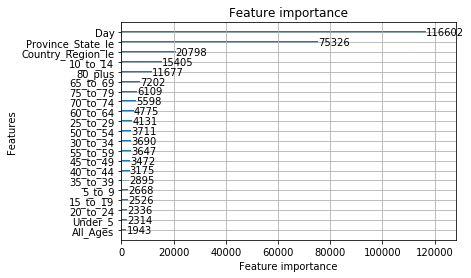

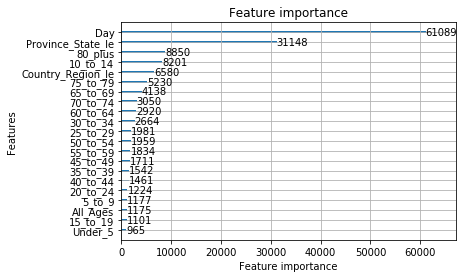

In [150]:

lgb_params = {
   'objective': 'regression',
    'metric': 'rmse',
}
lgb_train_1 = lgb.Dataset(x_train, y_train_1)
lgb_eval_1 = lgb.Dataset(x_val, y_val_1, reference=lgb_train_1)

lgb_model_1 = lgb.train(lgb_params,lgb_train_1, valid_sets=lgb_eval_1,num_boost_round=10000)
y_pred_1_lgb = lgb_model_1.predict(x_val, num_iteration = lgb_model_1.best_iteration)

lgb_train_2 = lgb.Dataset(x_train, y_train_2)
lgb_eval_2 = lgb.Dataset(x_val, y_val_2, reference=lgb_train_2)

lgb_model_2 = lgb.train(lgb_params,lgb_train_2, valid_sets=lgb_eval_2,num_boost_round=5000)
y_pred_2_lgb = lgb_model_1.predict(x_val, num_iteration = lgb_model_2.best_iteration)


print('Light LGB')
print('Case Error:',evaluate(y_pred_1_lgb,y_val_1),'\nFatalties Error:', evaluate(y_pred_2_lgb,y_val_2),'\nAverage Error:',(evaluate(y_pred_1_lgb,y_val_1)+evaluate(y_pred_2_lgb,y_val_2))/2)
print(lgb.plot_importance(lgb_model_1))
print(lgb.plot_importance(lgb_model_2))


# XGBoost

XGB:
Case Error: 0.8739096387029665 
Fatalties Error: 0.8598199638495665 
Average Error: 0.8668648012762665


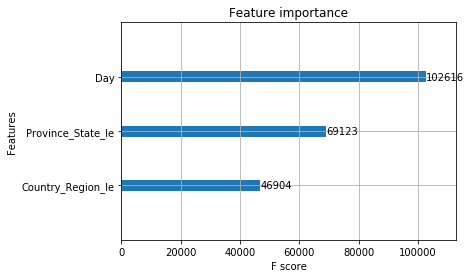

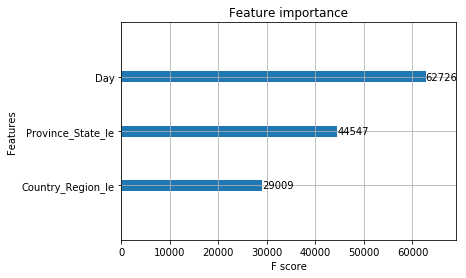

In [152]:
import xgboost
xgb_model_1= XGBRegressor(n_estimators = 4000)
xgb_model_1.fit(x_train_no_age,y_train_1)
y_pred_1_xgb = xgb_model_1.predict(x_val_no_age)
xgb_model_2= XGBRegressor(n_estimators = 4000)
xgb_model_2.fit(x_train_no_age,y_train_2)
y_pred_2_xgb = xgb_model_2.predict(x_val_no_age)
print('XGB:')
print('Case Error:',evaluate(y_pred_1_xgb,y_val_1),'\nFatalties Error:', evaluate(y_pred_2_xgb,y_val_2),'\nAverage Error:',(evaluate(y_pred_1_xgb,y_val_1)+evaluate(y_pred_2_xgb,y_val_2))/2)
xgboost.plot_importance(xgb_model_1)
xgboost.plot_importance(xgb_model_2)

In [153]:
import xgboost
xgb_model_1= XGBRegressor(n_estimators = 4000)
xgb_model_1.fit(x_train,y_train_1)
y_pred_1_xgb = xgb_model_1.predict(x_val)
xgb_model_2= XGBRegressor(n_estimators = 4000)
xgb_model_2.fit(x_train,y_train_2)
y_pred_2_xgb = xgb_model_2.predict(x_val)
print('XGB:')
print('Case Error:',evaluate(y_pred_1_xgb,y_val_1),'\nFatalties Error:', evaluate(y_pred_2_xgb,y_val_2),'\nAverage Error:',(evaluate(y_pred_1_xgb,y_val_1)+evaluate(y_pred_2_xgb,y_val_2))/2)
xgboost.plot_importance(xgb_model_1)
xgboost.plot_importance(xgb_model_2)


KeyboardInterrupt: 

In [ ]:
#XGB_val_result = pd.concat([x_val,pd.Series(y_pred_1_xgb),pd.Series(y_val_1),pd.Series(y_pred_2_xgb),pd.Series(y_val_2)],axis = 1)
#XGB_val_result = XGB_val_result.rename(columns = {0:'y_pred_1_xgb',1:'y_pred_2_xgb'})

In [ ]:
# XGB by
pred_result = pd.DataFrame({'Id': [], 'ConfirmedCases': [], 'Fatalities': [], 'y1_real':[], 'y2_real':[]})
for country in train['Country_Region'].unique():
    states = train[train['Country_Region']==country]['Province_State'].unique()
    for state in states:
        train_CS = train[(train['Country_Region']==country) & (train['Province_State']==state)]
        X_train_CS = train_CS[['Province_State_le', 'Country_Region_le', 'Day']]
        y1_train_CS = train_CS['ConfirmedCases']
        y2_train_CS = train_CS['Fatalities']
        
        val_CS = val[(val['Country_Region']==country) & (val['Province_State']==state)]
        X_val_CS = val_CS[['Province_State_le', 'Country_Region_le', 'Day']]
        y1_val_CS = val_CS['ConfirmedCases']
        y2_val_CS = val_CS['Fatalities']
        
        model1 = XGBRegressor(n_estimators=1000)
        model1.fit(X_train_CS, y1_train_CS)
        y1_pred = model1.predict(X_val_CS)
        
        model2 = XGBRegressor(n_estimators=1000)
        model2.fit(X_train_CS, y2_train_CS)
        y2_pred = model2.predict(X_val_CS)
        
        CS_result = pd.DataFrame({'Id': val_CS['Id'], 'ConfirmedCases': y1_pred, 'Fatalities': y2_pred,'y1_real':y1_val_CS, 'y2_real':y2_val_CS})
        pred_result = pd.concat([pred_result, CS_result], axis = 0)
        
#print(pred_result.head())
print(evaluate(pred_result['ConfirmedCases'], pred_result['y1_real']))
print(evaluate(pred_result['Fatalities'], pred_result['y2_real']))

pred_result['Case_pred_diff'] = np.sqrt((np.log(pred_result['y1_real']+1) - np.log(pred_result['ConfirmedCases'] + 1))**2)
pred_result['Death_pred_diff'] = np.sqrt((np.log(pred_result['y2_real']+1) - np.log(pred_result['Fatalities'] + 1))**2)
pred_result.sort_values(by='Case_pred_diff', ascending = False).head()

In [ ]:
#XGB_val_result.loc[XGB_val_result['y_pred_1_xgb'] < 0, 'y_pred_1_xgb'] = 0 
#XGB_val_result.loc[XGB_val_result['y_pred_2_xgb'] < 0, 'y_pred_2_xgb'] = 0 

# Random Forest

In [ ]:
random_forest_1=RandomForestRegressor(bootstrap=True, 
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=15,
            min_weight_fraction_leaf=0.0, n_estimators=150, 
            random_state=0, verbose=0, warm_start=False)
random_forest_1.fit(x_train_no_age,y_train_1)
y_pred_1 = random_forest_1.predict(x_val_no_age)

random_forest_2=RandomForestRegressor(bootstrap=True, 
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=15,
            min_weight_fraction_leaf=0.0, n_estimators=150, 
            random_state=0, verbose=0, warm_start=False)
random_forest_2.fit(x_train_no_age,y_train_2)
y_pred_2 = random_forest_2.predict(x_val_no_age)
print('Random Forest Regressor')
print('Case Error:',evaluate(y_pred_1,y_val_1),'\nFatalties Error:', evaluate(y_pred_2,y_val_2),'\nAverage Error:',(evaluate(y_pred_1,y_val_1)+evaluate(y_pred_2,y_val_2))/2)
print(random_forest_1.feature_importances_)
print(random_forest_2.feature_importances_)


# time series predictions
## FBprophet

In [ ]:
#! pip install fbprophet

In [ ]:
hk_cases = hk[['Date','ConfirmedCases']]
hk_cases = hk_cases.rename(columns = {'Date':'ds','ConfirmedCases':'y'})
#hk_cases['y'] = hk_cases['y'].diff()
hk_cases.tail()

In [ ]:
from fbprophet import Prophet

m = Prophet()
m.fit(hk_cases)

In [ ]:
future = m.make_future_dataframe(periods = 90)
forecast = m.predict(future)
forecast.tail()

In [ ]:
fig1 = m.plot(forecast)

## ARIMA

In [ ]:
# Build Model
# model = ARIMA(train, order=(3,2,1)) 
from statsmodels.tsa.arima_model import ARIMA

# 1,1,1ARIMA Model
michigan_train = michigan[michigan['From']=='train']['ConfirmedCases']
michigan_val = michigan[michigan['From']=='val']['ConfirmedCases']

model = ARIMA(michigan_train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(13, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=michigan[michigan['From']=='val']['Date'])
lower_series = pd.Series(conf[:, 0], index=michigan[michigan['From']=='val']['Date'])
upper_series = pd.Series(conf[:, 1], index=michigan[michigan['From']=='val']['Date'])

michigan_val = michigan[michigan['From']=='val']
michigan_val = michigan_val[['Date','ConfirmedCases']]
michigan_val.index = michigan_val['Date']

michigan_train = michigan[michigan['From']=='train']
michigan_train = michigan_train[['Date','ConfirmedCases']]
michigan_train.index = michigan_train['Date']

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(michigan_train['ConfirmedCases'], label='training')

plt.plot(michigan_val['ConfirmedCases'], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Michigan: Forecast vs Actuals')
plt.xticks(rotation = 45)
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
# 1,1,1ARIMA Model

us = all_data[all_data['Country_Region']=='US']

us_train = us[us['From']=='train']
us_val = us[us['From']=='val']

states = us['Province_State'].unique()

for state in states:
    print(state)
    
    cs_train = us_train[us_train['Province_State'] == state]
    cs_val = us_val[us_val['Province_State'] == state]
    if cs_train.empty:
        continue;
    if cs_val.empty:
        continue;
    if state in ['West Virginia','Arizona','Guam','Colorado','Delaware','Alaska','Iowa','Minnesota','Nebraska', 'North Dakota','Oregon']:
        continue
    model = ARIMA(cs_train['ConfirmedCases'], order=(1, 1, 1))  
    try:
        fitted = model.fit(disp=0)  
    except (ValueError or LinAlgError) :
        continue
    # Forecast
    fc, se, conf = fitted.forecast(len(cs_val), alpha=0.05)  # 95% conf
    
    # Make as pandas series
    fc_series = pd.Series(fc, index=cs_val['Date'])
    lower_series = pd.Series(conf[:, 0], index=cs_val['Date'])
    upper_series = pd.Series(conf[:, 1], index=cs_val['Date'])

    
    cs_val = cs_val[['Date','ConfirmedCases']]
    cs_val.index = cs_val['Date']

    
    cs_train = cs_train[['Date','ConfirmedCases']]
    cs_train.index = cs_train['Date']

    # Plot
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(cs_train['ConfirmedCases'], label='training')

    plt.plot(cs_val['ConfirmedCases'], label='actual')
    plt.plot(fc_series, label='forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
    plt.title(state+': Forecast vs Actuals')
    plt.xticks(rotation = 45)
    plt.legend(loc='upper left', fontsize=8)
    plt.show()